In [1]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta

import numpy.random as npr
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import scipy as sp
import seaborn as sns

import sys
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from scipy import optimize
from scipy import stats

%matplotlib inline

In [2]:
province    = pd.read_csv('../dati-province/dpc-covid19-ita-province.csv')
regioni     = pd.read_csv('../dati-regioni/dpc-covid19-ita-regioni.csv')
italia      = pd.read_csv('../dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
Popolazione = pd.read_csv('Popolazione_Regioni.csv', names=('provincia','sigla', 'popolazione'))
province

data stato  codice_regione denominazione_regione  \
0       2020-02-24T18:00:00   ITA              13               Abruzzo   
1       2020-02-24T18:00:00   ITA              13               Abruzzo   
2       2020-02-24T18:00:00   ITA              13               Abruzzo   
3       2020-02-24T18:00:00   ITA              13               Abruzzo   
4       2020-02-24T18:00:00   ITA              13               Abruzzo   
...                     ...   ...             ...                   ...   
101435  2022-01-21T17:00:00   ITA               5                Veneto   
101436  2022-01-21T17:00:00   ITA               5                Veneto   
101437  2022-01-21T17:00:00   ITA               5                Veneto   
101438  2022-01-21T17:00:00   ITA               5                Veneto   
101439  2022-01-21T17:00:00   ITA               5                Veneto   

        codice_provincia               denominazione_provincia  \
0                     66                              L'Aquila   
1                     67                                Teramo   
2                     68                               Pescara   
3                     69                                Chieti   
4                    979  In fase di definizione/aggiornamento   
...                  ...                                   ...   
101435                27                               Venezia   
101436                28                                Padova   
101437                29                                Rovigo   
101438               899    Fuori Regione / Provincia Autonoma   
101439               999  In fase di definizione/aggiornamento   

       sigla_provincia        lat       long  totale_casi note codice_nuts_1  \
0                   AQ  42.351222  13.398438            0  NaN           NaN   
1                   TE  42.658918  13.704400            0  NaN           NaN   
2                   PE  42.464584  14.213648            0  NaN           NaN   
3                   CH  42.351032  14.167546            0  NaN           NaN   
4                  NaN        NaN        NaN            0  NaN           NaN   
...                ...        ...        ...          ...  ...           ...   
101435              VE  45.434905  12.338452       155765  NaN           ITH   
101436              PD  45.406930  11.876087       184231  NaN           ITH   
101437              RO  45.071073  11.790070        39130  NaN           ITH   
101438             NaN        NaN        NaN        14974  NaN           ITH   
101439             NaN        NaN        NaN         4871  NaN           ITH   

       codice_nuts_2 codice_nuts_3  
0                NaN           NaN  
1                NaN           NaN  
2                NaN           NaN  
3                NaN           NaN  
4                NaN           NaN  
...              ...           ...  
101435          ITH3         ITH35  
101436          ITH3         ITH36  
101437          ITH3         ITH37  
101438          ITH3           NaN  
101439          ITH3           NaN  

[101440 rows x 14 columns]

In [3]:
today = datetime.today()
yesterday = (date.today() - timedelta(days=1))
if datetime.strptime(italia.data.iloc[-1], '%Y-%m-%dT%H:%M:%S').date() == today.date():
    idx = pd.date_range('24/02/2020', today)
    print('Today: ', today.date())
else:
    idx = pd.date_range('24/02/2020', yesterday)
    print('Yesterday: ', yesterday)

italia['data']                             = pd.to_datetime(italia['data'],format='%Y-%m-%dT%H:%M:%S',yearfirst=True, dayfirst=True)
italia['new_date']                         = italia['data'].dt.date
italia                                     = italia.set_index('new_date')
#italia.sort_index(inplace=True)
italia                                     = italia.reindex(idx)
italia.index                               = italia.index.strftime('%d/%m/%Y')

italia.variazione_totale_positivi.fillna(0,inplace=True)
italia.nuovi_positivi.fillna(            0,inplace=True)
italia.ingressi_terapia_intensiva.fillna(0,inplace=True)
italia.data.fillna(0,inplace=True)
italia.fillna(                           method='ffill',inplace=True)

Today:  2022-01-21


In [4]:
italia_week = italia.set_index('data').resample('w').bfill()
italia_week['ingressi_terapia_intensiva'] = italia.set_index('data').resample('w')['ingressi_terapia_intensiva'].sum()
italia_week

stato  ricoverati_con_sintomi  terapia_intensiva  \
data                                                          
2020-03-01   ITA                   639.0              140.0   
2020-03-08   ITA                  3557.0              650.0   
2020-03-15   ITA                  9663.0             1672.0   
2020-03-22   ITA                 19846.0             3009.0   
2020-03-29   ITA                 27386.0             3906.0   
...          ...                     ...                ...   
2021-12-26   ITA                  9220.0             1089.0   
2022-01-02   ITA                 11756.0             1319.0   
2022-01-09   ITA                 15647.0             1595.0   
2022-01-16   ITA                 18719.0             1691.0   
2022-01-23   NaN                     NaN                NaN   

            totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
data                                                                        
2020-03-01                 779.0                   798.0           1577.0   
2020-03-08                4207.0                  2180.0           6387.0   
2020-03-15               11335.0                  9268.0          20603.0   
2020-03-22               22855.0                 23783.0          46638.0   
2020-03-29               31292.0                 42588.0          73880.0   
...                          ...                     ...              ...   
2021-12-26               10309.0                506530.0         516839.0   
2022-01-02               13075.0               1057462.0        1070537.0   
2022-01-09               17242.0               1926737.0        1943979.0   
2022-01-16               20410.0               2528447.0        2548857.0   
2022-01-23                   NaN                     NaN              NaN   

            variazione_totale_positivi  nuovi_positivi  dimessi_guariti  \
data                                                                      
2020-03-01                       528.0           566.0             83.0   
2020-03-08                      1326.0          1492.0            622.0   
2020-03-15                      2853.0          3590.0           2335.0   
2020-03-22                      3957.0          5560.0           7024.0   
2020-03-29                      3815.0          5217.0          13030.0   
...                                ...             ...              ...   
2021-12-26                     16373.0         24883.0        4993863.0   
2022-01-02                     48744.0         61046.0        5119893.0   
2022-01-09                    125086.0        155659.0        5353922.0   
2022-01-16                     78010.0        149512.0        6016954.0   
2022-01-23                         NaN             NaN              NaN   

            deceduti  ...      tamponi  casi_testati                   note  \
data                  ...                                                     
2020-03-01      34.0  ...      21127.0           NaN                    NaN   
2020-03-08     366.0  ...      49937.0           NaN             pd-IT-0003   
2020-03-15    1809.0  ...     124899.0           NaN             nd-IT-0002   
2020-03-22    5476.0  ...     258402.0           NaN  nd-IT-0012;nd-IT-0014   
2020-03-29   10779.0  ...     454030.0           NaN             pd-IT-0009   
...              ...  ...          ...           ...                    ...   
2021-12-26  136611.0  ...  135355155.0    40263888.0             dc-IT-0071   
2022-01-02  137646.0  ...  141547196.0    41421590.0             dc-IT-0071   
2022-01-09  139038.0  ...  148159131.0    42725013.0             dc-IT-0071   
2022-01-16  141104.0  ...  155797197.0    44217594.0             dc-IT-0071   
2022-01-23       NaN  ...          NaN           NaN                    NaN   

            ingressi_terapia_intensiva  note_test note_casi  \
data                                                          
2020-03-01                         0.0        NaN       NaN

In [5]:
italia['casi_giornalieri']                 = italia['totale_casi'] - italia['totale_casi'].shift(1)
italia['morti_giornalieri']                = italia['deceduti'] - italia['deceduti'].shift(1)
italia['media_casi_giorn']                 = italia['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['media_morti_giorn']                = italia['morti_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['media_ingressi_terapia_intensiva'] = italia['ingressi_terapia_intensiva'].rolling(window=7, min_periods=1).mean()
italia

data stato  ricoverati_con_sintomi  \
24/02/2020 2020-02-24 18:00:00   ITA                     101   
25/02/2020 2020-02-25 18:00:00   ITA                     114   
26/02/2020 2020-02-26 18:00:00   ITA                     128   
27/02/2020 2020-02-27 18:00:00   ITA                     248   
28/02/2020 2020-02-28 18:00:00   ITA                     345   
...                        ...   ...                     ...   
17/01/2022 2022-01-17 17:00:00   ITA                   19228   
18/01/2022 2022-01-18 17:00:00   ITA                   19448   
19/01/2022 2022-01-19 17:00:00   ITA                   19500   
20/01/2022 2022-01-20 17:00:00   ITA                   19659   
21/01/2022 2022-01-21 17:00:00   ITA                   19485   

            terapia_intensiva  totale_ospedalizzati  isolamento_domiciliare  \
24/02/2020                 26                   127                      94   
25/02/2020                 35                   150                     162   
26/02/2020                 36                   164                     221   
27/02/2020                 56                   304                     284   
28/02/2020                 64                   409                     412   
...                       ...                   ...                     ...   
17/01/2022               1717                 20945                 2534333   
18/01/2022               1715                 21163                 2540993   
19/01/2022               1688                 21188                 2605402   
20/01/2022               1698                 21357                 2660684   
21/01/2022               1707                 21192                 2674511   

            totale_positivi  variazione_totale_positivi  nuovi_positivi  \
24/02/2020              221                           0             221   
25/02/2020              311                          90              93   
26/02/2020              385                          74              78   
27/02/2020              588                         203             250   
28/02/2020              821                         233             238   
...                     ...                         ...             ...   
17/01/2022          2555278                        6421           83403   
18/01/2022          2562156                        6878          212004   
19/01/2022          2626590                       64434          192320   
20/01/2022          2682041                       55451          188797   
21/01/2022          2695703                       13662          179106   

            dimessi_guariti  ...  note_casi  totale_positivi_test_molecolare  \
24/02/2020                1  ...        NaN                              NaN   
25/02/2020                1  ...        NaN                              NaN   
26/02/2020                3  ...        NaN                              NaN   
27/02/2020               45  ...        NaN                              NaN   
28/02/2020               46  ...        NaN                              NaN   
...                     ...  ...        ...                              ...   
17/01/2022          6093633  ...        NaN                        6731060.0   
18/01/2022          6314444  ...        NaN                        6786905.0   
19/01/2022          6450596  ...        NaN                        6845556.0   
20/01/2022          6593625  ...        NaN                        6904080.0   
21/01/2022          6765190  ...        NaN                        6977045.0   

            totale_positivi_test_antigenico_rapido  tamponi_test_molecolare  \
24/02/2020                                     NaN                      NaN   
25/02/2020                                     NaN                      NaN   
26/02/2020                                     NaN                      NaN   
27/02/2020                                     NaN                      NaN   
28/02/2020                                     NaN 

In [6]:
NomiProvince  = province.denominazione_provincia.unique()
NomiProvince.sort()
Popolazione['provincia'] = NomiProvince
Popolazione = Popolazione.set_index('provincia')

#create a data frame dictionary to store your data frames
Province      = {elem : pd.DataFrame for elem in NomiProvince}
Province_week = {elem : pd.DataFrame for elem in NomiProvince}
for key in Province.keys():
    Province[key] = province[:][province.denominazione_provincia == key]
    Province[key]['data']                       = pd.to_datetime(Province[key]['data'])
    if key != 'In fase di definizione/aggiornamento' and key != 'Fuori Regione / Provincia Autonoma':
        Province_week[key]                          = Province[key].set_index('data').resample('w').bfill()
    Province[key]['data']                       = Province[key]['data'].dt.strftime('%d/%m/%Y')
    Province[key]['casi_giornalieri']           = Province[key]['totale_casi'] - Province[key]['totale_casi'].shift(1)
    Province[key]['media_casi_giorn']           = Province[key]['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
    Province[key]['casi_giornalieri_norm']      = Province[key]['casi_giornalieri'] / Popolazione.at[key,'popolazione'] * 1e5
    Province[key]['media_casi_giorn_norm']      = Province[key]['media_casi_giorn'] / Popolazione.at[key,'popolazione'] * 1e5
    if key != 'In fase di definizione/aggiornamento' and key != 'Fuori Regione / Provincia Autonoma':
        Province_week[key]['casi_settimanali']      = Province_week[key]['totale_casi'] - Province_week[key]['totale_casi'].shift(1)
        Province_week[key]['casi_settimanali_norm'] = Province_week[key]['casi_settimanali'] / Popolazione.at[key,'popolazione'] * 1e5

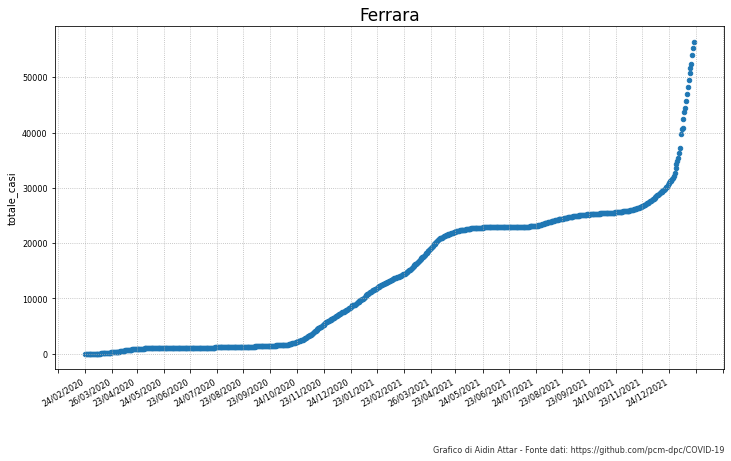

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))

Province['Ferrara'].plot(ax = ax, x ='data', y='totale_casi',
                         kind = 'scatter', title = "Ferrara",
                         xlabel = '')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Ferrara', fontsize=17)
ax.grid(linestyle='dotted')
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

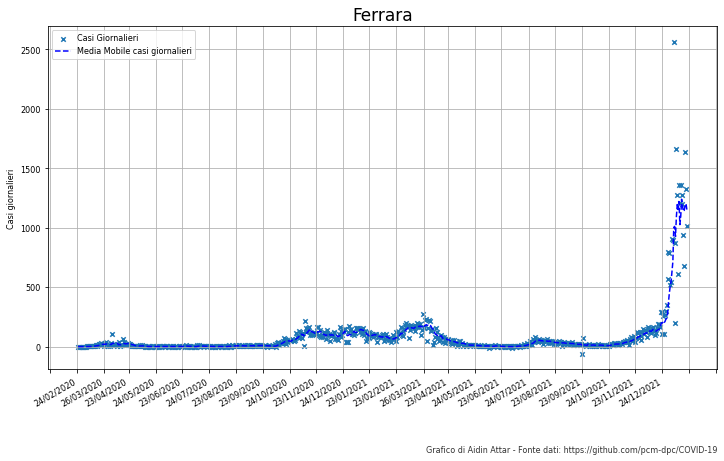

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))

Province['Ferrara'].plot(ax = ax, x ='data', y='casi_giornalieri',
             kind = 'scatter', title = "Ferrara", label = 'Casi Giornalieri',
             marker = 'x', color = 'C0',)
Province['Ferrara'].plot(ax = ax, x ='data', y='media_casi_giorn',
             kind = 'line', title = "Ferrara", color = 'blue',
             label = 'Media Mobile casi giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Ferrara', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()


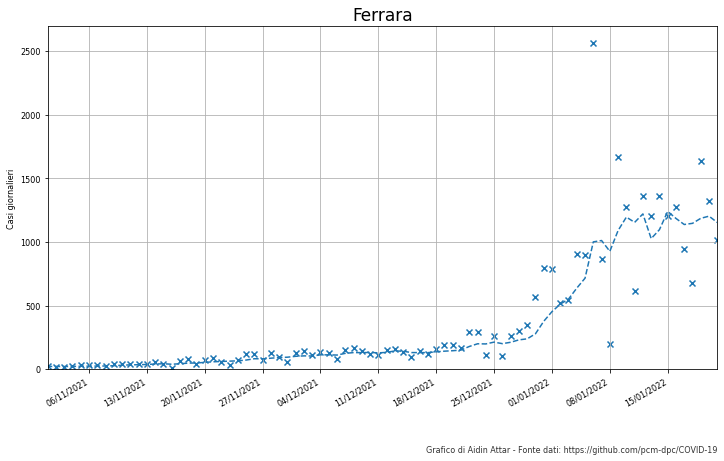

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(Province['Ferrara']['data'], Province['Ferrara']['casi_giornalieri'], marker='x',label = 'Casi giornalieri')
ax.plot(Province['Ferrara']['data'], Province['Ferrara']['media_casi_giorn'], linestyle='dashed',label = 'Media Mobile casi giornalieri')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_title('Ferrara', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.set_xlim([date(2021, 11, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.set_ylim(bottom=0)
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()


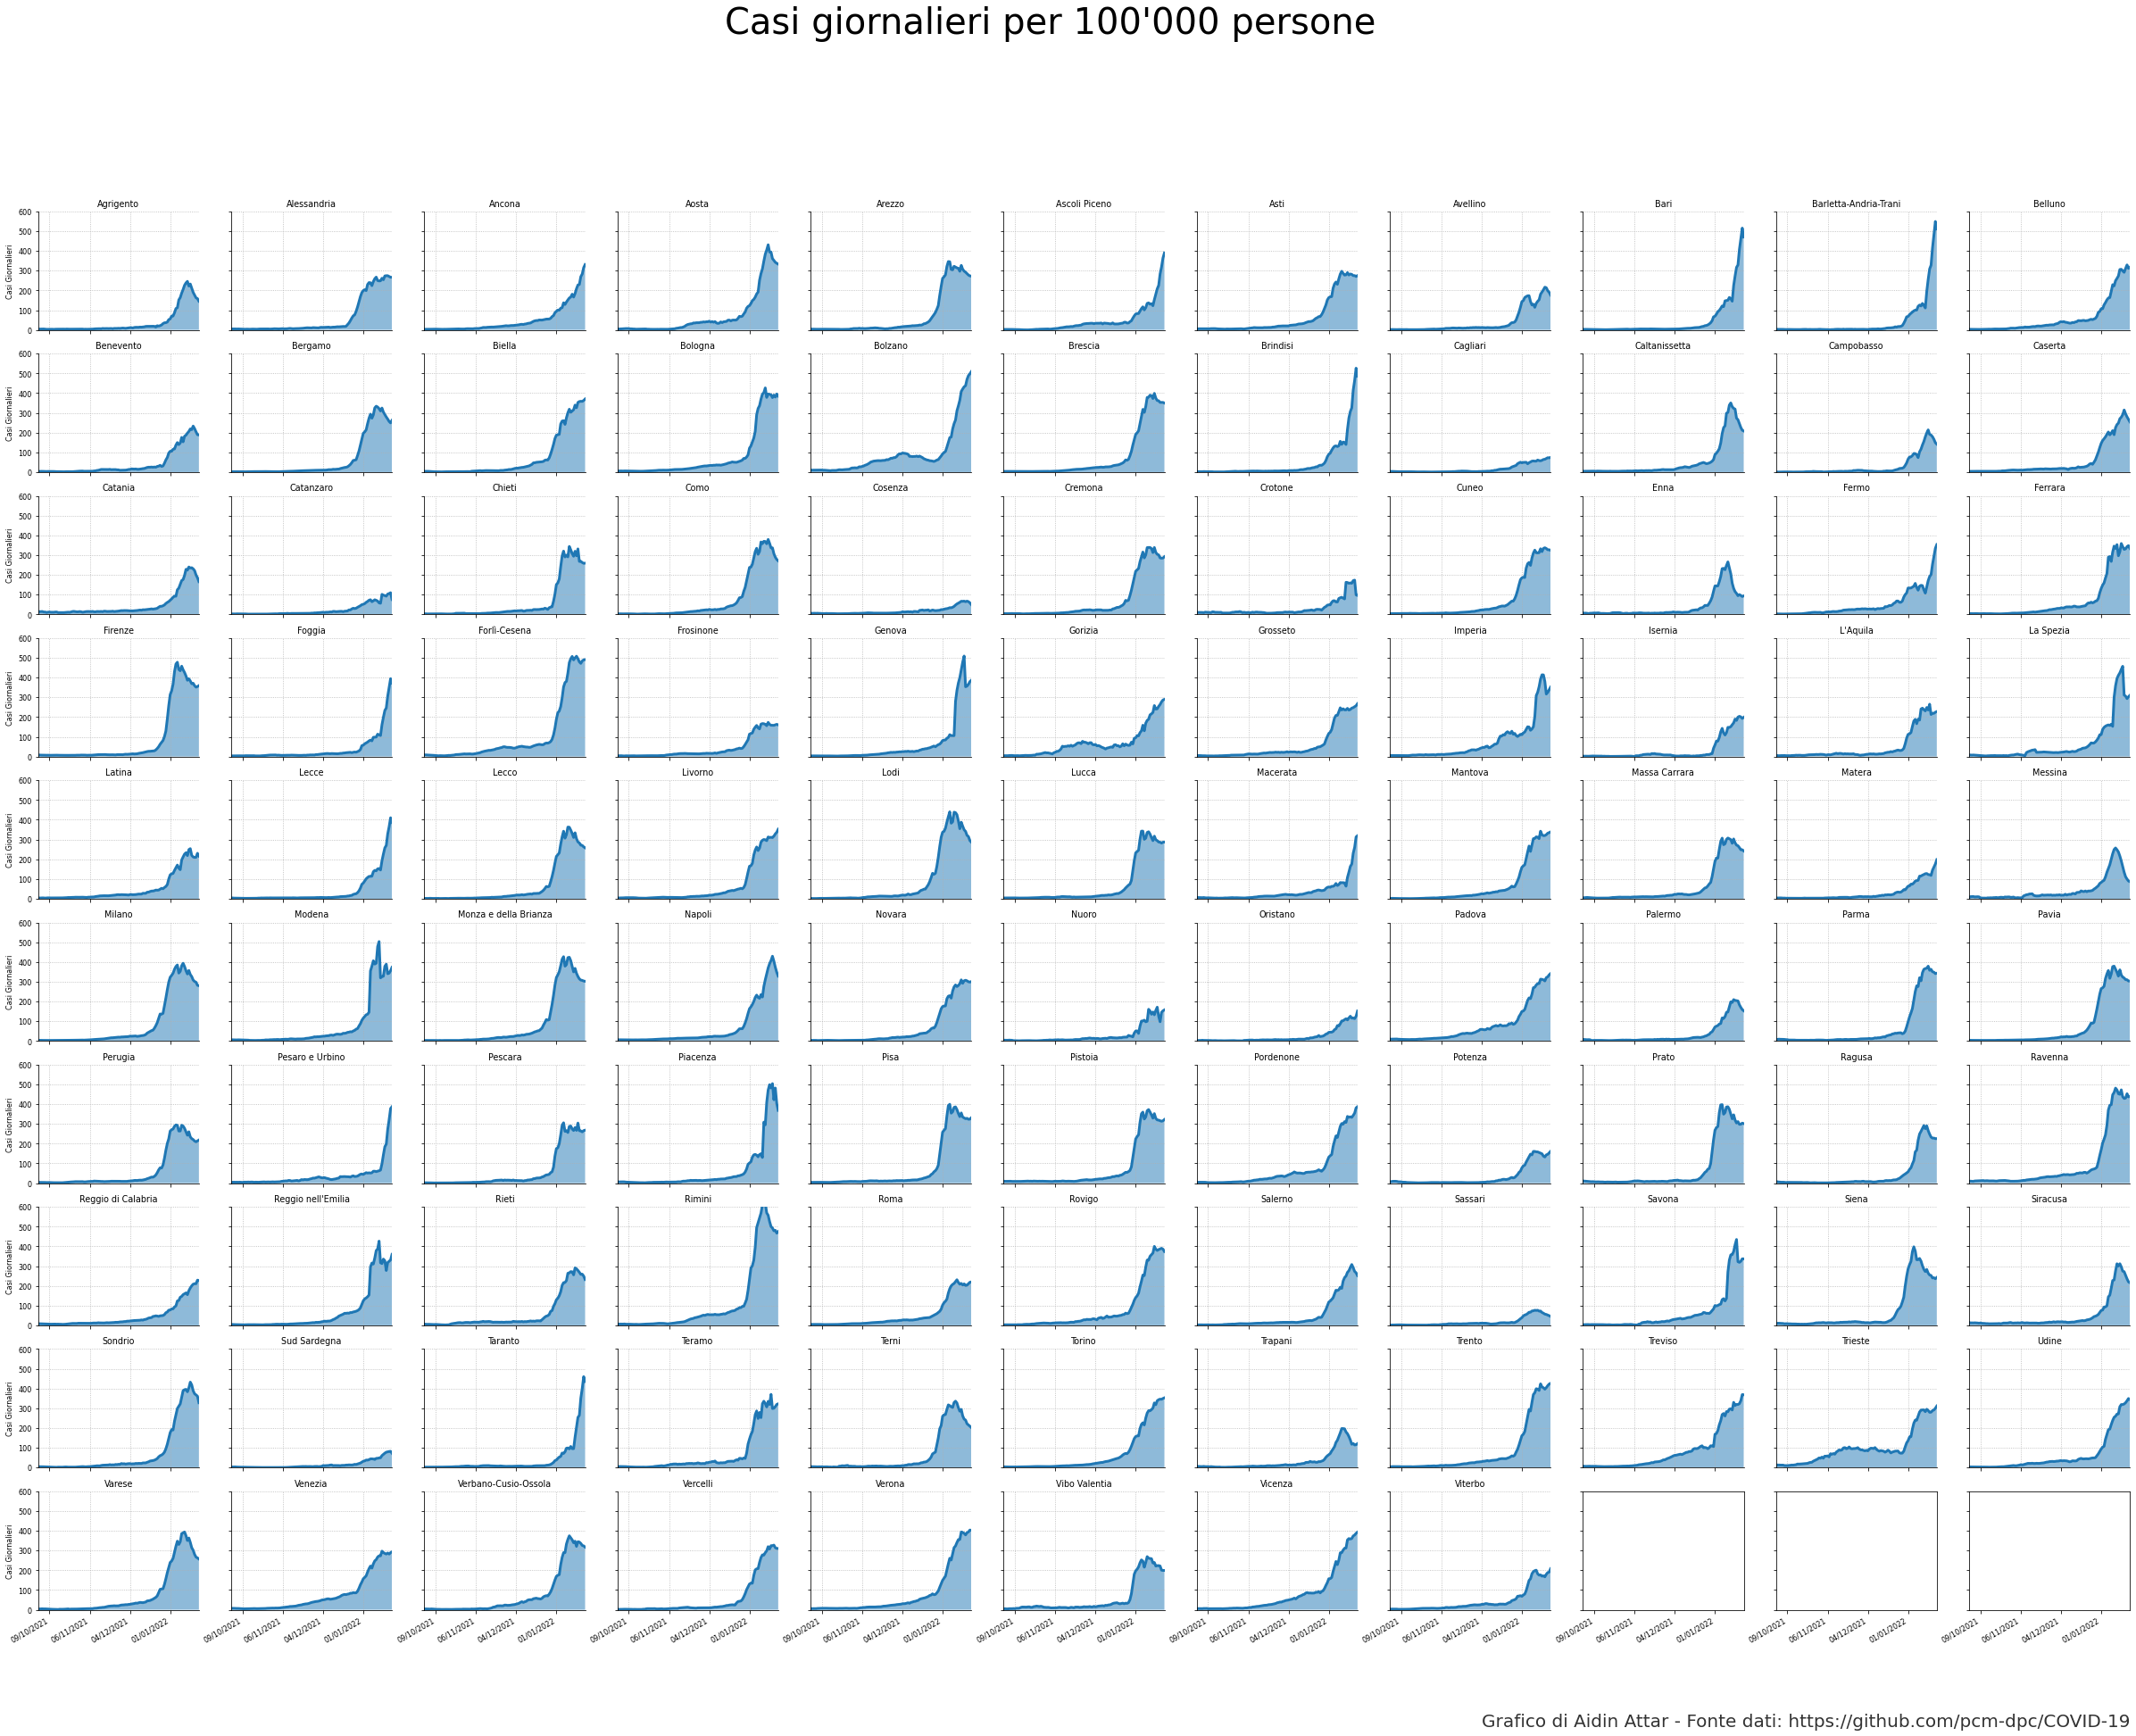

In [10]:
fig, ax = plt.subplots(nrows=10, ncols=11, sharey=True, sharex=True, figsize=(42, 32))

x = 0
y = 0
for key in Province.keys():
    if key != 'In fase di definizione/aggiornamento' and key != 'Fuori Regione / Provincia Autonoma':
        ax[y,x].plot(Province[key]['data'], Province[key]['media_casi_giorn_norm'], linewidth=3)
        ax[y,x].fill_between(Province[key]['data'], Province[key]['media_casi_giorn_norm'], facecolor="C0", alpha=0.5)
        ax[y,x].set_title(key)
        ax[y,x].spines['right'].set_visible(False)
        ax[y,x].spines['top'].set_visible(False)
        ax[y,x].spines['left'].set_visible(True)
        ax[y,x].spines['bottom'].set_visible(True)
        ax[y,x].grid(linestyle='dotted')
        #ax[y,x].axis('off')
        x += 1
        if x == 11:
            y +=1
            x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Casi Giornalieri')
ax[1,0].set_ylabel('Casi Giornalieri')
ax[2,0].set_ylabel('Casi Giornalieri')
ax[3,0].set_ylabel('Casi Giornalieri')
ax[4,0].set_ylabel('Casi Giornalieri')
ax[5,0].set_ylabel('Casi Giornalieri')
ax[6,0].set_ylabel('Casi Giornalieri')
ax[7,0].set_ylabel('Casi Giornalieri')
ax[8,0].set_ylabel('Casi Giornalieri')
ax[9,0].set_ylabel('Casi Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Casi giornalieri per 100'000 persone", fontsize=40)
ax[0,0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax[0,0].set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax[0,0].set_ylim([0, 600])
plt.text(0.9, 0.15, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure, fontsize=20, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [11]:
NomiRegioni = regioni.denominazione_regione.unique()
PopoRegioni = [1312000,562869,1947000,5802000,4459000,1215000,5879000,1551000,10060000,1525000,305617,520891,538223,4356000,4029000,1640000,5000000,3730000,882015,125666,4906000]
DictRegioni = dict(zip(NomiRegioni, PopoRegioni))

#create a data frame dictionary to store your data frames
Regioni      = {elem : pd.DataFrame for elem in NomiRegioni}
Regioni_week = {elem : pd.DataFrame for elem in NomiRegioni}
for key in Regioni.keys():
    Regioni[key] = regioni[:][regioni.denominazione_regione == key]
    Regioni[key]['data']                            = pd.to_datetime(Regioni[key]['data'],format='%Y-%m-%dT%H:%M:%S',yearfirst=True, dayfirst=True)
    Regioni[key]['new_date']                        = Regioni[key]['data'].dt.date
    Regioni[key]                                    = Regioni[key].set_index('new_date')
    Regioni[key].sort_index(inplace=True)
    Regioni[key]                                    = Regioni[key].reindex(idx)
    Regioni[key].index                              = Regioni[key].index.strftime('%d/%m/%Y')

    Regioni_week[key]                               = Regioni[key].set_index('data').resample('w').bfill()
    Regioni_week[key]['ingressi_terapia_intensiva'] = Regioni[key].set_index('data').resample('w')['ingressi_terapia_intensiva'].sum()

    Regioni[key]['casi_giornalieri']                = Regioni[key]['totale_casi'] - Regioni[key]['totale_casi'].shift(1)
    Regioni[key]['media_casi_giorn']                = Regioni[key]['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['morti_giornalieri']               = Regioni[key]['deceduti'] - Regioni[key]['deceduti'].shift(1)
    Regioni[key]['media_morti_giorn']               = Regioni[key]['morti_giornalieri'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['casi_giornalieri_norm']           = Regioni[key]['casi_giornalieri'] / DictRegioni[key] * 1e5
    Regioni[key]['media_casi_giorn_norm']           = Regioni[key]['media_casi_giorn'] / DictRegioni[key] * 1e5
    Regioni[key]['morti_giornalieri_norm']          = Regioni[key]['morti_giornalieri'] / DictRegioni[key] * 1e5
    Regioni[key]['media_morti_giorn_norm']          = Regioni[key]['media_morti_giorn'] / DictRegioni[key] * 1e5

    Regioni[key]['tamponi_giornalieri']             = Regioni[key]['tamponi'] - Regioni[key]['tamponi'].shift(1)
    Regioni[key]['media_tamponi']                   = Regioni[key]['tamponi_giornalieri'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tasso_positivi']                  = Regioni[key]['casi_giornalieri'] / Regioni[key]['tamponi_giornalieri'] * 100
    Regioni[key].drop(Regioni[key][Regioni[key].tasso_positivi < 0].index, inplace=True)
    Regioni[key]['media_tasso_positivi']            = Regioni[key]['tasso_positivi'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tamponi_giornalieri_norm']        = Regioni[key]['tamponi_giornalieri'] / DictRegioni[key] * 1e5
    Regioni[key]['media_tamponi_giorn_norm']        = Regioni[key]['media_tamponi'] / DictRegioni[key] * 1e5

    Regioni[key]['casi_testati_giorn']              = Regioni[key]['casi_testati'] - Regioni[key]['casi_testati'].shift(1)
    Regioni[key]['media_casi_testati']              = Regioni[key]['casi_testati_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tasso_casi']                      = Regioni[key]['casi_giornalieri'] / Regioni[key]['casi_testati_giorn'] * 100
    Regioni[key].drop(Regioni[key][Regioni[key].tasso_casi < 0].index, inplace=True)
    Regioni[key]['media_tasso_casi']                = Regioni[key]['tasso_casi'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['casi_testati_norm']               = Regioni[key]['casi_testati_giorn'] / DictRegioni[key] * 1e5
    Regioni[key]['media_casi_testati_norm']         = Regioni[key]['media_casi_testati'] / DictRegioni[key] * 1e5

    Regioni[key]['tamponi_test_molecolare_giorn']            = Regioni[key]['tamponi_test_molecolare']         - Regioni[key]['tamponi_test_molecolare'].shift(1)
    Regioni[key]['media_tamponi_test_molecolare_giorn']      = Regioni[key]['tamponi_test_molecolare_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['totale_positivi_test_molecolare_giorn']    = Regioni[key]['totale_positivi_test_molecolare'] - Regioni[key]['totale_positivi_test_molecolare'].shift(1)
    Regioni[key]['media_pos_molecolare']                     = Regioni[key]['totale_positivi_test_molecolare_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tasso_molecolare']                         = Regioni[key]['totale_positivi_test_molecolare_giorn'] / Regioni[key]['tamponi_test_molecolare_giorn'] * 100
    Regioni[key].drop(Regioni[key][Regioni[key].tasso_molecolare < 0].index, inplace=True)
    Regioni[key]['media_tasso_molecolare']                   = Regioni[key]['tasso_molecolare'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tamponi_test_molecolare_giorn_norm']       = Regioni[key]['tamponi_test_molecolare_giorn'] / DictRegioni[key] * 1e5
    Regioni[key]['media_tamponi_test_molecolare_giorn_norm'] = Regioni[key]['media_tamponi_test_molecolare_giorn'] / DictRegioni[key] * 1e5

    Regioni[key]['tamponi_test_antigenico_rapido_giorn']  = Regioni[key]['tamponi_test_antigenico_rapido']  - Regioni[key]['tamponi_test_antigenico_rapido'].shift(1)
    Regioni[key]['media_test_antigenico_rapido_giorn'] = Regioni[key]['tamponi_test_antigenico_rapido_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['totale_positivi_test_antigenico_rapido_giorn'] = Regioni[key]['totale_positivi_test_antigenico_rapido'] - Regioni[key]['totale_positivi_test_antigenico_rapido'].shift(1)
    Regioni[key]['media_pos_antigenico_rapido']                  = Regioni[key]['totale_positivi_test_antigenico_rapido_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tasso_antigenico_rapido']                      = Regioni[key]['totale_positivi_test_antigenico_rapido_giorn'] / Regioni[key]['tamponi_test_antigenico_rapido_giorn'] * 100
    Regioni[key].drop(Regioni[key][Regioni[key].tasso_antigenico_rapido < 0].index, inplace=True)
    Regioni[key]['media_tasso_antigenico_rapido']                = Regioni[key]['tasso_antigenico_rapido'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tamponi_test_antigenico_rapido_giorn_norm']        = Regioni[key]['tamponi_test_antigenico_rapido_giorn'] / DictRegioni[key] * 1e5
    Regioni[key]['media_test_antigenico_rapido_giorn_norm']  = Regioni[key]['media_test_antigenico_rapido_giorn'] / DictRegioni[key] * 1e5

    Regioni[key]['media_ingressi_terapia_intensiva'] = Regioni[key]['ingressi_terapia_intensiva'].rolling(window=7, min_periods=1).mean()

    Regioni_week[key]['casi_settimanali']         = Regioni_week[key]['totale_casi'] - Regioni_week[key]['totale_casi'].shift(1)
    Regioni_week[key]['morti_settimanali']        = Regioni_week[key]['deceduti'] - Regioni_week[key]['deceduti'].shift(1)
    Regioni_week[key]['casi_settimanali_norm']    = Regioni_week[key]['casi_settimanali'] / DictRegioni[key] * 1e5
    Regioni_week[key]['morti_settimanali_norm']   = Regioni_week[key]['morti_settimanali'] / DictRegioni[key] * 1e5

    Regioni_week[key]['tamponi_settimanali']      = Regioni_week[key]['tamponi'] - Regioni_week[key]['tamponi'].shift(1)
    Regioni_week[key]['tasso_positivi']           = Regioni_week[key]['casi_settimanali'] / Regioni_week[key]['tamponi_settimanali'] * 100
    Regioni_week[key].drop(Regioni_week[key][Regioni_week[key].tasso_positivi < 0].index, inplace=True)
    Regioni_week[key]['tamponi_settimanali_norm'] = Regioni_week[key]['tamponi_settimanali'] / DictRegioni[key] * 1e5

    Regioni_week[key]['casi_testati_sett']       = Regioni_week[key]['casi_testati'] - Regioni_week[key]['casi_testati'].shift(1)
    Regioni_week[key]['tasso_casi']               = Regioni_week[key]['casi_settimanali'] / Regioni_week[key]['casi_testati_sett'] * 100
    Regioni_week[key].drop(Regioni_week[key][Regioni_week[key].tasso_casi < 0].index, inplace=True)
    Regioni_week[key]['casi_testati_norm']        = Regioni_week[key]['casi_testati_sett'] / DictRegioni[key] * 1e5

    Regioni_week[key]['tamponi_test_molecolare_sett']         = Regioni_week[key]['tamponi_test_molecolare']         - Regioni_week[key]['tamponi_test_molecolare'].shift(1)
    Regioni_week[key]['totale_positivi_test_molecolare_sett'] = Regioni_week[key]['totale_positivi_test_molecolare'] - Regioni_week[key]['totale_positivi_test_molecolare'].shift(1)
    Regioni_week[key]['tasso_molecolare']                      = Regioni_week[key]['totale_positivi_test_molecolare_sett'] / Regioni_week[key]['tamponi_test_molecolare_sett'] * 100
    Regioni_week[key].drop(Regioni_week[key][Regioni_week[key].tasso_molecolare < 0].index, inplace=True)
    Regioni_week[key]['tamponi_test_molecolare_sett_norm']        = Regioni_week[key]['tamponi_test_molecolare_sett'] / DictRegioni[key] * 1e5

    Regioni_week[key]['tamponi_test_antigenico_rapido_sett']  = Regioni_week[key]['tamponi_test_antigenico_rapido']  - Regioni_week[key]['tamponi_test_antigenico_rapido'].shift(1)
    Regioni_week[key]['totale_positivi_test_antigenico_rapido_sett'] = Regioni_week[key]['totale_positivi_test_antigenico_rapido'] - Regioni_week[key]['totale_positivi_test_antigenico_rapido'].shift(1)
    Regioni_week[key]['tasso_antigenico_rapido']                      = Regioni_week[key]['totale_positivi_test_antigenico_rapido_sett'] / Regioni_week[key]['tamponi_test_antigenico_rapido_sett'] * 100
    Regioni_week[key].drop(Regioni_week[key][Regioni_week[key].tasso_antigenico_rapido < 0].index, inplace=True)
    Regioni_week[key]['tamponi_test_antigenico_rapido_sett_norm']        = Regioni_week[key]['tamponi_test_antigenico_rapido_sett'] / DictRegioni[key] * 1e5

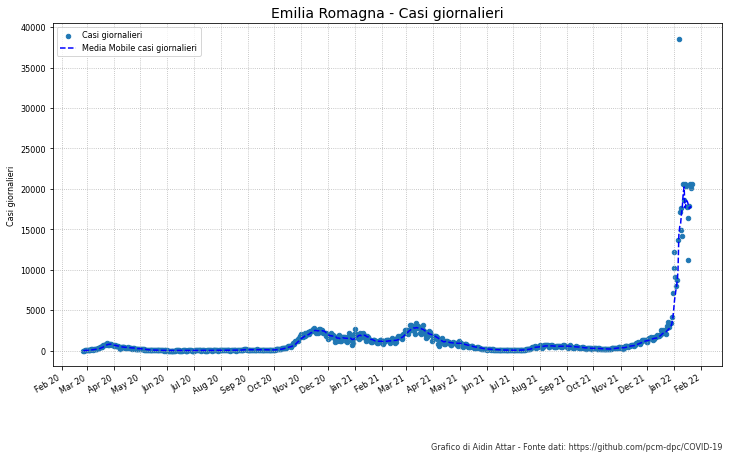

In [12]:
fig, ax = plt.subplots(figsize=(12, 7))

Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='casi_giornalieri',
                               kind='scatter', label='Casi giornalieri',  color='C0')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_casi_giorn'],
        color = 'blue', label = 'Media Mobile casi giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Emilia Romagna - Casi giornalieri', fontsize=14)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

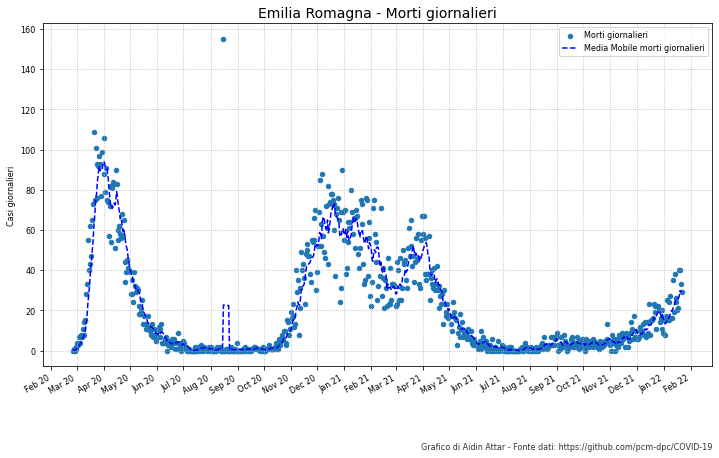

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))

Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='morti_giornalieri',
                               kind='scatter', label='Morti giornalieri',  color='C0')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_morti_giorn'],
        color = 'blue', label = 'Media Mobile morti giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Emilia Romagna - Morti giornalieri', fontsize=14)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
ax.legend()
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

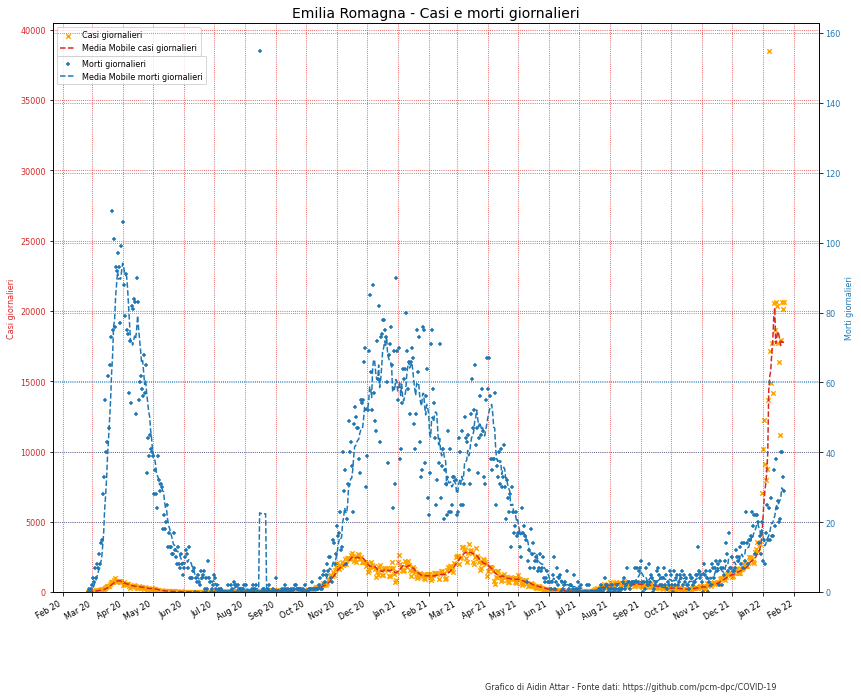

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Casi giornalieri', color=color)
Regioni['Emilia-Romagna'].plot(ax=ax1, x ='data', y='casi_giornalieri',
                               kind='scatter', label='Casi giornalieri',  color='orange',
                               marker='x', ylabel='Casi giornalieri', xlabel='')
ax1.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_casi_giorn'],
        color = color, label = 'Media Mobile casi giornalieri', linestyle='dashed')

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Morti giornalieri', color=color)

Regioni['Emilia-Romagna'].plot(ax=ax2, x ='data', y='morti_giornalieri',
                               kind='scatter', label='Morti giornalieri',  color='C0',
                               marker='+', ylabel='Morti giornalieri', xlabel='')
ax2.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_morti_giorn'],
        color = color, label = 'Media Mobile morti giornalieri', linestyle='dashed')

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_title('Emilia Romagna - Casi e morti giornalieri', fontsize=14)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [15]:
italia['casi_giornalieri']                 = italia['totale_casi'] - italia['totale_casi'].shift(1)
italia['media_casi_giorn']                 = italia['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['morti_giornalieri']                = italia['deceduti'] - italia['deceduti'].shift(1)
italia['media_morti_giorn']                = italia['morti_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['media_ingressi_terapia_intensiva'] = italia['ingressi_terapia_intensiva'].rolling(window=7, min_periods=1).mean()


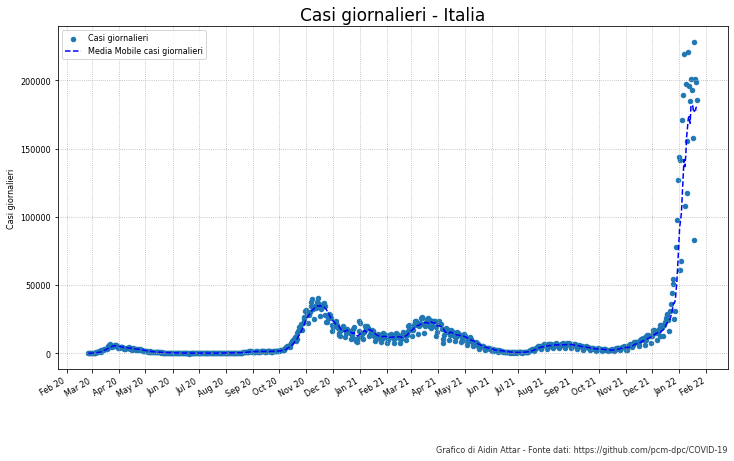

In [16]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='casi_giornalieri',
                               kind='scatter', label='Casi giornalieri',  color='C0')
ax.plot(italia['data'], italia['media_casi_giorn'],
        color = 'blue', label = 'Media Mobile casi giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Casi giornalieri - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

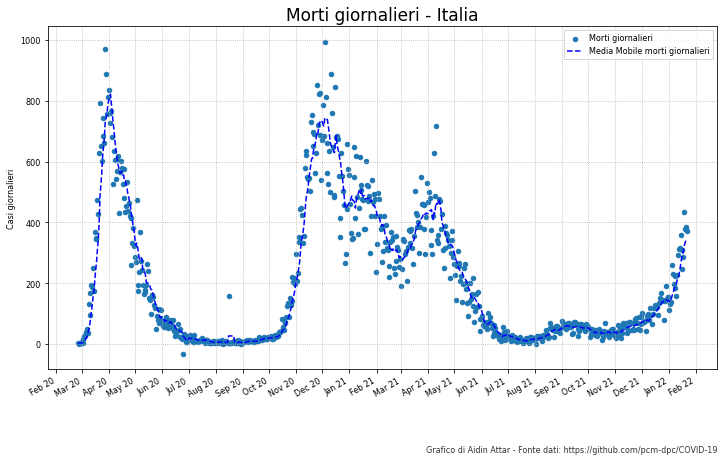

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='morti_giornalieri',
            kind='scatter', label='Morti giornalieri',  color='C0')
ax.plot(italia['data'], italia['media_morti_giorn'],
        color = 'blue', label = 'Media Mobile morti giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Morti giornalieri - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

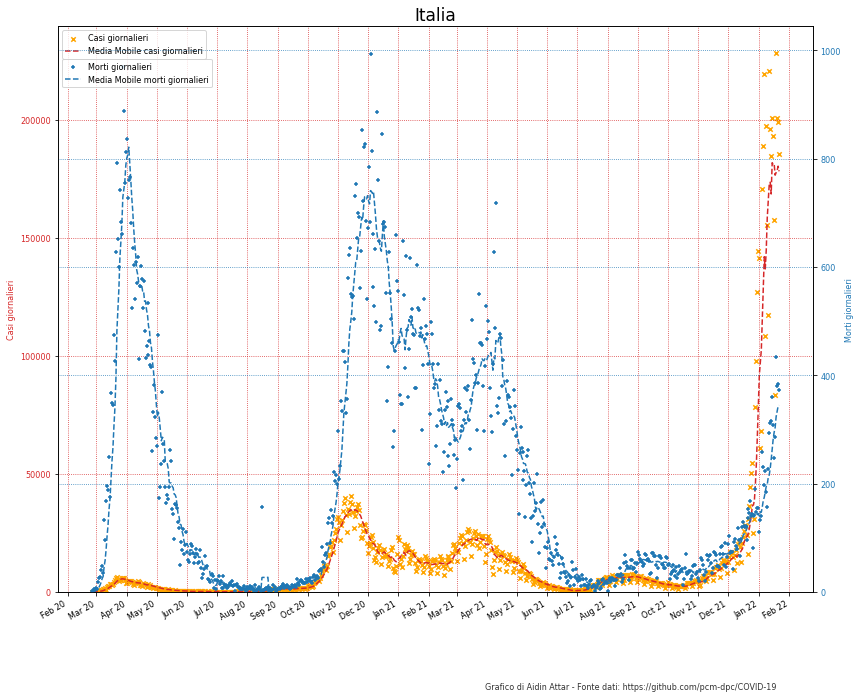

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Casi giornalieri', color=color)
italia.plot(ax=ax1, x ='data', y='casi_giornalieri', 
                               kind='scatter', label='Casi giornalieri',  color='orange',
                               marker='x', ylabel='Casi giornalieri', xlabel='')
ax1.plot(italia['data'], italia['media_casi_giorn'],
        color = color, label = 'Media Mobile casi giornalieri', linestyle='dashed')

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Morti giornalieri', color=color)

italia.plot(ax=ax2, x ='data', y='morti_giornalieri', 
                               kind='scatter', label='Morti giornalieri',  color='C0',
                               marker='+', ylabel='Morti giornalieri', xlabel='')
ax2.plot(italia['data'], italia['media_morti_giorn'],
        color = color, label = 'Media Mobile morti giornalieri', linestyle='dashed')

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_title('Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


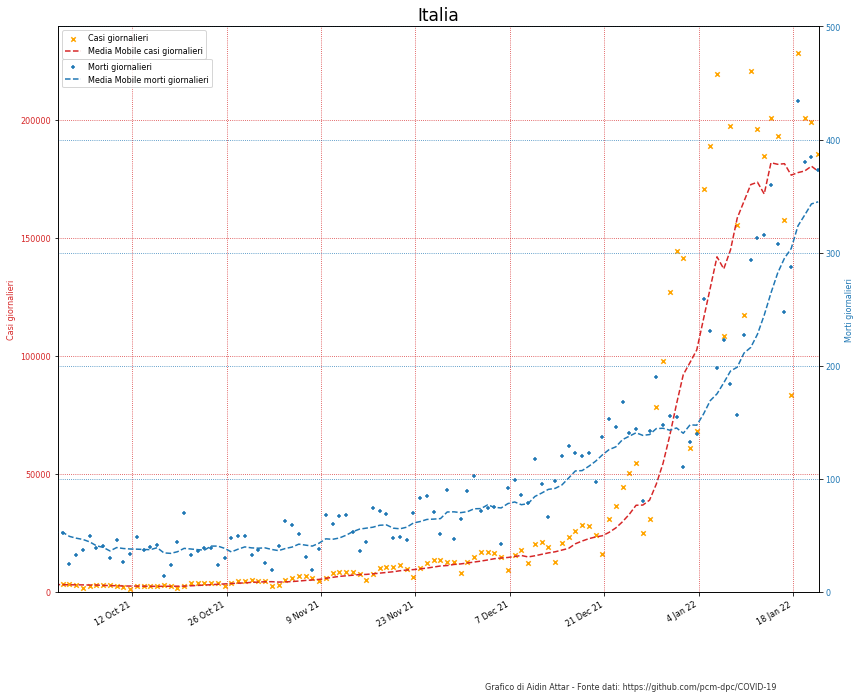

In [19]:
today = datetime.today()
yesterday = (date.today() - timedelta(days=1))
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Casi giornalieri', color=color)
italia.plot(ax=ax1, x ='data', y='casi_giornalieri',
            kind='scatter', label='Casi giornalieri',  color='orange',
            marker='x', ylabel='Casi giornalieri', xlabel='')
ax1.plot(italia['data'], italia['media_casi_giorn'],
         color = color, label = 'Media Mobile casi giornalieri', linestyle='dashed')

ax1.set_xlim([date(2021, 10, 1), today])
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Morti giornalieri', color=color)

italia.plot(ax=ax2, x ='data', y='morti_giornalieri',
                               kind='scatter', label='Morti giornalieri',  color='C0',
                               marker='+', ylabel='Morti giornalieri', xlabel='')
ax2.plot(italia['data'], italia['media_morti_giorn'],
        color = color, label = 'Media Mobile morti giornalieri', linestyle='dashed')

fig.autofmt_xdate()
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.set_title('Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0, top=500)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [20]:
italia['tamponi_giornalieri'] = italia['tamponi'] - italia['tamponi'].shift(1)
italia['media_tamponi']       = italia['tamponi_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['tasso_positivi']      = italia['casi_giornalieri'] / italia['tamponi_giornalieri'] * 100
italia.drop(italia[italia.tasso_positivi < 0].index, inplace=True)
italia['media_tasso_positivi']     = italia['tasso_positivi'].rolling(window=7, min_periods=1).mean()

italia['casi_testati_giorn'] = italia['casi_testati'] - italia['casi_testati'].shift(1)
italia['media_casi_testati'] = italia['casi_testati_giorn'].rolling(window=7, min_periods=1).mean()
italia['tasso_casi']         = italia['casi_giornalieri'] / italia['casi_testati_giorn'] * 100
italia.drop(italia[italia.tasso_casi < 0].index, inplace=True)
italia['media_tasso_casi']   = italia['tasso_casi'].rolling(window=7, min_periods=1).mean()

italia['tamponi_test_molecolare_giorn']         = italia['tamponi_test_molecolare']         - italia['tamponi_test_molecolare'].shift(1)
italia['media_tamponi_test_molecolare_giorn'] = italia['tamponi_test_molecolare_giorn'].rolling(window=7, min_periods=1).mean()
italia['totale_positivi_test_molecolare_giorn'] = italia['totale_positivi_test_molecolare'] - italia['totale_positivi_test_molecolare'].shift(1)
italia['media_pos_molecolare']                  = italia['totale_positivi_test_molecolare_giorn'].rolling(window=7, min_periods=1).mean()
italia['tasso_molecolare']                      = italia['totale_positivi_test_molecolare_giorn'] / italia['tamponi_test_molecolare_giorn'] * 100
italia.drop(italia[italia.tasso_molecolare < 0].index, inplace=True)
italia['media_tasso_molecolare']                = italia['tasso_molecolare'].rolling(window=7, min_periods=1).mean()

italia['tamponi_test_antigenico_rapido_giorn']  = italia['tamponi_test_antigenico_rapido']  - italia['tamponi_test_antigenico_rapido'].shift(1)
italia['media_test_antigenico_rapido_giorn'] = italia['tamponi_test_antigenico_rapido_giorn'].rolling(window=7, min_periods=1).mean()
italia['totale_positivi_test_antigenico_rapido_giorn'] = italia['totale_positivi_test_antigenico_rapido'] - italia['totale_positivi_test_antigenico_rapido'].shift(1)
italia['media_pos_antigenico_rapido']                  = italia['totale_positivi_test_antigenico_rapido_giorn'].rolling(window=7, min_periods=1).mean()
italia['tasso_antigenico_rapido']                      = italia['totale_positivi_test_antigenico_rapido_giorn'] / italia['tamponi_test_antigenico_rapido_giorn'] * 100
italia.drop(italia[italia.tasso_molecolare < 0].index, inplace=True)
italia['media_tasso_antigenico_rapido']                = italia['tasso_antigenico_rapido'].rolling(window=7, min_periods=1).mean()



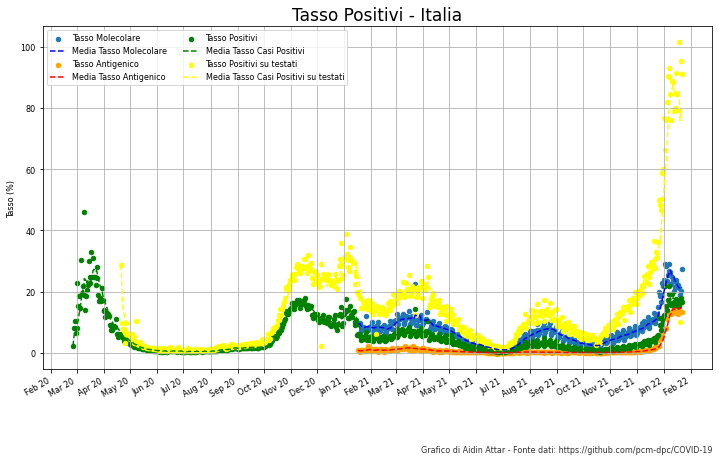

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='tasso_molecolare',
                               kind='scatter', label='Tasso Molecolare',  color='C0')
ax.plot(italia['data'], italia['media_tasso_molecolare'],
        color = 'blue', label = 'Media Tasso Molecolare', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tasso_antigenico_rapido',
                               kind='scatter', label='Tasso Antigenico',  color='orange')
ax.plot(italia['data'], italia['media_tasso_antigenico_rapido'],
        color = 'red', label = 'Media Tasso Antigenico', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tasso_positivi',
                               kind='scatter', label='Tasso Positivi',  color='green')
ax.plot(italia['data'], italia['media_tasso_positivi'],
        color = 'green', label = 'Media Tasso Casi Positivi', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tasso_casi',
                               kind='scatter', label='Tasso Positivi su testati',  color='yellow')
ax.plot(italia['data'], italia['media_tasso_casi'],
        color = 'yellow', label = 'Media Tasso Casi Positivi su testati', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Tasso Positivi - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Tasso (%)')
ax.set_xlabel("")
ax.legend(loc='upper left', ncol=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

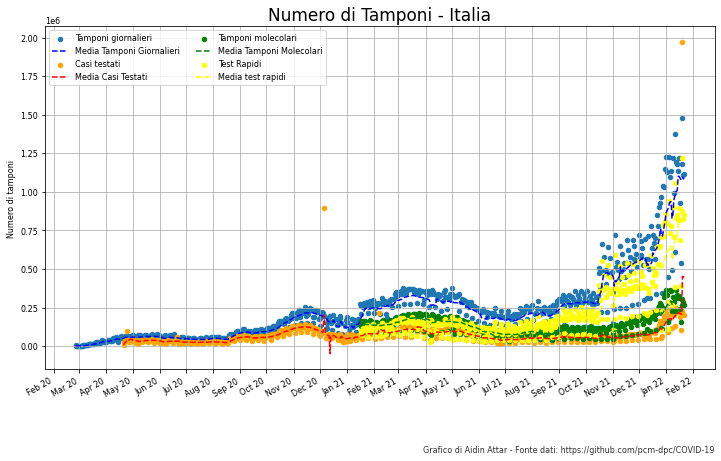

In [22]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='tamponi_giornalieri',
                               kind='scatter', label='Tamponi giornalieri',  color='C0')
ax.plot(italia['data'], italia['media_tamponi'],
        color = 'blue', label = 'Media Tamponi Giornalieri', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='casi_testati_giorn',
                               kind='scatter', label='Casi testati',  color='orange')
ax.plot(italia['data'], italia['media_casi_testati'],
        color = 'red', label = 'Media Casi Testati', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tamponi_test_molecolare_giorn',
                               kind='scatter', label='Tamponi molecolari',  color='green')
ax.plot(italia['data'], italia['media_tamponi_test_molecolare_giorn'],
        color = 'green', label = 'Media Tamponi Molecolari', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tamponi_test_antigenico_rapido_giorn',
                               kind='scatter', label='Test Rapidi',  color='yellow')
ax.plot(italia['data'], italia['media_test_antigenico_rapido_giorn'],
        color = 'yellow', label = 'Media test rapidi', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Numero di Tamponi - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Numero di tamponi')
ax.set_xlabel("")
ax.legend(loc='best', ncol=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

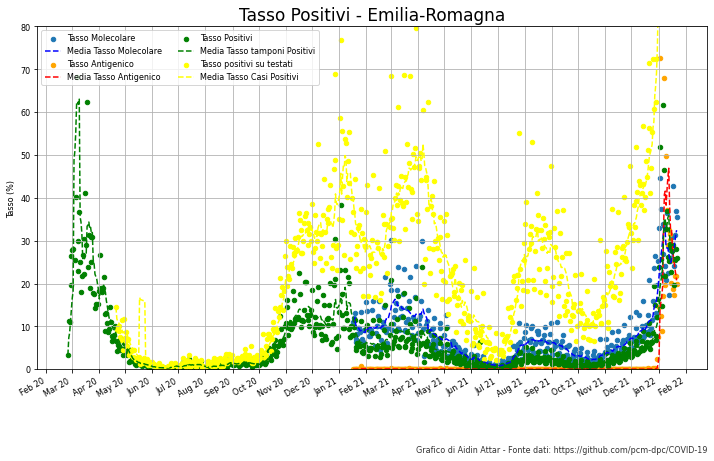

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))

Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='tasso_molecolare',
                               kind='scatter', label='Tasso Molecolare',  color='C0')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_tasso_molecolare'],
        color = 'blue', label = 'Media Tasso Molecolare', linestyle='dashed')
Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='tasso_antigenico_rapido',
                               kind='scatter', label='Tasso Antigenico',  color='orange')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_tasso_antigenico_rapido'],
        color = 'red', label = 'Media Tasso Antigenico', linestyle='dashed')
Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='tasso_positivi',
                               kind='scatter', label='Tasso Positivi',  color='green')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_tasso_positivi'],
        color = 'green', label = 'Media Tasso tamponi Positivi', linestyle='dashed')
Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='tasso_casi',
                               kind='scatter', label='Tasso positivi su testati',  color='yellow')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_tasso_casi'],
        color = 'yellow', label = 'Media Tasso Casi Positivi', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Tasso Positivi - Emilia-Romagna', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Tasso (%)')
ax.set_ylim([0,80])
ax.set_xlabel("")
ax.legend(loc='best', ncol=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

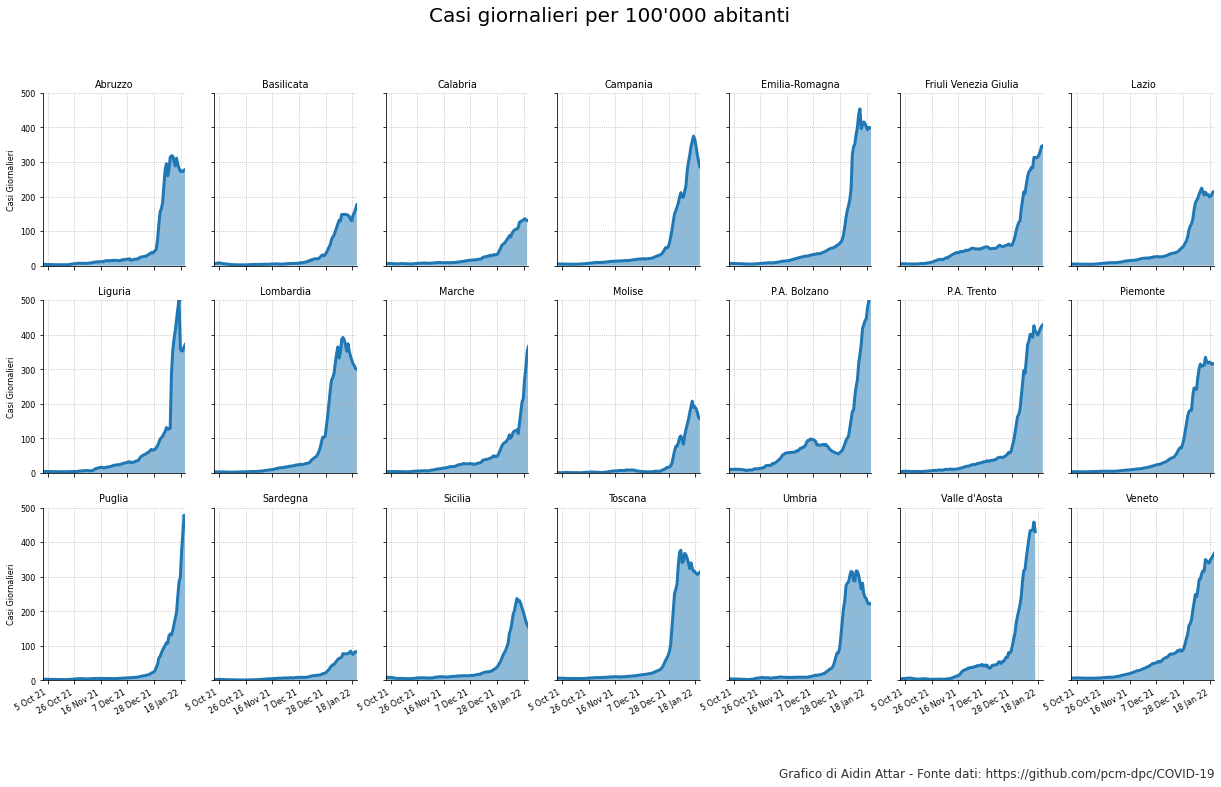

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_casi_giorn_norm'],c='C0', lw=3)
    #ax[y,x].plot(Regioni[key]['data'], Regioni[key]['media_morti_giorn_norm'],c='orange')
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].fill_between(Regioni[key].data, Regioni[key]['media_casi_giorn_norm'], facecolor="C0", alpha=0.5)
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Casi Giornalieri')
ax[1,0].set_ylabel('Casi Giornalieri')
ax[2,0].set_ylabel('Casi Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Casi giornalieri per 100'000 abitanti", fontsize=20)
ax[0,0].set_ylim(bottom=0, top=500)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

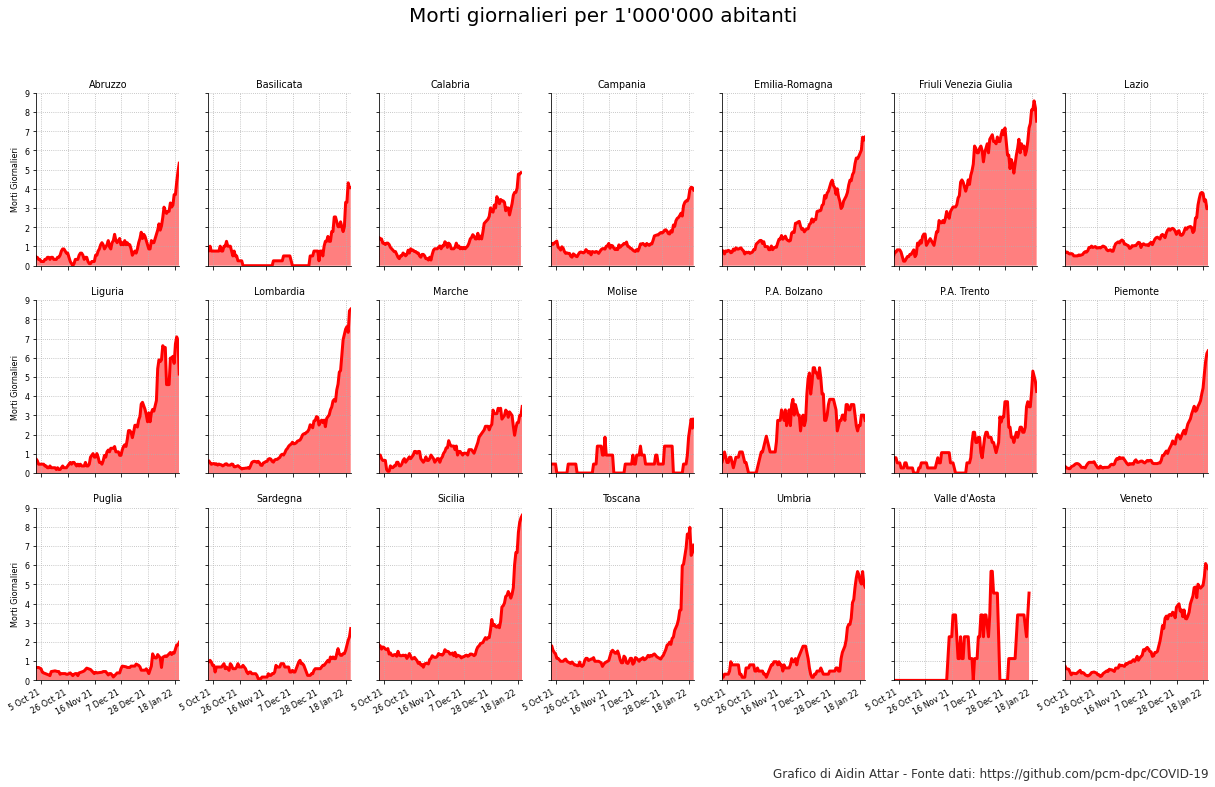

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_morti_giorn_norm']*10,c='red', lw=3)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].fill_between(Regioni[key].data, Regioni[key]['media_morti_giorn_norm']*10, facecolor="red", alpha=0.5)
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Morti Giornalieri')
ax[1,0].set_ylabel('Morti Giornalieri')
ax[2,0].set_ylabel('Morti Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Morti giornalieri per 1'000'000 abitanti", fontsize=20)
ax[0,0].set_ylim(bottom=0, top=9)
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

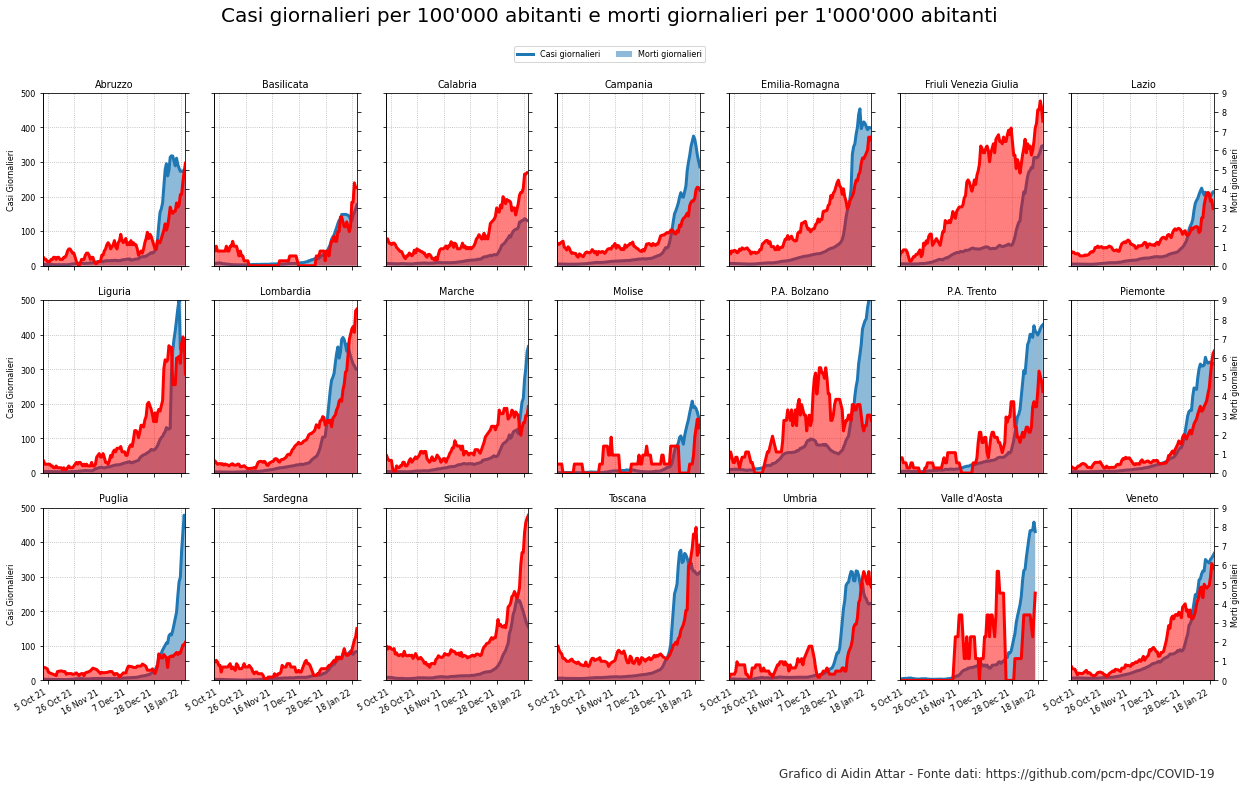

In [26]:
'''
Attenzione!!!
Da sistemare il sharey sull'asse secondario
'''


fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_casi_giorn_norm'],c='C0', lw=3)
    ax[y,x].fill_between(Regioni[key].data, Regioni[key]['media_casi_giorn_norm'], facecolor="C0", alpha=0.5)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    #ax[y,x].spines['right'].set_visible(False)
    #ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))

    ax2 = ax[y,x].twinx()
    ax2.plot(Regioni[key].data, Regioni[key]['media_morti_giorn_norm']*10,c='red', lw=3)
    ax2.fill_between(Regioni[key].data, Regioni[key]['media_morti_giorn_norm']*10, facecolor="red", alpha=0.5)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim(bottom=0,top=9)
    if x!=6:
        ax2.set_yticklabels([])

    if x==6:
        ax2.set_ylabel('Morti giornalieri')

    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Casi Giornalieri')
ax[1,0].set_ylabel('Casi Giornalieri')
ax[2,0].set_ylabel('Casi Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Casi giornalieri per 100'000 abitanti e morti giornalieri per 1'000'000 abitanti", fontsize=20)
ax[0,0].set_ylim(bottom=0, top=500)
#fig.tight_layout()
labels = ['Casi giornalieri', 'Morti giornalieri']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

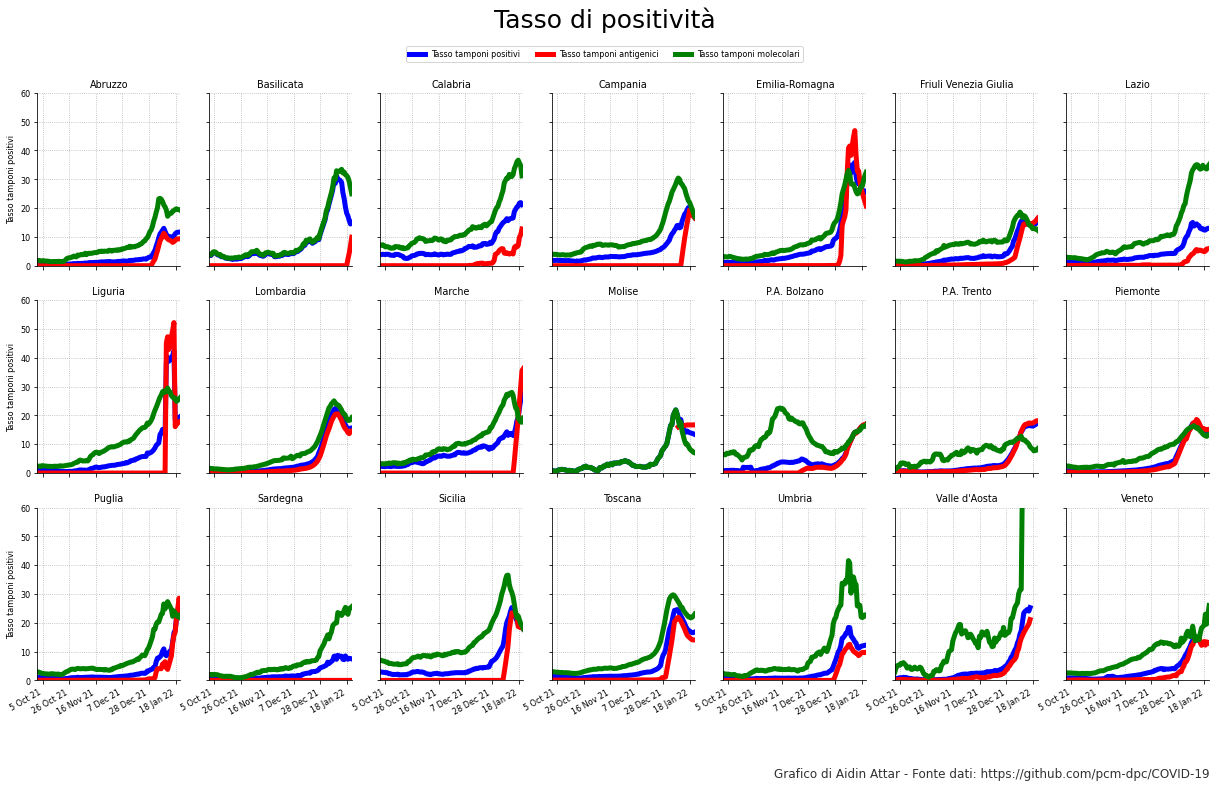

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    #ax[y,x].plot(Regioni[key]['data'], Regioni[key]['media_casi_giorn_norm'],c='C0', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tasso_positivi'],c='blue', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tasso_antigenico_rapido'],c='red', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tasso_molecolare'],c='green', lw=5)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Tasso tamponi positivi')
ax[1,0].set_ylabel('Tasso tamponi positivi')
ax[2,0].set_ylabel('Tasso tamponi positivi')
fig.autofmt_xdate()
fig.suptitle("Tasso di positività", fontsize=25)
ax[0,0].set_ylim(bottom=0, top=60)

labels = ['Tasso tamponi positivi', 'Tasso tamponi antigenici', 'Tasso tamponi molecolari']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

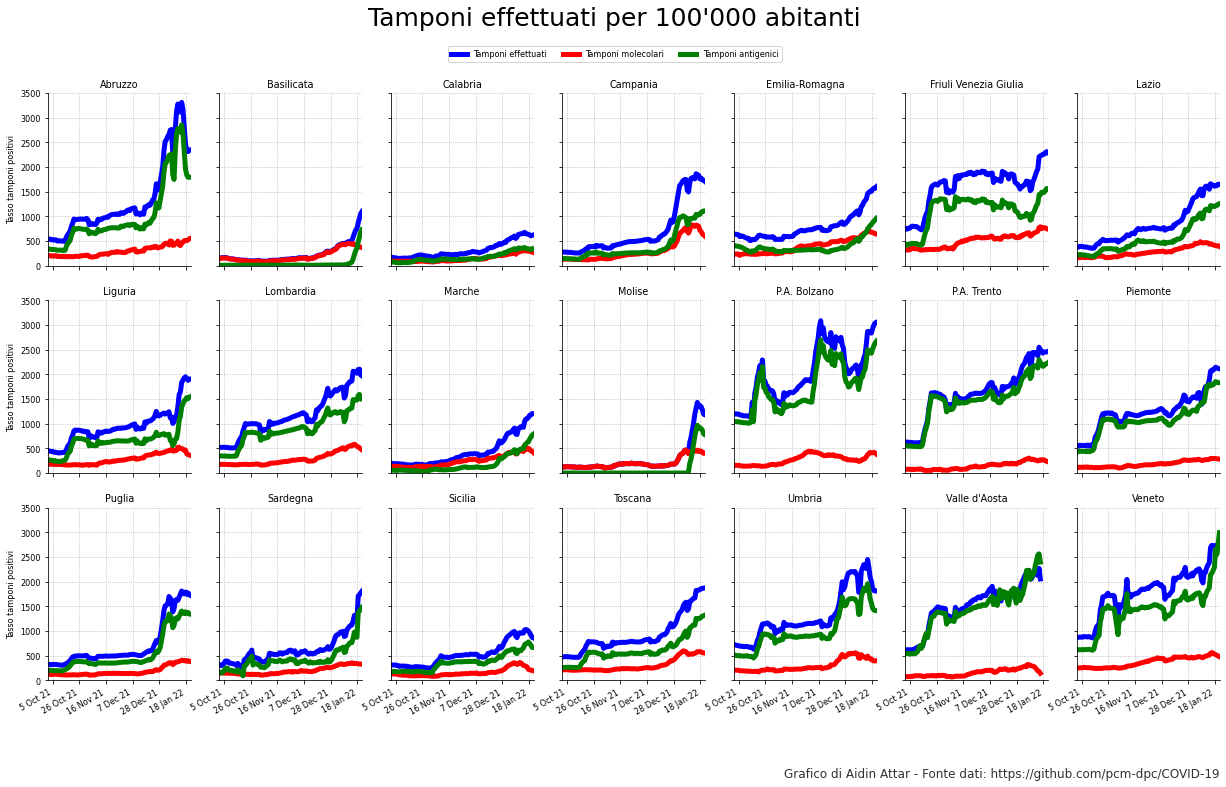

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tamponi_giorn_norm'],c='blue', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tamponi_test_molecolare_giorn_norm'],c='red', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_test_antigenico_rapido_giorn_norm'],c='green', lw=5)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Tasso tamponi positivi')
ax[1,0].set_ylabel('Tasso tamponi positivi')
ax[2,0].set_ylabel('Tasso tamponi positivi')
ax[0,0].set_ylim(bottom=0)
fig.autofmt_xdate()
fig.suptitle("Tamponi effettuati per 100'000 abitanti", fontsize=25)

labels = ['Tamponi effettuati', 'Tamponi molecolari', 'Tamponi antigenici']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

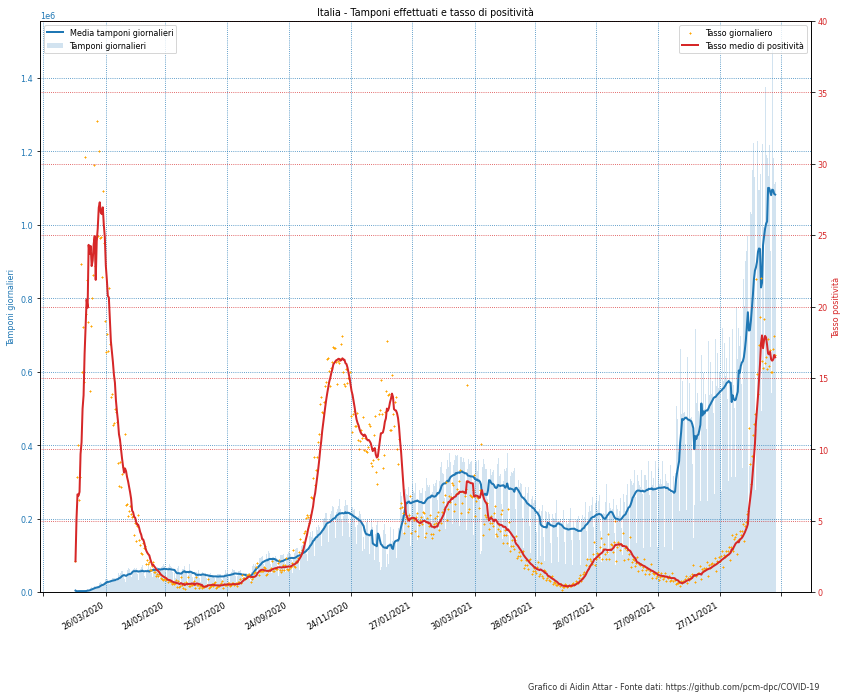

In [29]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.bar(italia.index, italia.tamponi_giornalieri,
        color='C0', width=1, label='Tamponi giornalieri', alpha=0.2)
ax1.plot(italia.index, italia.media_tamponi,
         color=color, label = 'Media tamponi giornalieri', lw = 2)

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Italia - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.scatter(x=italia.index, y=italia.tasso_positivi,
            color = 'orange', s = 1, marker = 'x', label = 'Tasso giornaliero')
ax2.plot(italia.index, italia.media_tasso_positivi,
         color = color, linewidth = 2, label = 'Tasso medio di positività')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0,top=40)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

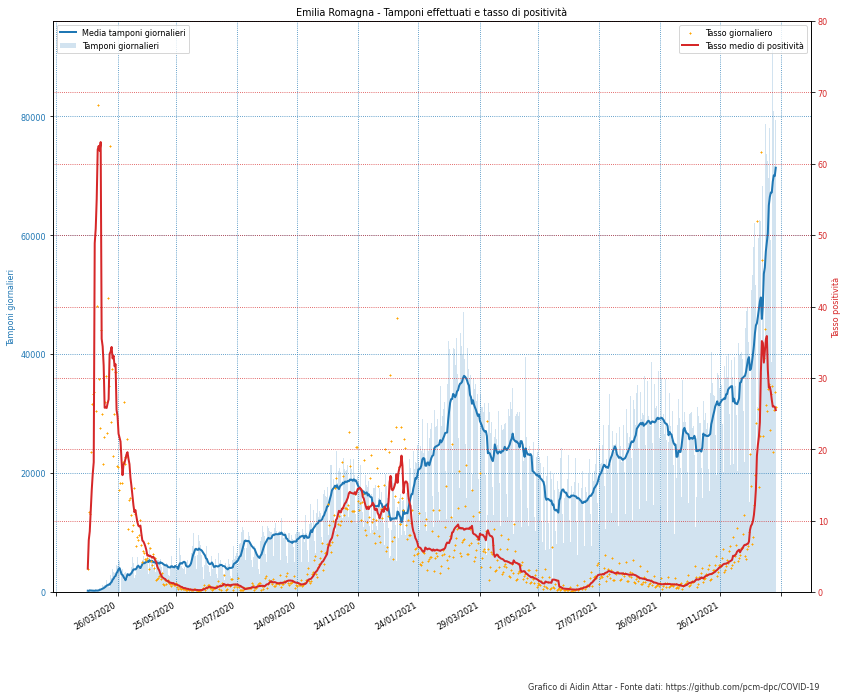

In [30]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.bar(Regioni['Emilia-Romagna'].index, Regioni['Emilia-Romagna'].tamponi_giornalieri,
        color='C0', width=1, label='Tamponi giornalieri', alpha=0.2)
ax1.plot(Regioni['Emilia-Romagna'].index, Regioni['Emilia-Romagna'].media_tamponi,
         color=color, label = 'Media tamponi giornalieri', lw=2)

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Emilia Romagna - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.scatter(x=Regioni['Emilia-Romagna'].index, y=Regioni['Emilia-Romagna'].tasso_positivi,
            color = 'orange', s = 1, marker = 'x', label = 'Tasso giornaliero')
ax2.plot(Regioni['Emilia-Romagna'].index, Regioni['Emilia-Romagna'].media_tasso_positivi,
         color = color, linewidth = 2, label = 'Tasso medio di positività')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

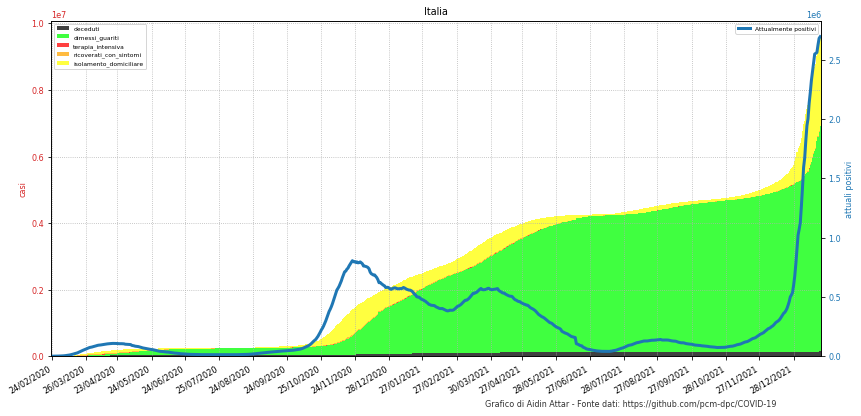

In [31]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
italia[['deceduti',
        'dimessi_guariti',
        'terapia_intensiva',
        'ricoverati_con_sintomi',
        'isolamento_domiciliare']].plot.bar(ax=ax1, width = 1,stacked = True,
                                            color = ['black', 'lime', 'red', 'orange', 'yellow'],
                                            label = ['Decessi', 'Dimessi guariti', 'Terapie intensive', 'Ricoverati con sintomi', 'Isolamento domiciliare'],
                                            alpha = 0.75,
                                            xlabel='')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('casi', color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
italia.plot(ax = ax2, y='totale_positivi',
         kind = 'line',title = "Italia",
         xlabel = '',  color=color,
         linewidth = 3, label = 'Attualmente positivi')

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('attuali positivi', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.rcParams['font.size'] = '8'
plt.text(0.9, 0.07, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left', prop={'size': 6})
ax2.legend(loc='upper right',prop={'size': 6})
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

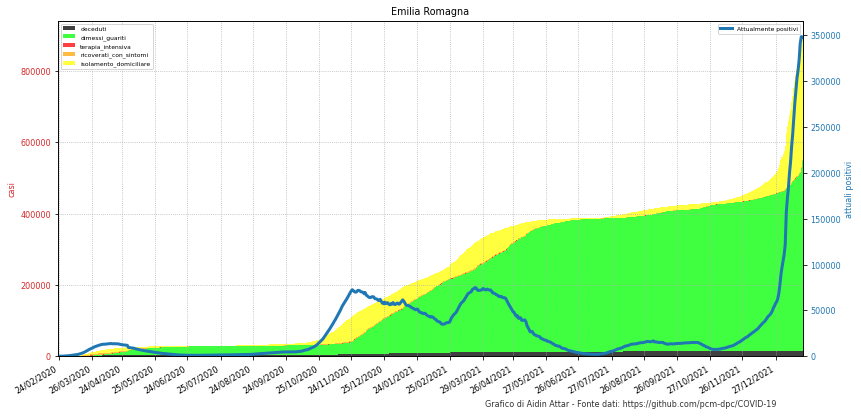

In [32]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
Regioni['Emilia-Romagna'][['deceduti',
                           'dimessi_guariti',
                           'terapia_intensiva',
                           'ricoverati_con_sintomi',
                           'isolamento_domiciliare']].plot.bar(ax=ax1, width = 1,stacked = True,
                                                               color = ['black', 'lime', 'red', 'orange', 'yellow'],
                                                               label = ['Decessi', 'Dimessi guariti', 'Terapie intensive', 'Ricoverati con sintomi', 'Isolamento domiciliare'],
                                                               alpha = 0.75,
                                                               xlabel='')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('casi', color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
Regioni['Emilia-Romagna'].plot(ax = ax2, y='totale_positivi',
         kind = 'line',title = "Emilia Romagna",
         xlabel = '',  color=color,
         linewidth = 3, label = 'Attualmente positivi')

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('attuali positivi', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.rcParams['font.size'] = '8'
plt.text(0.9, 0.07, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left', prop={'size': 6})
ax2.legend(loc='upper right',prop={'size': 6})
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [33]:
'''
italia['incremento_casi_giornalieri']        = italia['casi_giornalieri']  / italia['casi_giornalieri' ].shift(7)
italia['incremento_morti_giornalieri']       = italia['morti_giornalieri'] / italia['morti_giornalieri'].shift(7)
italia['media_incremento_casi_giornalieri']  = italia['incremento_casi_giornalieri' ].rolling(window=20, min_periods=1).mean()
italia['media_incremento_morti_giornalieri'] = italia['incremento_morti_giornalieri'].rolling(window=20, min_periods=1).mean()

for key in Regioni.keys():
    Regioni[key]['incremento_casi_giornalieri']        = Regioni[key]['casi_giornalieri']  / Regioni[key]['casi_giornalieri' ].shift(7)
    Regioni[key]['incremento_morti_giornalieri']       = Regioni[key]['morti_giornalieri'] / Regioni[key]['morti_giornalieri'].shift(7)
    Regioni[key]['media_incremento_casi_giornalieri']  = Regioni[key]['incremento_casi_giornalieri' ].rolling(window=30, min_periods=1).mean()
    Regioni[key]['media_incremento_morti_giornalieri'] = Regioni[key]['incremento_morti_giornalieri'].rolling(window=30, min_periods=1).mean()

'''
italia[                'incremento_casi_giornalieri'] = italia[                    'media_casi_giorn'] / italia[ 'media_casi_giorn'].shift(7)
italia[               'incremento_morti_giornalieri'] = italia[                   'media_morti_giorn'] / italia['media_morti_giorn'].shift(7)
italia[          'media_incremento_casi_giornalieri'] = italia[        'incremento_casi_giornalieri' ].rolling(window=5, min_periods=1).mean()
italia[         'media_incremento_morti_giornalieri'] = italia[        'incremento_morti_giornalieri'].rolling(window=5, min_periods=1).mean()
italia[            'std_incremento_casi_giornalieri'] = italia[        'incremento_casi_giornalieri' ].rolling(window=5, min_periods=1).std()
italia[           'std_incremento_morti_giornalieri'] = italia[        'incremento_morti_giornalieri'].rolling(window=5, min_periods=1).std()

'''
italia[                   'variazione_ospedalizzati'] = italia[                'totale_ospedalizzati'] - italia[  'totale_ospedalizzati'].shift(1)
italia[                      'variazione_ricoverati'] = italia[              'ricoverati_con_sintomi'] - italia['ricoverati_con_sintomi'].shift(1)
italia[               'variazione_terapie_intensive'] = italia[                   'terapia_intensiva'] - italia[     'terapia_intensiva'].shift(1)

italia[             'media_variazione_ospedalizzati'] = italia[                'totale_ospedalizzati'].rolling(window=5, min_periods=1).mean()
italia[                'media_variazione_ricoverati'] = italia[              'ricoverati_con_sintomi'].rolling(window=5, min_periods=1).mean()
italia[         'media_variazione_terapie_intensive'] = italia[                   'terapia_intensiva'].rolling(window=5, min_periods=1).mean()
italia[               'std_variazione_ospedalizzati'] = italia[                'totale_ospedalizzati'].rolling(window=5, min_periods=1).std()
italia[                  'std_variazione_ricoverati'] = italia[              'ricoverati_con_sintomi'].rolling(window=5, min_periods=1).std()
italia[           'std_variazione_terapie_intensive'] = italia[                   'terapia_intensiva'].rolling(window=5, min_periods=1).std()
'''

italia[                   'incremento_ospedalizzati'] = italia[                'totale_ospedalizzati'] / italia[        'totale_ospedalizzati'].shift(7)
italia[                      'incremento_ricoverati'] = italia[              'ricoverati_con_sintomi'] / italia[      'ricoverati_con_sintomi'].shift(7)
italia[               'incremento_terapie_intensive'] = italia[                   'terapia_intensiva'] / italia[           'terapia_intensiva'].shift(7)
italia[      'incremento_ingressi_terapia_intensiva'] = italia[    'media_ingressi_terapia_intensiva'] / italia[  'media_ingressi_terapia_intensiva'].shift(7)

italia[             'media_incremento_ospedalizzati'] = italia[            'incremento_ospedalizzati'].rolling(window=5, min_periods=1).mean()
italia[                'media_incremento_ricoverati'] = italia[               'incremento_ricoverati'].rolling(window=5, min_periods=1).mean()
italia[         'media_incremento_terapie_intensive'] = italia[        'incremento_terapie_intensive'].rolling(window=5, min_periods=1).mean()
italia['media_incremento_ingressi_terapia_intensiva'] = italia['incremento_ingressi_terapia_intensiva'].rolling(window=5, min_periods=1).mean()
italia[               'std_incremento_ospedalizzati'] = italia[            'incremento_ospedalizzati'].rolling(window=5, min_periods=1).std()
italia[                  'std_incremento_ricoverati'] = italia[               'incremento_ricoverati'].rolling(window=5, min_periods=1).std()
italia[           'std_incremento_terapie_intensive'] = italia[        'incremento_terapie_intensive'].rolling(window=5, min_periods=1).std()
italia[  'std_incremento_ingressi_terapia_intensiva'] = italia['incremento_ingressi_terapia_intensiva'].rolling(window=5, min_periods=1).std()


for key in Regioni.keys():
    Regioni[key][       'incremento_casi_giornalieri'] = Regioni[key][            'media_casi_giorn'] / Regioni[key][ 'media_casi_giorn'].shift(7)
    Regioni[key][      'incremento_morti_giornalieri'] = Regioni[key][           'media_morti_giorn'] / Regioni[key]['media_morti_giorn'].shift(7)
    Regioni[key][ 'media_incremento_casi_giornalieri'] = Regioni[key]['incremento_casi_giornalieri' ].rolling(window=5, min_periods=1).mean()
    Regioni[key]['media_incremento_morti_giornalieri'] = Regioni[key]['incremento_morti_giornalieri'].rolling(window=5, min_periods=1).mean()


italia

data stato  ricoverati_con_sintomi  \
24/02/2020 2020-02-24 18:00:00   ITA                     101   
25/02/2020 2020-02-25 18:00:00   ITA                     114   
26/02/2020 2020-02-26 18:00:00   ITA                     128   
27/02/2020 2020-02-27 18:00:00   ITA                     248   
28/02/2020 2020-02-28 18:00:00   ITA                     345   
...                        ...   ...                     ...   
17/01/2022 2022-01-17 17:00:00   ITA                   19228   
18/01/2022 2022-01-18 17:00:00   ITA                   19448   
19/01/2022 2022-01-19 17:00:00   ITA                   19500   
20/01/2022 2022-01-20 17:00:00   ITA                   19659   
21/01/2022 2022-01-21 17:00:00   ITA                   19485   

            terapia_intensiva  totale_ospedalizzati  isolamento_domiciliare  \
24/02/2020                 26                   127                      94   
25/02/2020                 35                   150                     162   
26/02/2020                 36                   164                     221   
27/02/2020                 56                   304                     284   
28/02/2020                 64                   409                     412   
...                       ...                   ...                     ...   
17/01/2022               1717                 20945                 2534333   
18/01/2022               1715                 21163                 2540993   
19/01/2022               1688                 21188                 2605402   
20/01/2022               1698                 21357                 2660684   
21/01/2022               1707                 21192                 2674511   

            totale_positivi  variazione_totale_positivi  nuovi_positivi  \
24/02/2020              221                           0             221   
25/02/2020              311                          90              93   
26/02/2020              385                          74              78   
27/02/2020              588                         203             250   
28/02/2020              821                         233             238   
...                     ...                         ...             ...   
17/01/2022          2555278                        6421           83403   
18/01/2022          2562156                        6878          212004   
19/01/2022          2626590                       64434          192320   
20/01/2022          2682041                       55451          188797   
21/01/2022          2695703                       13662          179106   

            dimessi_guariti  ...  incremento_terapie_intensive  \
24/02/2020                1  ...                           NaN   
25/02/2020                1  ...                           NaN   
26/02/2020                3  ...                           NaN   
27/02/2020               45  ...                           NaN   
28/02/2020               46  ...                           NaN   
...                     ...  ...                           ...   
17/01/2022          6093633  ...                      1.069116   
18/01/2022          6314444  ...                      1.022660   
19/01/2022          6450596  ...                      1.011384   
20/01/2022          6593625  ...                      1.017986   
21/01/2022          6765190  ...                      1.016677   

            incremento_ingressi_terapia_intensiva  \
24/02/2020                                    NaN   
25/02/2020                                    NaN   
26/02/2020                                    NaN   
27/02/2020                                    NaN   
28/02/2020                                    NaN   
...                                           ...   
17/01/2022                               1.032258   
18/01/2022                               0.965820   
19/01/2022                               0.922710   
20/01/2022                               0.940604   
21/01/2022                     

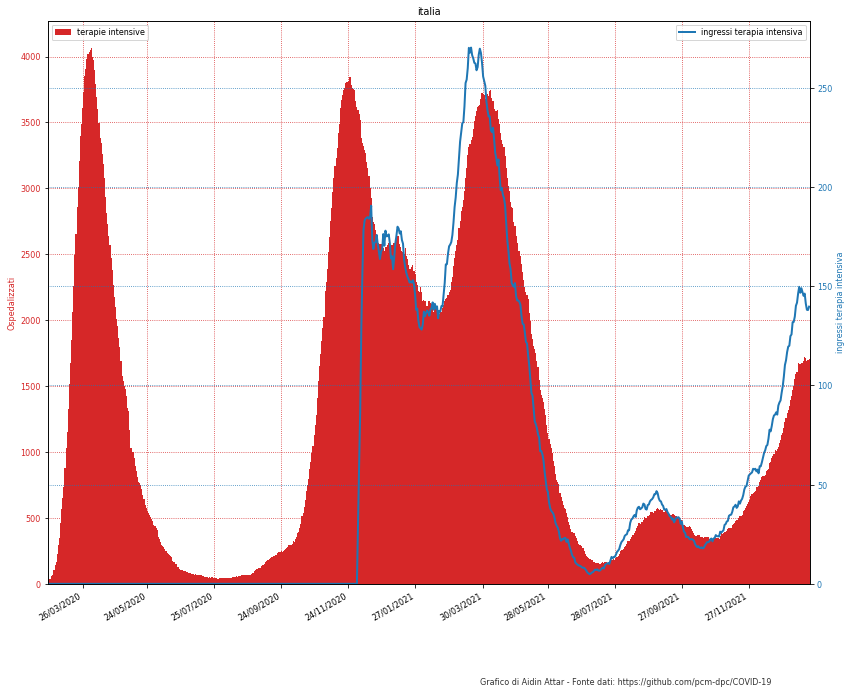

In [34]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:red'
italia.plot(ax = ax1, x ='data', y='terapia_intensiva',
            kind = 'bar',xlabel = '', color = color,
            width = 1, label = 'terapie intensive')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('')
ax1.set_ylabel('Ospedalizzati', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
italia.plot(ax = ax2, y='media_ingressi_terapia_intensiva',
         kind = 'line',title = "italia",
         xlabel = '',  color=color,
         linewidth = 2, label = 'ingressi terapia intensiva')

fig.autofmt_xdate()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_xlabel('')
ax2.grid(linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('ingressi terapia intensiva', color=color)  # we already handled the x-label with ax1
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.rcParams['font.size'] = '12'
ax2.set_ylim(bottom = 0)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

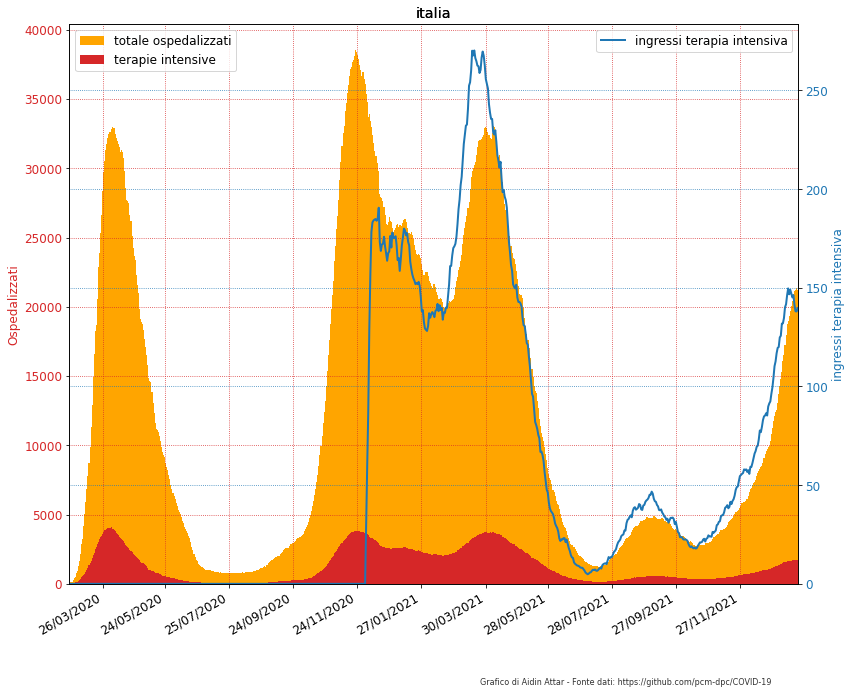

In [35]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:red'
italia.plot(ax = ax1, x ='data', y='totale_ospedalizzati',
            kind = 'bar', title = "italia", xlabel = '',
            color = 'orange', width = 1, label = 'totale ospedalizzati')
italia.plot(ax = ax1, x ='data', y='terapia_intensiva',
            kind = 'bar',xlabel = '', color = color,
            width = 1, label = 'terapie intensive')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('')
ax1.set_ylabel('Ospedalizzati', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
italia.plot(ax = ax2, y='media_ingressi_terapia_intensiva',
         kind = 'line',title = "italia",
         xlabel = '',  color=color,
         linewidth = 2, label = 'ingressi terapia intensiva')

fig.autofmt_xdate()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_xlabel('')
ax2.grid(linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('ingressi terapia intensiva', color=color)  # we already handled the x-label with ax1
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.rcParams['font.size'] = '12'
ax2.set_ylim(bottom = 0)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

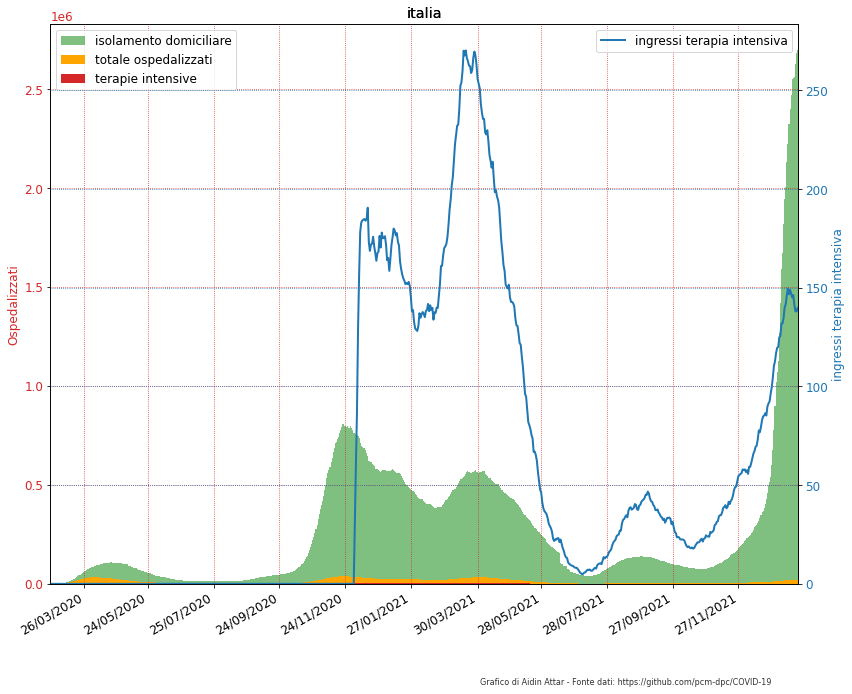

In [36]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:red'
italia.plot(ax = ax1, x ='data', y='totale_positivi',
            kind = 'bar',xlabel = '', color = 'green', alpha=0.5,
            width = 1, label = 'isolamento domiciliare')
italia.plot(ax = ax1, x ='data', y='totale_ospedalizzati',
            kind = 'bar', title = "italia", xlabel = '',
            color = 'orange', width = 1, label = 'totale ospedalizzati')
italia.plot(ax = ax1, x ='data', y='terapia_intensiva',
            kind = 'bar',xlabel = '', color = color,
            width = 1, label = 'terapie intensive')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('')
ax1.set_ylabel('Ospedalizzati', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
italia.plot(ax = ax2, y='media_ingressi_terapia_intensiva',
         kind = 'line',title = "italia",
         xlabel = '',  color=color,
         linewidth = 2, label = 'ingressi terapia intensiva')

fig.autofmt_xdate()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_xlabel('')
ax2.grid(linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('ingressi terapia intensiva', color=color)  # we already handled the x-label with ax1
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.rcParams['font.size'] = '12'
ax2.set_ylim(bottom = 0)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [37]:
italia[      'letalità'] = italia['morti_giornalieri'] / italia['casi_giornalieri'].shift(14) * 100
italia['media_letalità'] = italia['media_morti_giorn'] / italia['media_casi_giorn'].shift(14) * 100
italia['letalità_terapia_intensiva'] = italia['morti_giornalieri'] / italia['ingressi_terapia_intensiva'].shift(14) * 100
italia['media_letalità_terapia_intensiva'] = italia['media_morti_giorn'] / italia['media_ingressi_terapia_intensiva'].shift(14) * 100

italia

data stato  ricoverati_con_sintomi  \
24/02/2020 2020-02-24 18:00:00   ITA                     101   
25/02/2020 2020-02-25 18:00:00   ITA                     114   
26/02/2020 2020-02-26 18:00:00   ITA                     128   
27/02/2020 2020-02-27 18:00:00   ITA                     248   
28/02/2020 2020-02-28 18:00:00   ITA                     345   
...                        ...   ...                     ...   
17/01/2022 2022-01-17 17:00:00   ITA                   19228   
18/01/2022 2022-01-18 17:00:00   ITA                   19448   
19/01/2022 2022-01-19 17:00:00   ITA                   19500   
20/01/2022 2022-01-20 17:00:00   ITA                   19659   
21/01/2022 2022-01-21 17:00:00   ITA                   19485   

            terapia_intensiva  totale_ospedalizzati  isolamento_domiciliare  \
24/02/2020                 26                   127                      94   
25/02/2020                 35                   150                     162   
26/02/2020                 36                   164                     221   
27/02/2020                 56                   304                     284   
28/02/2020                 64                   409                     412   
...                       ...                   ...                     ...   
17/01/2022               1717                 20945                 2534333   
18/01/2022               1715                 21163                 2540993   
19/01/2022               1688                 21188                 2605402   
20/01/2022               1698                 21357                 2660684   
21/01/2022               1707                 21192                 2674511   

            totale_positivi  variazione_totale_positivi  nuovi_positivi  \
24/02/2020              221                           0             221   
25/02/2020              311                          90              93   
26/02/2020              385                          74              78   
27/02/2020              588                         203             250   
28/02/2020              821                         233             238   
...                     ...                         ...             ...   
17/01/2022          2555278                        6421           83403   
18/01/2022          2562156                        6878          212004   
19/01/2022          2626590                       64434          192320   
20/01/2022          2682041                       55451          188797   
21/01/2022          2695703                       13662          179106   

            dimessi_guariti  ...  media_incremento_terapie_intensive  \
24/02/2020                1  ...                                 NaN   
25/02/2020                1  ...                                 NaN   
26/02/2020                3  ...                                 NaN   
27/02/2020               45  ...                                 NaN   
28/02/2020               46  ...                                 NaN   
...                     ...  ...                                 ...   
17/01/2022          6093633  ...                            1.092694   
18/01/2022          6314444  ...                            1.069823   
19/01/2022          6450596  ...                            1.048084   
20/01/2022          6593625  ...                            1.036267   
21/01/2022          6765190  ...                            1.027564   

            media_incremento_ingressi_terapia_intensiva  \
24/02/2020                                          NaN   
25/02/2020                                          NaN   
26/02/2020                                          NaN   
27/02/2020                                          NaN   
28/02/2020                                          NaN   
...                                                 ...   
17/01/2022                                     1.080332   
18/01/2022                                     1.050961   
19/01/2022 

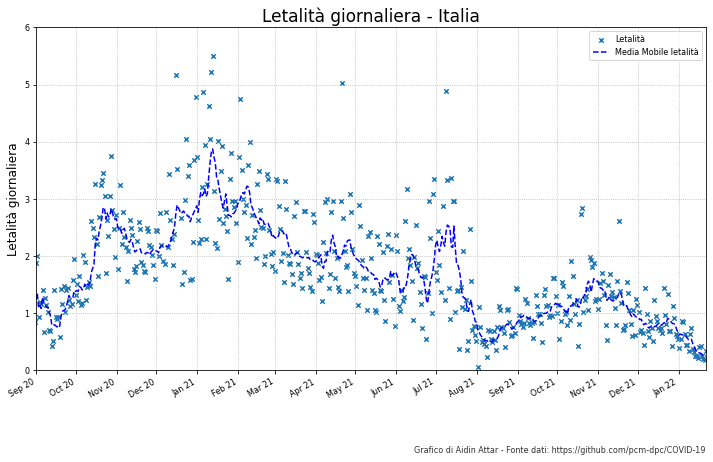

In [38]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='letalità',
            kind='scatter', marker = 'x', label='Letalità',  color='C0')
ax.plot(italia['data'], italia['media_letalità'],
        color = 'blue', label = 'Media Mobile letalità', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlim([date(2020, 9, 1), today])
ax.set_ylim(top = 6, bottom=0)
ax.set_title('Letalità giornaliera - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Letalità giornaliera')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

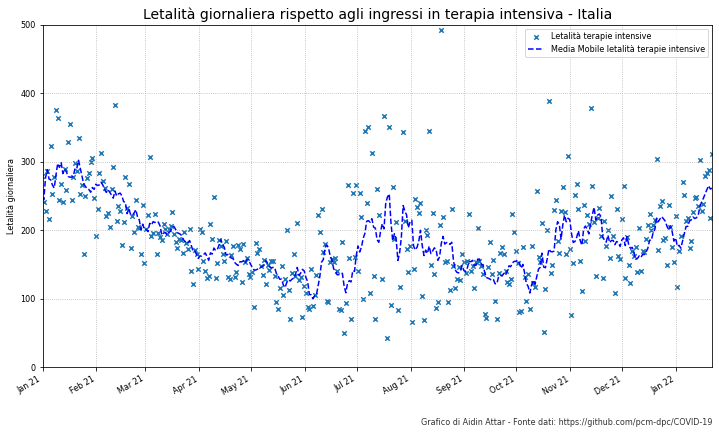

In [39]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='letalità_terapia_intensiva',
            kind='scatter', marker = 'x', label='Letalità terapie intensive',  color='C0')
ax.plot(italia['data'], italia['media_letalità_terapia_intensiva'],
        color = 'blue', label = 'Media Mobile letalità terapie intensive', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlim([date(2021, 1, 1), today])
ax.set_ylim(top = 500, bottom=0)
ax.set_title('Letalità giornaliera rispetto agli ingressi in terapia intensiva - Italia', fontsize=14)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Letalità giornaliera')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

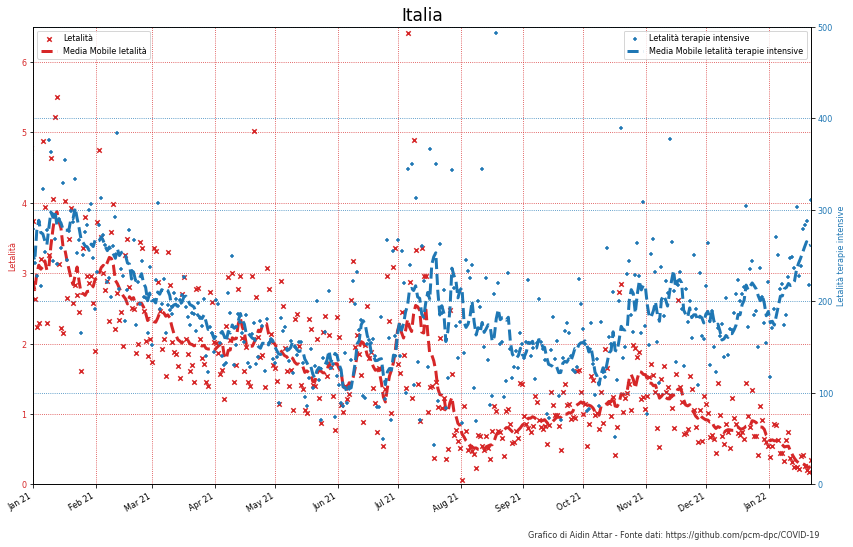

In [40]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
italia.plot(ax=ax1, x ='data', y='letalità',
            kind='scatter', marker = 'x', label='Letalità',  color=color)
ax1.plot(italia['data'], italia['media_letalità'], linewidth=3,
        color = color, label = 'Media Mobile letalità', linestyle='dashed')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Letalità', color=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'

italia.plot(ax=ax2, x ='data', y='letalità_terapia_intensiva',
            kind='scatter', marker = '+', label='Letalità terapie intensive',  color=color)
ax2.plot(italia['data'], italia['media_letalità_terapia_intensiva'], linewidth=3.,
         color = color, label = 'Media Mobile letalità terapie intensive', linestyle='dashed')

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_title('Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax1.set_xlabel('')
ax2.set_ylabel('Letalità terapie intensive', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.legend(loc='upper right')

ax2.grid(linestyle='dotted', color=color)

ax1.set_xlim([date(2021, 1, 1), today])
ax2.set_ylim(top = 500, bottom=0)
ax1.set_ylim(top = 6.5, bottom=0)

plt.text(0.95, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


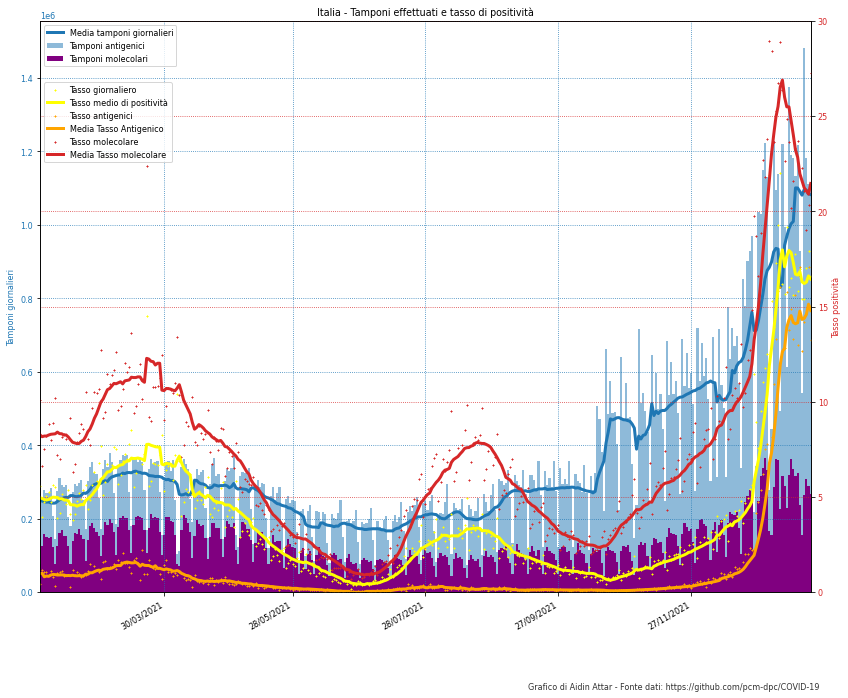

In [41]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.bar(italia.index, italia.tamponi_giornalieri,
        color='C0', width=1, label='Tamponi antigenici', alpha=0.5)
ax1.bar(italia.index, italia.tamponi_test_molecolare_giorn,
        color='purple', width=1, label='Tamponi molecolari', alpha=1)
ax1.plot(italia.index, italia.media_tamponi, lw=3,
         color=color, label = 'Media tamponi giornalieri')

ax1.set_xlim([date(2021, 2, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Italia - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.scatter(x=italia.index, y=italia.tasso_positivi,
            color = 'yellow', s = 1, marker = 'x', label = 'Tasso giornaliero')
ax2.plot(italia.index, italia.media_tasso_positivi,
         color = 'yellow', linewidth = 3, label = 'Tasso medio di positività')
ax2.scatter(x=italia.index, y=italia.tasso_antigenico_rapido,
            color = 'orange', s = 1, marker = 'x', label = 'Tasso antigenici')
ax2.plot(italia.index, italia.media_tasso_antigenico_rapido,
         color = 'orange', linewidth = 3, label = 'Media Tasso Antigenico')
ax2.scatter(x=italia.index, y=italia.tasso_molecolare,
            color = color, s = 1, marker = 'x', label = 'Tasso molecolare')
ax2.plot(italia.index, italia.media_tasso_molecolare,
         color = color, linewidth = 3, label = 'Media Tasso molecolare')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=0, top=30)
ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax1.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

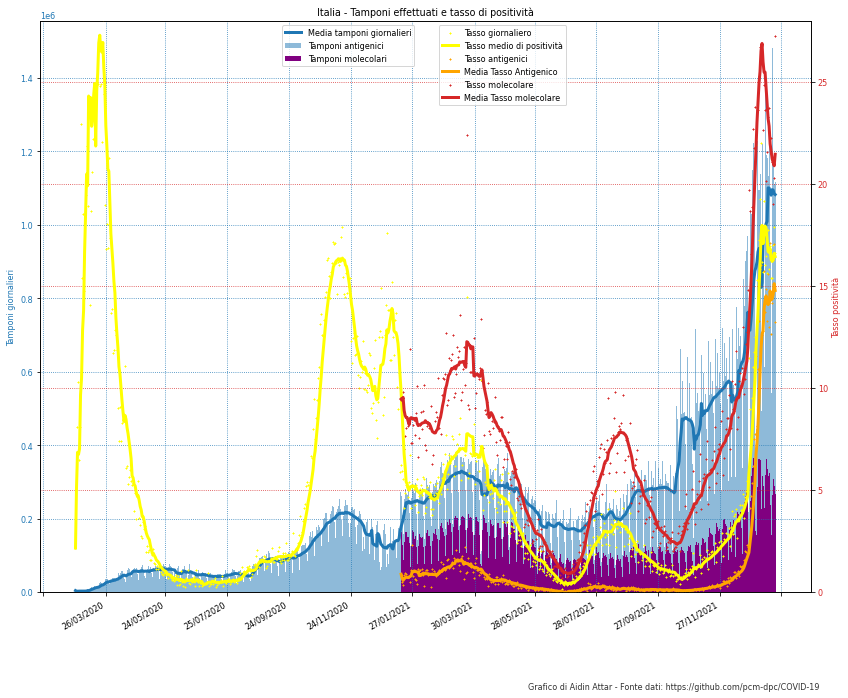

In [42]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.bar(italia.index, italia.tamponi_giornalieri,
        color='C0', width=1, label='Tamponi antigenici', alpha=0.5)
ax1.bar(italia.index, italia.tamponi_test_molecolare_giorn,
        color='purple', width=1, label='Tamponi molecolari', alpha=1)
ax1.plot(italia.index, italia.media_tamponi, lw=3,
         color=color, label = 'Media tamponi giornalieri')

#ax1.set_xlim([date(2021, 2, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Italia - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.scatter(x=italia.index, y=italia.tasso_positivi,
            color = 'yellow', s = 1, marker = 'x', label = 'Tasso giornaliero')
ax2.plot(italia.index, italia.media_tasso_positivi,
         color = 'yellow', linewidth = 3, label = 'Tasso medio di positività')
ax2.scatter(x=italia.index, y=italia.tasso_antigenico_rapido,
            color = 'orange', s = 1, marker = 'x', label = 'Tasso antigenici')
ax2.plot(italia.index, italia.media_tasso_antigenico_rapido,
         color = 'orange', linewidth = 3, label = 'Media Tasso Antigenico')
ax2.scatter(x=italia.index, y=italia.tasso_molecolare,
            color = color, s = 1, marker = 'x', label = 'Tasso molecolare')
ax2.plot(italia.index, italia.media_tasso_molecolare,
         color = color, linewidth = 3, label = 'Media Tasso molecolare')

fig.autofmt_xdate()

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=0, top=28)
ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper center', bbox_to_anchor=(0.4, 1))
ax2.legend(loc='upper center', bbox_to_anchor=(0.6, 1))
ax1.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [43]:
italy = gpd.read_file('../mappe/italy-with-regions/reg2011_g.shp')
oggi = [Regioni[key].iloc[-2] for key in Regioni.keys()]
cum = pd.DataFrame(oggi)

cum1 = cum.set_index('denominazione_regione')
sum_ = cum1.reindex(['P.A. Trento', 'P.A. Bolzano']).sum().to_frame().transpose()
sum_ = sum_.rename(index={0: 'Trentino-Alto Adige/Sudtirol'})
cum1.drop(['P.A. Trento', 'P.A. Bolzano'],inplace=True)
cum1 = cum1.append(sum_)
cum1 = cum1.sort_index()
italy.sort_values(by = 'NOME_REG', inplace = True)
italy.reset_index(drop=True,       inplace = True)
italy.index = cum1.index

italy = italy.merge(cum1,left_index=True, right_index=True, how='right')
italy.at['Trentino-Alto Adige/Sudtirol',                  'media_morti_giorn_norm'] = italy.at['Trentino-Alto Adige/Sudtirol',                  'media_morti_giorn'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy.at['Trentino-Alto Adige/Sudtirol',                   'media_casi_giorn_norm'] = italy.at['Trentino-Alto Adige/Sudtirol',                   'media_casi_giorn'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy.at['Trentino-Alto Adige/Sudtirol',                      'media_tamponi_norm'] = italy.at['Trentino-Alto Adige/Sudtirol',                      'media_tamponi'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy.at['Trentino-Alto Adige/Sudtirol','media_tamponi_test_molecolare_giorn_norm'] = italy.at['Trentino-Alto Adige/Sudtirol','media_tamponi_test_molecolare_giorn'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy.at['Trentino-Alto Adige/Sudtirol', 'media_test_antigenico_rapido_giorn_norm'] = italy.at['Trentino-Alto Adige/Sudtirol', 'media_test_antigenico_rapido_giorn'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000

/tmp/ipykernel_179320/2219818054.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_ = cum1.reindex(['P.A. Trento', 'P.A. Bolzano']).sum().to_frame().transpose()


Text(0.85, 0.2, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

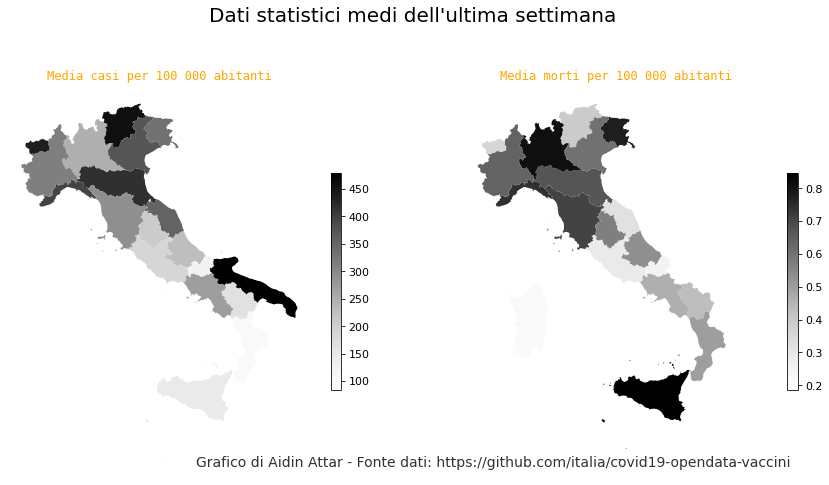

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
col1 = 'media_casi_giorn_norm'
ax[0].set_title('Media casi per 100 000 abitanti',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize1 = mcolors.Normalize(vmin=italy[col1].min(), vmax=italy[col1].max())
scalarmappaple1 = cm.ScalarMappable(norm=normalize1, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[0],
           column=col1,
           cmap="Greys")
plt.axis('off')
cbar = plt.colorbar(scalarmappaple1, ax=ax[0],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col2 = 'media_morti_giorn_norm'
ax[1].set_title('Media morti per 100 000 abitanti',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize2 = mcolors.Normalize(vmin=italy[col2].min(), vmax=italy[col2].max())
scalarmappaple2 = cm.ScalarMappable(norm=normalize2, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[1],
           column=col2,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple2, ax=ax[1],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

ax[0].axis('off')
ax[1].axis('off')
fig.suptitle("Dati statistici medi dell'ultima settimana", fontsize=20)
plt.text(0.85, 0.2, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

In [45]:
metriche_mobile  = pd.read_csv('../metriche/dpc-covid19-ita-metriche-dashboard-mobile.csv')
metriche_desktop = pd.read_csv('../metriche/dpc-covid19-ita-metriche-dashboard-desktop.csv', encoding='latin-1')

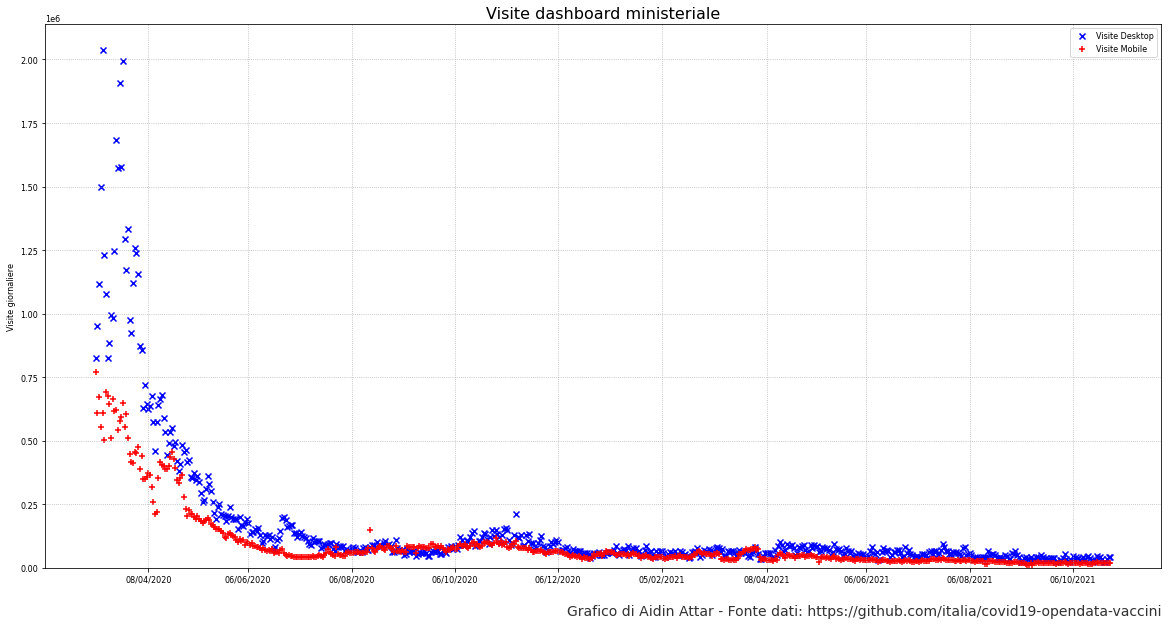

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(metriche_desktop.data, metriche_desktop.totale_visitatori_giorno, label='Visite Desktop', color='blue', marker='x')
ax.scatter(metriche_mobile.data,   metriche_mobile.totale_visitatori_giorno, label= 'Visite Mobile', color= 'red', marker='+')
ax.set_title('Visite dashboard ministeriale', fontsize=16)
ax.set_ylabel('Visite giornaliere')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.grid(linestyle='dotted')
ax.set_ylim(bottom=0)
ax.legend(loc='upper right')
plt.text(0.9, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

Text(0.9, 0.2, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

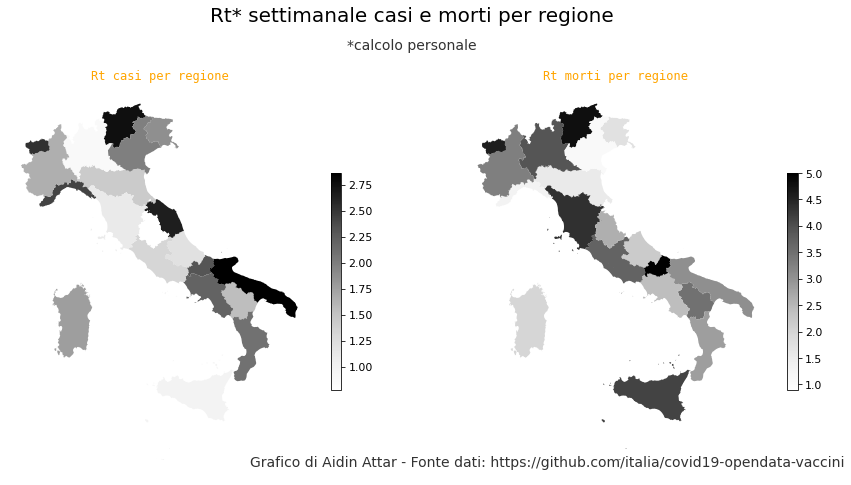

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
col1 = 'media_incremento_casi_giornalieri'
ax[0].set_title('Rt casi per regione',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize1 = mcolors.Normalize(vmin=italy[col1].min(), vmax=italy[col1].max())
scalarmappaple1 = cm.ScalarMappable(norm=normalize1, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[0],
           column=col1,
           cmap="Greys")
plt.axis('off')
cbar = plt.colorbar(scalarmappaple1, ax=ax[0],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col2 = 'media_incremento_morti_giornalieri'
ax[1].set_title('Rt morti per regione',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize2 = mcolors.Normalize(vmin=italy[col2].min(), vmax=italy[col2].max())
scalarmappaple2 = cm.ScalarMappable(norm=normalize2, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[1],
           column=col2,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple2, ax=ax[1],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

ax[0].axis('off')
ax[1].axis('off')
fig.suptitle("Rt* settimanale casi e morti per regione", fontsize=20)
plt.text(0.5, 0.925, '*calcolo personale',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='center', va='top', rotation='0')
plt.text(0.9, 0.2, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

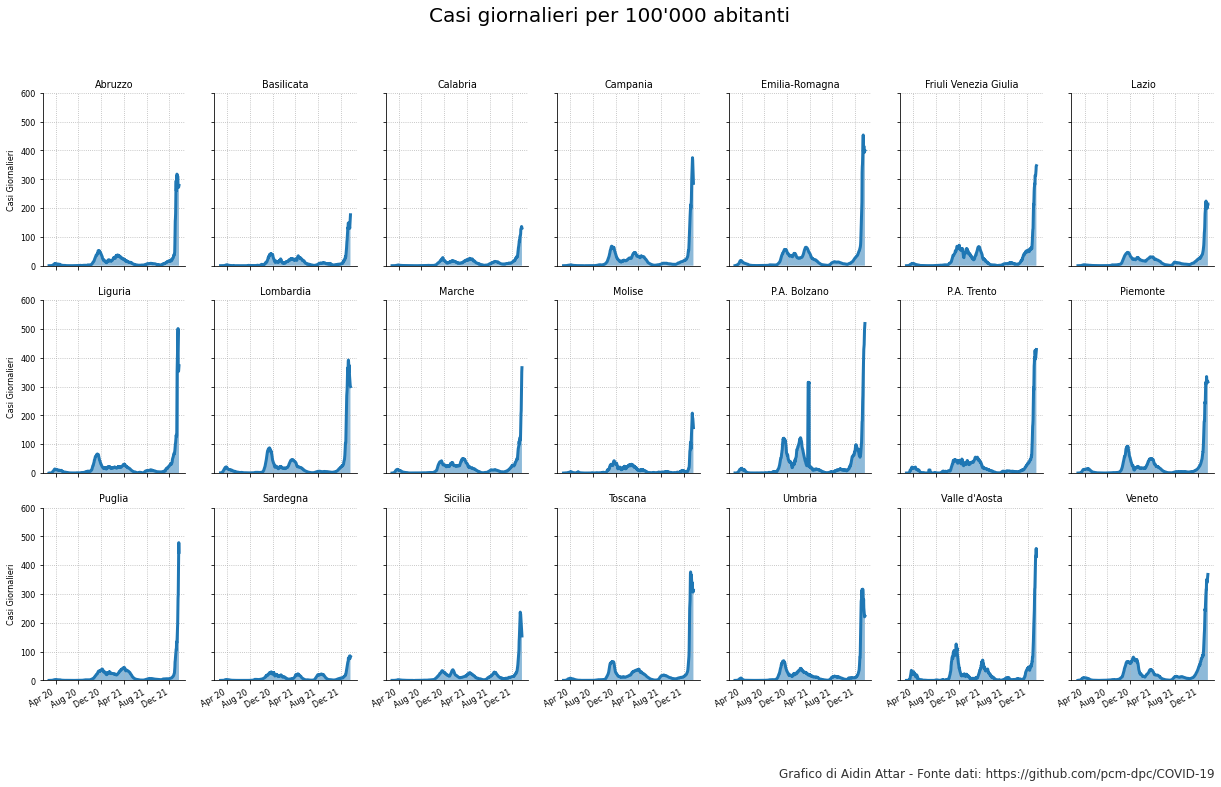

In [48]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_casi_giorn_norm'],c='C0', lw=3)
    ax[y,x].fill_between(Regioni[key].data, Regioni[key]['media_casi_giorn_norm'], facecolor="C0", alpha=0.5)
    #ax[y,x].plot(Regioni[key]['data'], Regioni[key]['media_morti_giorn_norm'],c='orange')
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Casi Giornalieri')
ax[1,0].set_ylabel('Casi Giornalieri')
ax[2,0].set_ylabel('Casi Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Casi giornalieri per 100'000 abitanti", fontsize=20)
ax[0,0].set_ylim(bottom=0, top=600)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

In [49]:
ISSpath = '../ISS/covid_19-iss.xlsx'
!curl --output ../ISS/covid_19-iss.xlsx https://www.epicentro.iss.it/coronavirus/open-data/covid_19-iss.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  107k  100  107k    0     0   706k      0 --:--:-- --:--:-- --:--:--  711k


In [50]:
# Numero casi per data prelievo/diagnosi aggiornati alla data riportata in iss_date
ISS_prelievo_diagnosi   = pd.read_excel(ISSpath, sheet_name='casi_prelievo_diagnosi'  )

# Numero casi per data inizio sintomi aggiornati alla data riportata in iss_date
ISS_inizio_sintomi      = pd.read_excel(ISSpath, sheet_name='casi_inizio_sintomi'     )

# Numero casi per data inizio sintomi  i casi di infezione confermata da virus SARS-CoV-2 per cui
# è indicata una data inizio sintomi tranne i casi dichiarati asintomatici aggiornati alla
# data riportata in iss_date
ISS_inizio_sintomi_sint = pd.read_excel(ISSpath, sheet_name='casi_inizio_sintomi_sint')

# Numero totale casi dall'inizio dell'epidemia per regione/PA di diagnosi
# aggiornati alla data riportata in iss_date
ISS_casi_regioni        = pd.read_excel(ISSpath, sheet_name='casi_regioni'            )

# Numero totale casi dall'inizio dell'epidemia per provincia di domicilio/residenza
# aggiornati alla data riportata in iss_date
ISS_casi_provincie      = pd.read_excel(ISSpath, sheet_name='casi_provincie'          )

# Numero ricoveri per data di ricovero aggiornati alla data riportata in iss_date
ISS_ricoveri            = pd.read_excel(ISSpath, sheet_name='ricoveri'                )

# Numero decessi per data di decesso aggiornati alla data riportata in iss_date
ISS_decessi             = pd.read_excel(ISSpath, sheet_name='decessi'                 )

# Numero totale casi e decessi dall'inizio dell'epidemia per sesso
# e per fascia d'età aggiornati alla data riportata in iss_date
ISS_sesso_età           = pd.read_excel(ISSpath, sheet_name='sesso_eta'               )

# Numero totale casi con malattia ancora in corso e con esito finale ancora
# non definito dall'inizio dell'epidemia, differenziati per sintomatologia
# più recente, per sesso e per fascia d'età aggiornati alla data riportata in iss_date
ISS_stato_clinico       = pd.read_excel(ISSpath, sheet_name='stato_clinico'           )

In [51]:
ISS_prelievo_diagnosi.loc[  ISS_prelievo_diagnosi[       'CASI']=='<5',           'CASI']=5
ISS_inizio_sintomi.loc[     ISS_inizio_sintomi[          'CASI']=='<5',           'CASI']=5
ISS_inizio_sintomi_sint.loc[ISS_inizio_sintomi_sint['CASI_SINT']=='<5',      'CASI_SINT']=5
ISS_ricoveri.loc[           ISS_ricoveri[            'RICOVERI']=='<5',       'RICOVERI']=5
ISS_decessi.loc[            ISS_decessi[              'DECESSI']=='<5',        'DECESSI']=5
ISS_sesso_età.loc[          ISS_sesso_età[           'DECEDUTI']=='<5',       'DECEDUTI']=0
ISS_sesso_età.loc[          ISS_sesso_età[    'CASI_CUMULATIVI']=='<5','CASI_CUMULATIVI']=0
ISS_stato_clinico.loc[  ISS_stato_clinico[               'CASI']=='<5',           'CASI']=0

ISS_prelievo_diagnosi['DATA_PRELIEVO_DIAGNOSI'] = pd.to_datetime(ISS_prelievo_diagnosi['DATA_PRELIEVO_DIAGNOSI'],format='%d/%m/%Y', dayfirst=True)
ISS_inizio_sintomi[      'DATA_INIZIO_SINTOMI'] = pd.to_datetime(ISS_inizio_sintomi[      'DATA_INIZIO_SINTOMI'],format='%d/%m/%Y', dayfirst=True)
ISS_inizio_sintomi_sint[ 'DATA_INIZIO_SINTOMI'] = pd.to_datetime(ISS_inizio_sintomi[      'DATA_INIZIO_SINTOMI'],format='%d/%m/%Y', dayfirst=True)
ISS_ricoveri[                  'DATARICOVERO1'] = pd.to_datetime(ISS_ricoveri[                  'DATARICOVERO1'],format='%d/%m/%Y', dayfirst=True)
ISS_decessi[                    'DATA_DECESSO'] = pd.to_datetime(ISS_decessi[                    'DATA_DECESSO'],format='%d/%m/%Y', dayfirst=True)
ISS_decessi.DECESSI                             = ISS_decessi.DECESSI.astype(int)
ISS_prelievo_diagnosi.CASI                      = ISS_prelievo_diagnosi.CASI.astype(int)
ISS_inizio_sintomi.CASI                         = ISS_inizio_sintomi.CASI.astype(int)
ISS_inizio_sintomi_sint.CASI_SINT               = ISS_inizio_sintomi_sint.CASI_SINT.astype(int)
ISS_ricoveri.RICOVERI                           = ISS_ricoveri.RICOVERI.astype(int)
ISS_sesso_età.DECEDUTI                          = ISS_sesso_età.DECEDUTI.astype(int)
ISS_sesso_età.CASI_CUMULATIVI                   = ISS_sesso_età.CASI_CUMULATIVI.astype(int)
ISS_stato_clinico.CASI                          = ISS_stato_clinico.CASI.astype(int)

ISS_decessi['new_date']                         = ISS_decessi['DATA_DECESSO'].dt.date
ISS_decessi                                     = ISS_decessi.set_index('new_date')
ISS_decessi                                     = ISS_decessi.reindex(idx)
ISS_decessi.index                               = ISS_decessi.index.strftime('%d/%m/%Y')

ISS_prelievo_diagnosi['new_date']               = ISS_prelievo_diagnosi['DATA_PRELIEVO_DIAGNOSI'].dt.date
ISS_prelievo_diagnosi                           = ISS_prelievo_diagnosi.set_index('new_date')
ISS_prelievo_diagnosi                           = ISS_prelievo_diagnosi.reindex(idx)
ISS_prelievo_diagnosi.index                     = ISS_prelievo_diagnosi.index.strftime('%d/%m/%Y')

ISS_inizio_sintomi['new_date']                  = ISS_inizio_sintomi['DATA_INIZIO_SINTOMI'].dt.date
ISS_inizio_sintomi                              = ISS_inizio_sintomi.set_index('new_date')
ISS_inizio_sintomi                              = ISS_inizio_sintomi.reindex(idx)
ISS_inizio_sintomi.index                        = ISS_inizio_sintomi.index.strftime('%d/%m/%Y')

ISS_inizio_sintomi_sint['new_date']             = ISS_inizio_sintomi_sint['DATA_INIZIO_SINTOMI'].dt.date
ISS_inizio_sintomi_sint                         = ISS_inizio_sintomi_sint.set_index('new_date')
ISS_inizio_sintomi_sint                         = ISS_inizio_sintomi_sint.reindex(idx)
ISS_inizio_sintomi_sint.index                   = ISS_inizio_sintomi_sint.index.strftime('%d/%m/%Y')

ISS_ricoveri['new_date']                        = ISS_ricoveri['DATARICOVERO1'].dt.date
ISS_ricoveri                                    = ISS_ricoveri.set_index('new_date')
ISS_ricoveri                                    = ISS_ricoveri.reindex(idx)
ISS_ricoveri.index                              = ISS_ricoveri.index.strftime('%d/%m/%Y')

Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità')

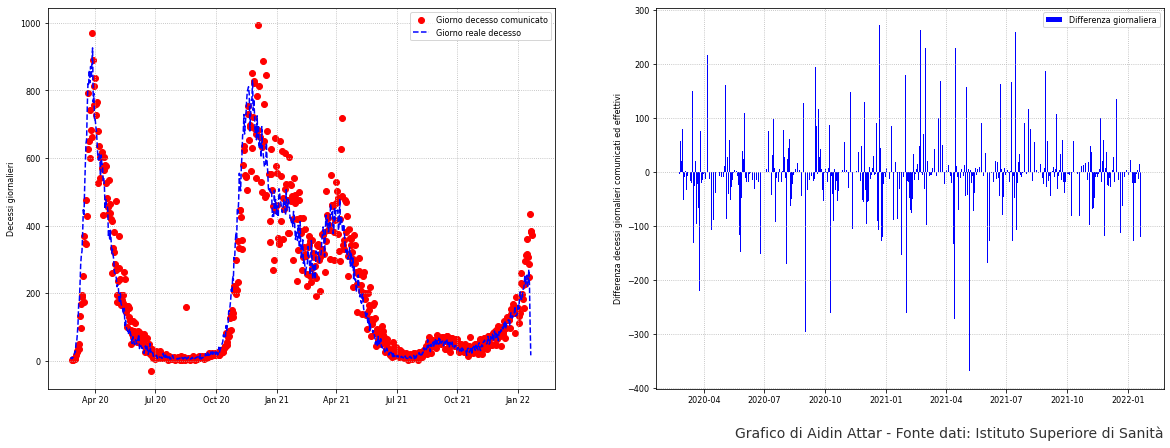

In [52]:
fig, ax = plt.subplots(ncols=2,figsize=(20,7))
ax[0].scatter(italia.data,italia.morti_giornalieri, label='Giorno decesso comunicato', color='red')
ax[0].plot(ISS_decessi.DATA_DECESSO,ISS_decessi.DECESSI, label='Giorno reale decesso', color='blue', linestyle='dashed')
ax[0].grid(linestyle='dotted')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Decessi giornalieri')

ax[1].bar(ISS_decessi.DATA_DECESSO, ISS_decessi.DECESSI-italia.morti_giornalieri, label='Differenza giornaliera', color='blue')
ax[1].grid(linestyle='dotted')
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Differenza decessi giornalieri comunicati ed effettivi')

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')


Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità')

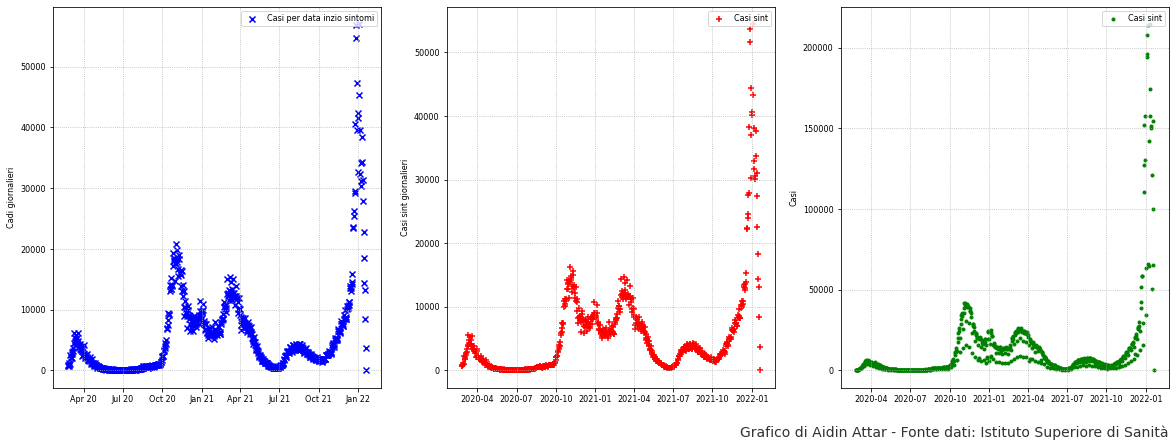

In [53]:
fig, ax = plt.subplots(ncols=3,figsize=(20,7))
ax[0].scatter(ISS_inizio_sintomi.DATA_INIZIO_SINTOMI,ISS_inizio_sintomi.CASI, label='Casi per data inzio sintomi', color='blue', marker='x')
ax[0].grid(linestyle='dotted')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Cadi giornalieri')

ax[1].scatter(ISS_inizio_sintomi_sint.DATA_INIZIO_SINTOMI, ISS_inizio_sintomi_sint.CASI_SINT, label='Casi sint', color='red', marker='+')
ax[1].grid(linestyle='dotted')
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Casi sint giornalieri')

ax[2].scatter(ISS_prelievo_diagnosi.DATA_PRELIEVO_DIAGNOSI, ISS_prelievo_diagnosi.CASI, label='Casi sint', color='green', marker='.')
ax[2].grid(linestyle='dotted')
ax[2].xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
ax[2].legend(loc='upper right')
ax[2].set_ylabel('Casi')

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')


In [54]:
ISS_età = ISS_sesso_età.groupby(['AGE_GROUP'])[['DECEDUTI','CASI_CUMULATIVI']].agg('sum')
ISS_età['PERCENTUALE_DECESSI'] = ISS_età['DECEDUTI'] / ISS_età['CASI_CUMULATIVI'] * 100

ISS_sesso = ISS_sesso_età.groupby(['SESSO'])[['DECEDUTI','CASI_CUMULATIVI']].agg('sum')
ISS_sesso['PERCENTUALE_DECESSI'] = ISS_sesso['DECEDUTI'] / ISS_sesso['CASI_CUMULATIVI'] * 100

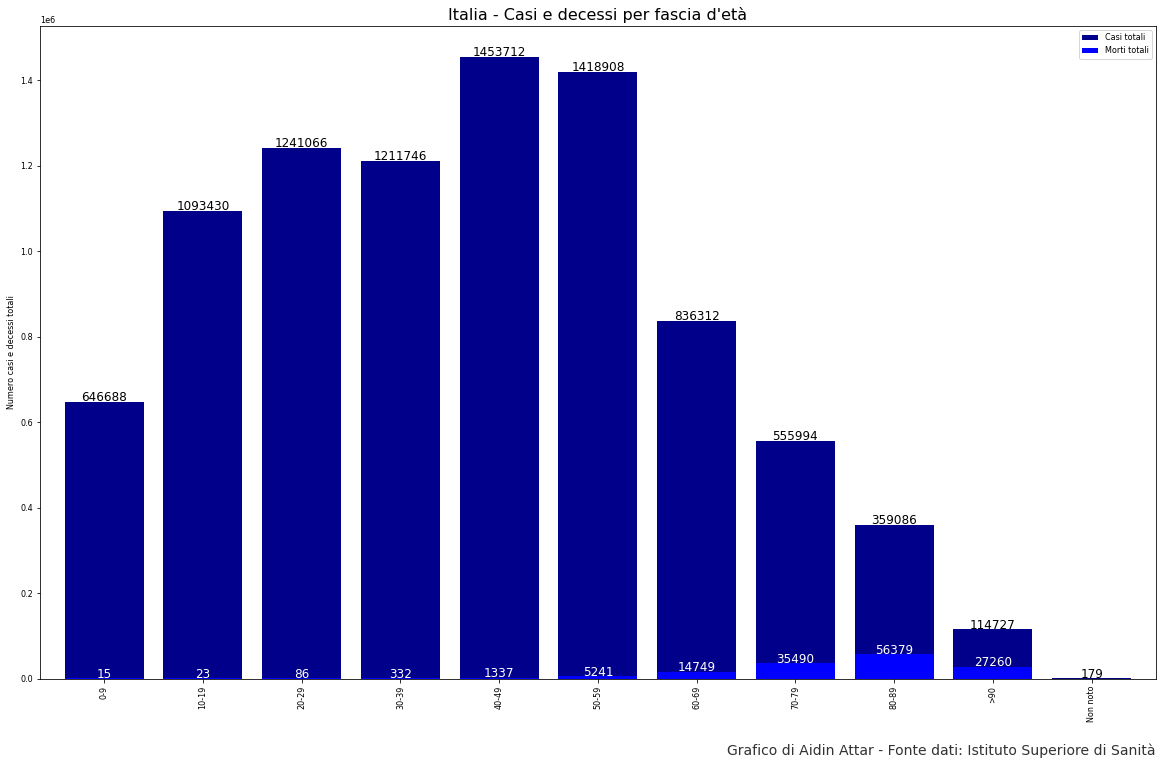

In [55]:
fig, ax = plt.subplots(figsize=(20,12))

ISS_età['CASI_CUMULATIVI'].plot.bar(ax=ax, color=  'darkblue',width=.8, label= 'Casi totali')
ISS_età[       'DECEDUTI'].plot.bar(ax=ax, color='blue',width=.8, label='Morti totali')

ax.legend(loc='best')
ax.set_ylabel('Numero casi e decessi totali')
ax.set_xlabel('')
ax.set_title("Italia - Casi e decessi per fascia d'età", fontsize=16)
#ax.grid(linestyle='dotted')

for index,data in enumerate(ISS_età['CASI_CUMULATIVI']):
    if data != 0:
        plt.text(x=index, y =data+1e4 , s=str(data), color = 'black',fontdict=dict(fontsize=12),ha='center', va='center')

for index,data in enumerate(ISS_età['DECEDUTI']):
    if data != 0:
        plt.text(x=index , y =data+1e4 , s=str(data), color = 'white',fontdict=dict(fontsize=12),ha='center', va='center')

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

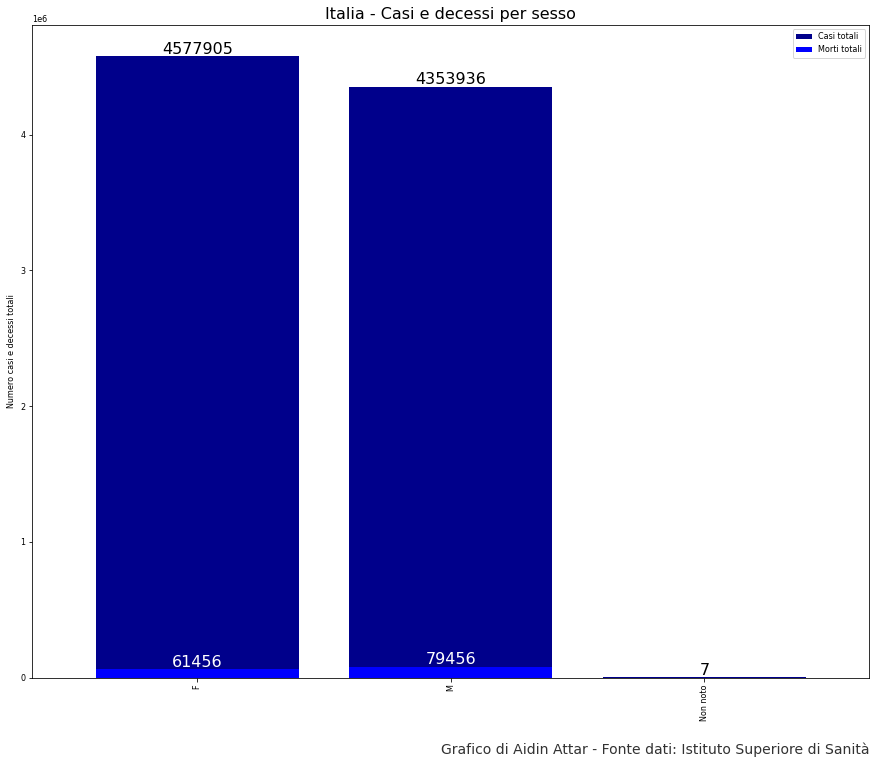

In [56]:
fig, ax = plt.subplots(figsize=(15,12))

ISS_sesso['CASI_CUMULATIVI'].plot.bar(ax=ax, color=  'darkblue',width=.8, label= 'Casi totali')
ISS_sesso[       'DECEDUTI'].plot.bar(ax=ax, color='blue',width=.8, label='Morti totali')

ax.legend(loc='best')
ax.set_ylabel('Numero casi e decessi totali')
ax.set_xlabel('')
ax.set_title("Italia - Casi e decessi per sesso", fontsize=16)
#ax.grid(linestyle='dotted')

for index,data in enumerate(ISS_sesso['CASI_CUMULATIVI']):
    if data != 0:
        plt.text(x=index, y =data+5e4 , s=str(data), color = 'black',fontdict=dict(fontsize=16),ha='center', va='center')

for index,data in enumerate(ISS_sesso['DECEDUTI']):
    if data != 0:
        plt.text(x=index, y =data+5e4 , s=str(data), color = 'white',fontdict=dict(fontsize=16),ha='center', va='center')

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [57]:
ISS_sesso_età_new = ISS_sesso_età.set_index(['AGE_GROUP', 'SESSO'])
ISS_sesso_età_new.DECEDUTI.unstack()

SESSO            F        M  Non noto
AGE_GROUP                            
0-9            8.0      7.0       NaN
10-19         12.0     11.0       NaN
20-29         32.0     54.0       0.0
30-39        122.0    210.0       0.0
40-49        418.0    919.0       0.0
50-59       1495.0   3746.0       0.0
60-69       4189.0  10560.0       0.0
70-79      11670.0  23820.0       NaN
80-89      25814.0  30565.0       0.0
>90        17696.0   9564.0       NaN
Non noto       0.0      0.0       NaN

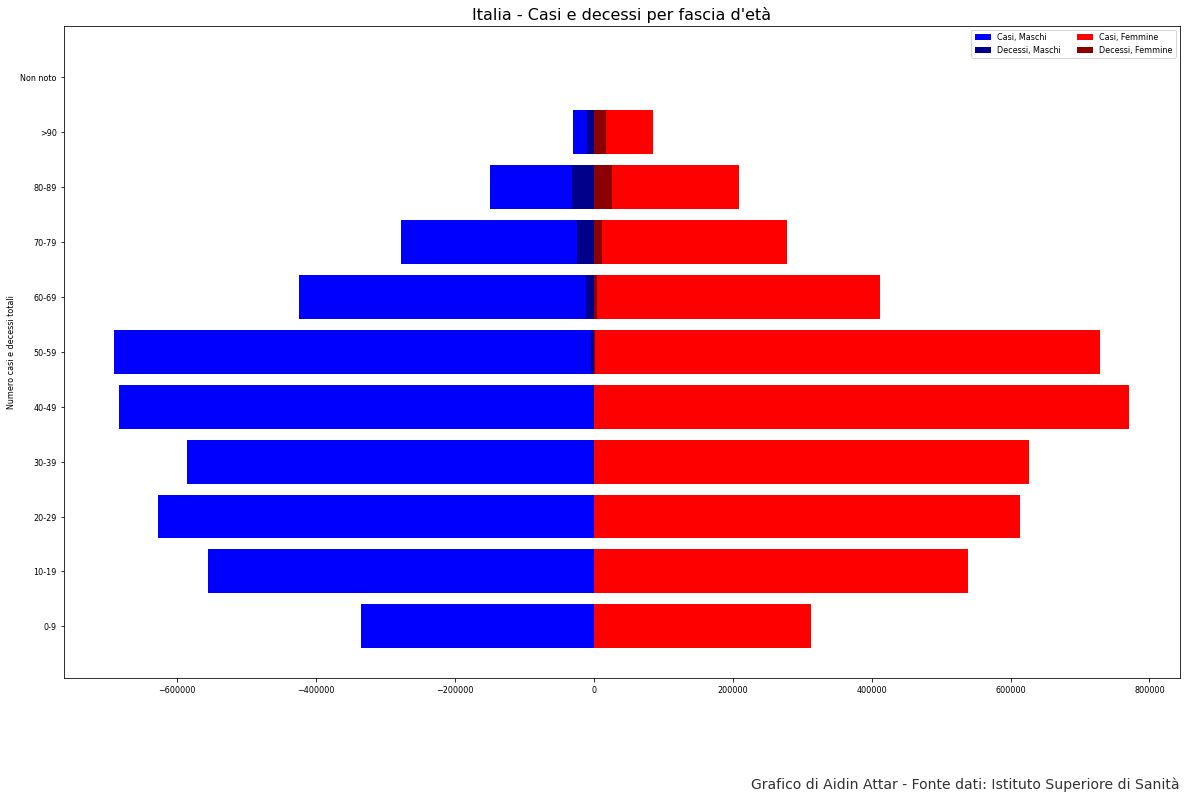

In [58]:
fig, ax = plt.subplots(figsize=(20,12))

ax.barh(ISS_sesso_età_new.CASI_CUMULATIVI.unstack().index, -ISS_sesso_età_new['CASI_CUMULATIVI'].unstack()['M'], label= 'Casi totali', color='blue')
ax.barh(ISS_sesso_età_new.CASI_CUMULATIVI.unstack().index, -ISS_sesso_età_new[       'DECEDUTI'].unstack()['M'], label= 'Casi totali', color='darkblue')
ax.barh(ISS_sesso_età_new.CASI_CUMULATIVI.unstack().index,  ISS_sesso_età_new['CASI_CUMULATIVI'].unstack()['F'], label= 'Casi totali', color='red')
ax.barh(ISS_sesso_età_new.CASI_CUMULATIVI.unstack().index,  ISS_sesso_età_new[       'DECEDUTI'].unstack()['F'], label= 'Casi totali', color='darkred')

#ISS_sesso_età_new['CASI_CUMULATIVI'].unstack()['M'].plot.barh(ax=ax,width=.8, label= 'Casi totali', color=['blue'])
#ISS_sesso_età_new[       'DECEDUTI'].unstack()['M'].plot.barh(ax=ax,width=.8, label='Morti totali', color=['darkblue'])
#ISS_sesso_età_new['CASI_CUMULATIVI'].unstack()['F'].plot.barh(ax=ax,width=.8, label= 'Casi totali', color=['blue'])
#ISS_sesso_età_new[       'DECEDUTI'].unstack()['F'].plot.barh(ax=ax,width=.8, label='Morti totali', color=['darkblue'])

labels=['Casi, Maschi', 'Decessi, Maschi','Casi, Femmine', 'Decessi, Femmine']
ax.legend(labels, loc='best', ncol=2)
ax.set_ylabel('Numero casi e decessi totali')
ax.set_xlabel('')
ax.set_title("Italia - Casi e decessi per fascia d'età", fontsize=16)
#ax.grid(linestyle='dotted')
'''
for index,data in enumerate(ISS_sesso_età_new['CASI_CUMULATIVI']):
    if data != 0:
        plt.text(x=index-0.25, y =data+1e4 , s=str(data), color = 'black',fontdict=dict(fontsize=12))

for index,data in enumerate(ISS_sesso_età_new['DECEDUTI']):
    if data != 0:
        plt.text(x=index-0.2 , y =data+1e4 , s=str(data), color = 'white',fontdict=dict(fontsize=12))'''

plt.text(0.9, 0.01, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

In [59]:
ISS_stato_clinico_new = ISS_stato_clinico.set_index(['AGE_GROUP', 'STATO_CLINICO'])
ISS_stato_clinico_new

iss_date SESSO   CASI
AGE_GROUP STATO_CLINICO                             
0-9       ASINTOMATICO       20/01/2022     F  60195
          CRITICO            20/01/2022     F      0
          LIEVE              20/01/2022     F  14951
          PAUCI-SINTOMATICO  20/01/2022     F  14784
          SEVERO             20/01/2022     F    204
...                                 ...   ...    ...
>90       CRITICO            20/01/2022     M     31
          LIEVE              20/01/2022     M    599
          PAUCI-SINTOMATICO  20/01/2022     M    559
          SEVERO             20/01/2022     M    388
Non noto  ASINTOMATICO       20/01/2022     M     25

[103 rows x 3 columns]

In [60]:
ISS_stato_clinico_casi = ISS_stato_clinico.groupby(['AGE_GROUP', 'STATO_CLINICO'])['CASI'].sum()
ISS_stato_clinico_casi.unstack()

STATO_CLINICO  ASINTOMATICO  CRITICO    LIEVE  PAUCI-SINTOMATICO  SEVERO
AGE_GROUP                                                               
0-9                125366.0     10.0  30930.0            30281.0   493.0
10-19              216146.0     19.0  43386.0            50362.0   227.0
20-29              225409.0     34.0  47371.0            54475.0   563.0
30-39              205195.0     52.0  48003.0            56033.0   800.0
40-49              232899.0    198.0  57901.0            64188.0  1093.0
50-59              216376.0    475.0  50922.0            56636.0  1872.0
60-69              119384.0    709.0  25782.0            28149.0  2565.0
70-79               70108.0    699.0  15257.0            15413.0  3579.0
80-89               36282.0    292.0   7484.0             7578.0  3561.0
>90                  9802.0     64.0   1873.0             1936.0  1091.0
Non noto               38.0      NaN      NaN                0.0     NaN

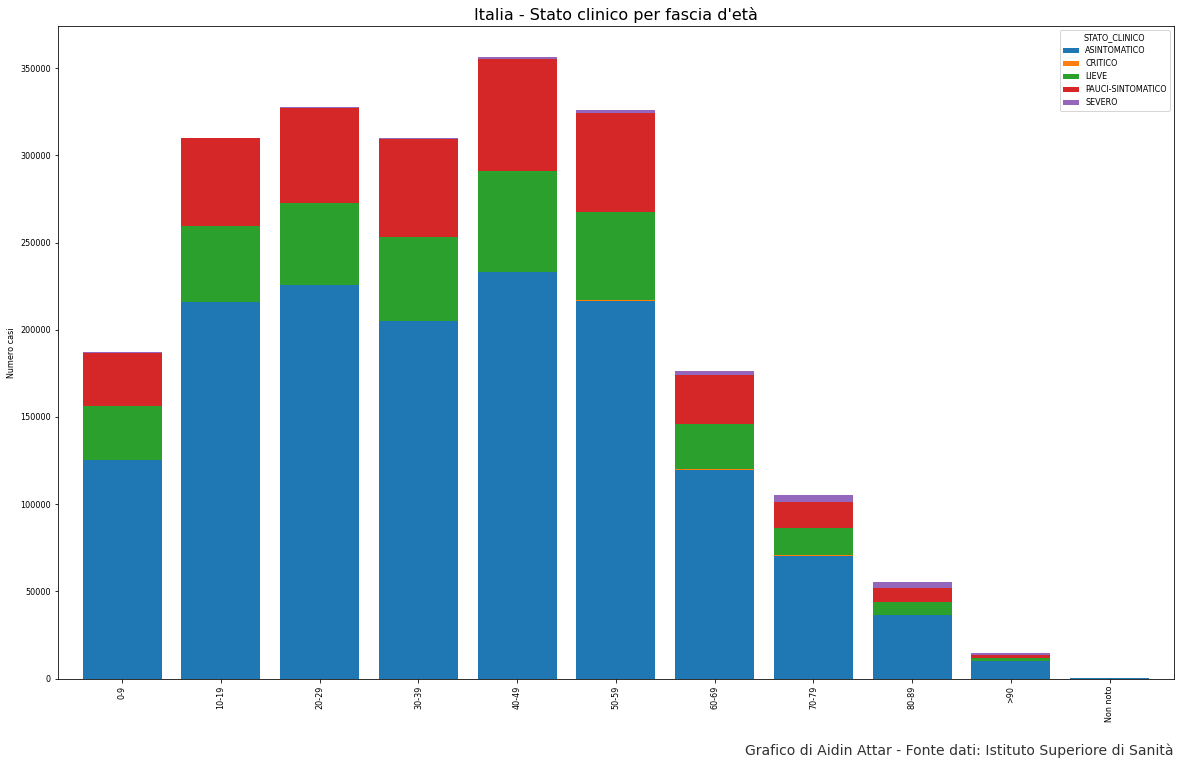

In [61]:
fig, ax = plt.subplots(figsize=(20,12))

ISS_stato_clinico_casi.unstack().plot.bar(ax=ax,width=.8, stacked=True)

ax.set_ylabel('Numero casi')
ax.set_xlabel('')
ax.set_title("Italia - Stato clinico per fascia d'età", fontsize=16)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [62]:
ISS_stato_clinico_casi_norm = ISS_stato_clinico_casi.unstack().fillna(0).stack()
StatiClinici                = ISS_stato_clinico.STATO_CLINICO.unique()
AgeGroups                   = ISS_stato_clinico.AGE_GROUP.unique()
for x in AgeGroups:
    for y in StatiClinici:
        ISS_stato_clinico_casi_norm[x][y] = ISS_stato_clinico_casi_norm[x][y] / ISS_stato_clinico_casi[x].sum()
ISS_stato_clinico_casi_norm.unstack()

STATO_CLINICO  ASINTOMATICO   CRITICO     LIEVE  PAUCI-SINTOMATICO    SEVERO
AGE_GROUP                                                                   
0-9                0.670120  0.000053  0.165330           0.161861  0.002635
10-19              0.696930  0.000061  0.139892           0.162385  0.000732
20-29              0.687533  0.000104  0.144489           0.166157  0.001717
30-39              0.661742  0.000168  0.154807           0.180703  0.002580
40-49              0.653698  0.000556  0.162516           0.180162  0.003068
50-59              0.663158  0.001456  0.156068           0.173580  0.005737
60-69              0.676056  0.004015  0.146000           0.159404  0.014525
70-79              0.667339  0.006654  0.145227           0.146712  0.034068
80-89              0.657318  0.005290  0.135587           0.137290  0.064514
>90                0.663822  0.004334  0.126845           0.131112  0.073886
Non noto           1.000000  0.000000  0.000000           0.000000  0.000000

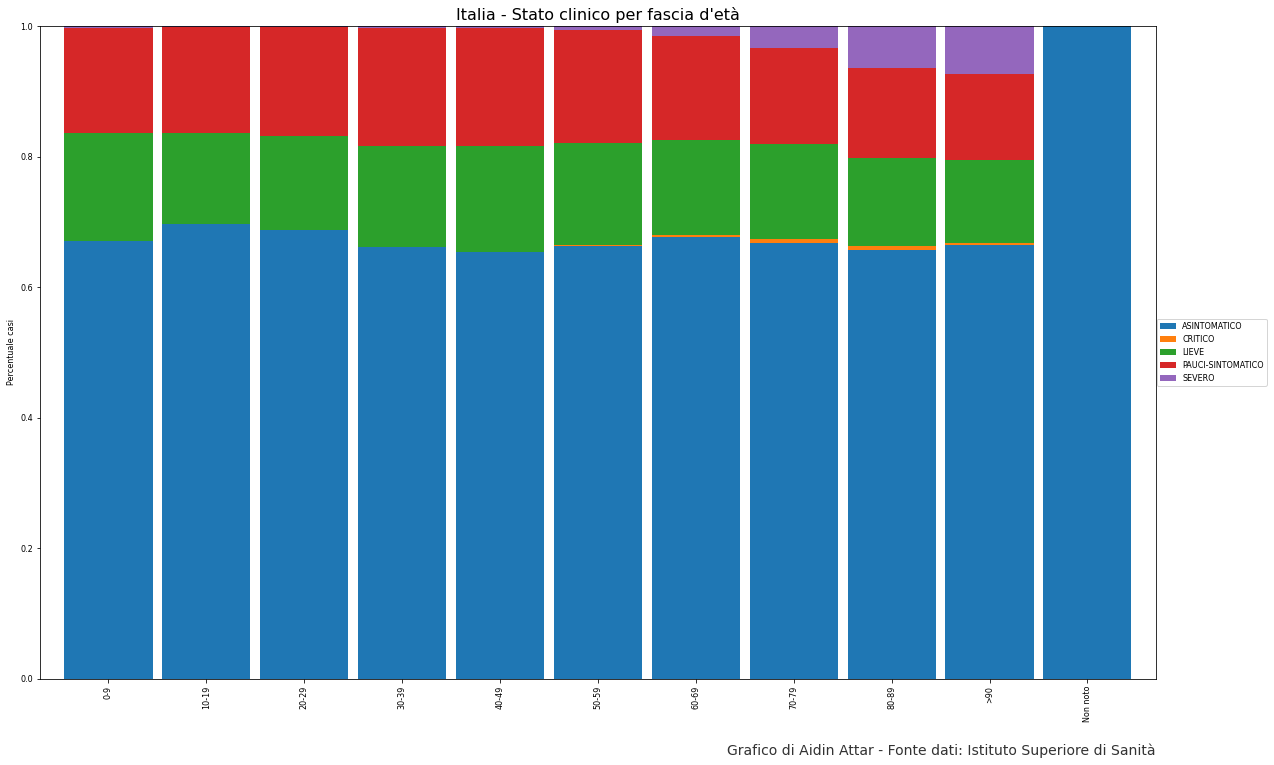

In [63]:
fig, ax = plt.subplots(figsize=(20,12))

ISS_stato_clinico_casi_norm.unstack().plot.bar(ax=ax,width=.9,stacked=True)

ax.legend(loc='center', bbox_to_anchor=(1.05, 0.5))
ax.set_ylabel('Percentuale casi')
ax.set_xlabel('')
ax.set_title("Italia - Stato clinico per fascia d'età", fontsize=16),
ax.set_ylim([0,1])

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

-510398.9656083259 511681.61350893386 0.0014059329204246151


Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità')

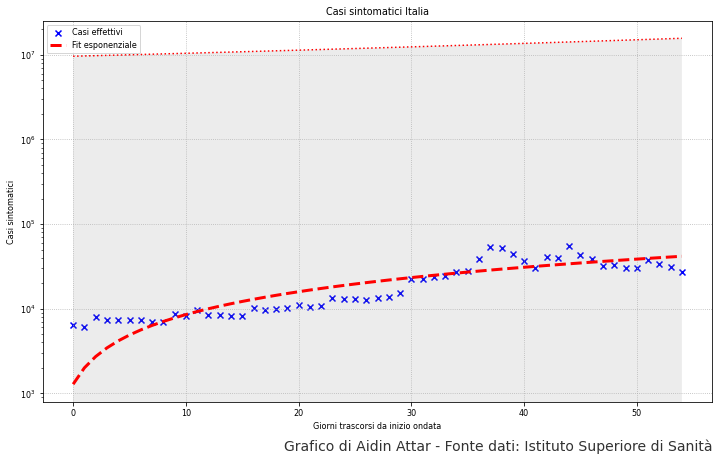

In [64]:
lastday = (date.today() - timedelta(days=8))

ISS_inizio_sintomi_sint_fit           = ISS_inizio_sintomi_sint.loc['20/11/2021':lastday.strftime('%d/%m/%Y')]
ISS_inizio_sintomi_sint_fit           = ISS_inizio_sintomi_sint_fit.reset_index()

def expo(x, a, b, c):
    return a + b*np.exp(c*x)

popt, pcov = optimize.curve_fit(expo, ISS_inizio_sintomi_sint_fit.index, ISS_inizio_sintomi_sint_fit.CASI_SINT, maxfev=2000, p0=(4200,510,0.066))

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(ISS_inizio_sintomi_sint_fit.index, ISS_inizio_sintomi_sint_fit.CASI_SINT, marker='x', color='blue', label='Casi effettivi')
ax.plot(ISS_inizio_sintomi_sint_fit.index, expo(ISS_inizio_sintomi_sint_fit.index, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', label='Fit esponenziale', lw=3)
ax.plot(ISS_inizio_sintomi_sint_fit.index, expo(ISS_inizio_sintomi_sint_fit.index, popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5), linestyle='dotted',c = 'r', label='')
ax.plot(ISS_inizio_sintomi_sint_fit.index, expo(ISS_inizio_sintomi_sint_fit.index, popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5), linestyle='dotted',c = 'r', label='')
plt.fill_between(ISS_inizio_sintomi_sint_fit.index,
                 expo(ISS_inizio_sintomi_sint_fit.index, popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5),
                 expo(ISS_inizio_sintomi_sint_fit.index, popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5),
                 facecolor="gray", alpha=0.15)
ax.grid(linestyle='dotted')
ax.set_title('Casi sintomatici Italia')
ax.set_xlabel('Giorni trascorsi da inizio ondata')
ax.set_ylabel('Casi sintomatici')
ax.legend(loc='upper left')
ax.set_yscale("log")
print(popt[0],popt[1],popt[2])

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

-19599.750406432635 14296.822963303688 0.03427583562040189


Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità')

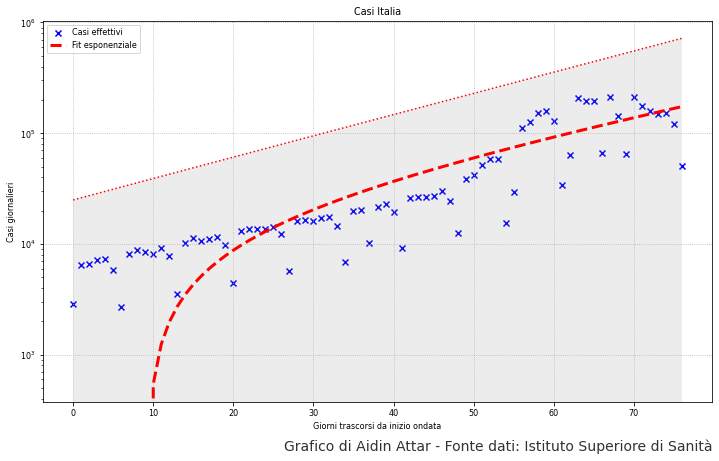

In [65]:
lastday = (date.today() - timedelta(days=5))
ISS_prelievo_diagnosi_fit           = ISS_prelievo_diagnosi.loc['01/11/2021':lastday.strftime('%d/%m/%Y')]
ISS_prelievo_diagnosi_fit           = ISS_prelievo_diagnosi_fit.reset_index()

popt, pcov = optimize.curve_fit(expo, ISS_prelievo_diagnosi_fit.index, ISS_prelievo_diagnosi_fit.CASI, p0=(6600, 2220, .09))

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(ISS_prelievo_diagnosi_fit.index, ISS_prelievo_diagnosi_fit.CASI, marker='x', color='blue', label='Casi effettivi')
ax.plot(ISS_prelievo_diagnosi_fit.index, expo(ISS_prelievo_diagnosi_fit.index, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', label='Fit esponenziale', lw=3)
ax.plot(ISS_prelievo_diagnosi_fit.index, expo(ISS_prelievo_diagnosi_fit.index, popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5), linestyle='dotted',c = 'r', label='')
ax.plot(ISS_prelievo_diagnosi_fit.index, expo(ISS_prelievo_diagnosi_fit.index, popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5), linestyle='dotted',c = 'r', label='')
plt.fill_between(ISS_prelievo_diagnosi_fit.index,
                 expo(ISS_prelievo_diagnosi_fit.index, popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5),
                 expo(ISS_prelievo_diagnosi_fit.index, popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5),
                 facecolor="gray", alpha=0.15)
ax.grid(linestyle='dotted')
ax.set_title('Casi Italia')
ax.set_xlabel('Giorni trascorsi da inizio ondata')
ax.set_ylabel('Casi giornalieri')
ax.legend(loc='upper left')
ax.set_yscale("log")
print(popt[0],popt[1],popt[2])

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

0.7037744863825217 2.304507087118628
Power_divergenceResult(statistic=486.4195693442731, pvalue=1.047355280889876e-55)


Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità')

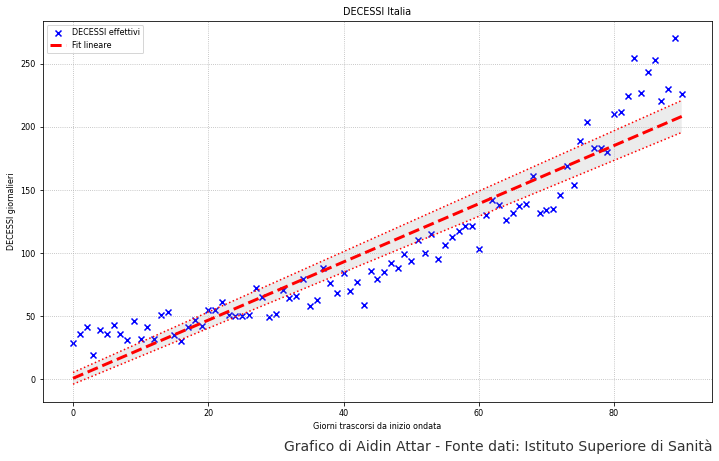

In [66]:
lastday = (date.today() - timedelta(days=3))
ISS_decessi_fit           = ISS_decessi.loc['20/10/2021':lastday.strftime('%d/%m/%Y')]
ISS_decessi_fit           = ISS_decessi_fit.reset_index()

def linear(x, a, b):
    return a + b*x

popt, pcov = optimize.curve_fit(linear, ISS_decessi_fit.index, ISS_decessi_fit.DECESSI)#, p0=(10645, 8.5, 0.16))

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(ISS_decessi_fit.index, ISS_decessi_fit.DECESSI, marker='x', color='blue', label='DECESSI effettivi')
ax.plot(ISS_decessi_fit.index, linear(ISS_decessi_fit.index, popt[0],popt[1]), linestyle='dashed',c = 'r', label='Fit lineare', lw=3)
ax.plot(ISS_decessi_fit.index, linear(ISS_decessi_fit.index, popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5), linestyle='dotted',c = 'r', label='')
ax.plot(ISS_decessi_fit.index, linear(ISS_decessi_fit.index, popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5), linestyle='dotted',c = 'r', label='')
plt.fill_between(ISS_decessi_fit.index,
                 linear(ISS_decessi_fit.index, popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5),
                 linear(ISS_decessi_fit.index, popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5),
                 facecolor="gray", alpha=0.15)
ax.grid(linestyle='dotted')
ax.set_title('DECESSI Italia')
ax.set_xlabel('Giorni trascorsi da inizio ondata')
ax.set_ylabel('DECESSI giornalieri')
ax.legend(loc='upper left')
#ax.set_yscale("log")
print(popt[0],popt[1])
print(stats.chisquare(linear(ISS_decessi_fit.index, popt[0],popt[1]), ISS_decessi_fit.DECESSI))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

171122.12617460854 36.883808193011724 11.213628796083956
Power_divergenceResult(statistic=14453.580081919301, pvalue=0.0)
14453.580081919297


Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19')

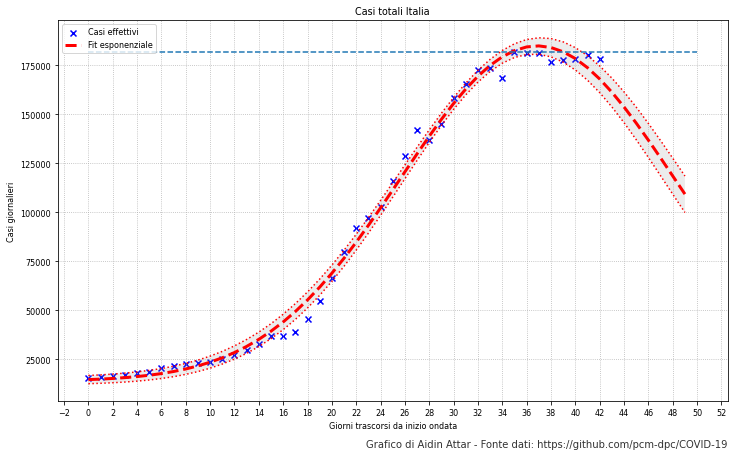

In [67]:
if datetime.strptime(italia.index[-1], '%d/%m/%Y').date() == today.date():
    italia_fit           = italia.loc['10/12/2021':today.strftime('%d/%m/%Y')]
else:
    italia_fit           = italia.loc['10/12/2021':yesterday.strftime('%d/%m/%Y')]
italia_fit           = italia_fit.reset_index()

def gaussian(x, N, mu, sig, offset):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + offset

def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp[i])**2)/(error[i]**2)
    return chisqr

popt, pcov = optimize.curve_fit(gaussian, italia_fit.index, italia_fit.media_casi_giorn, maxfev=2000,p0=(2e5,40,10, 10000))

top  = gaussian(np.arange(50), popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5,popt[3]+pcov[3,3]**0.5)
real = gaussian(np.arange(50), popt[0],popt[1],popt[2],popt[3])
bott = gaussian(np.arange(50), popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5,popt[3]-pcov[3,3]**0.5)

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(italia_fit.index, italia_fit.media_casi_giorn, marker='x', color='blue', label='Casi effettivi')
ax.plot(np.arange(50), real, linestyle='dashed',c = 'r', label='Fit esponenziale', lw=3)
ax.plot(np.arange(50), top , linestyle='dotted',c = 'r', label='')
ax.plot(np.arange(50), bott, linestyle='dotted',c = 'r', label='')
plt.fill_between(np.arange(50), top, bott, facecolor="gray", alpha=0.15)
ax.grid(linestyle='dotted')
ax.set_title('Casi totali Italia')
ax.set_xlabel('Giorni trascorsi da inizio ondata')
ax.set_ylabel('Casi giornalieri')
ax.legend(loc='upper left')
#ax.set_yscale("log")
print(popt[0],popt[1],popt[2])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.hlines(italia_fit['media_casi_giorn'].max(), 0,50, linestyle='dashed')

print(stats.chisquare(gaussian(italia_fit.index, popt[0],popt[1],popt[2],popt[3]), italia_fit.media_casi_giorn, ddof=italia_fit.index.size - 4))
italia_fit['media_casi_giorn_err'] = italia_fit.media_casi_giorn**.5
print(chisqr(italia_fit.media_casi_giorn, gaussian(italia_fit.index, popt[0],popt[1],popt[2],popt[3]), italia_fit.media_casi_giorn_err))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=10, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

181767.74969327555 35.87397219617956 12.919177706901612
Power_divergenceResult(statistic=540562.5516136902, pvalue=0.0)
540562.5516136903


Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19')

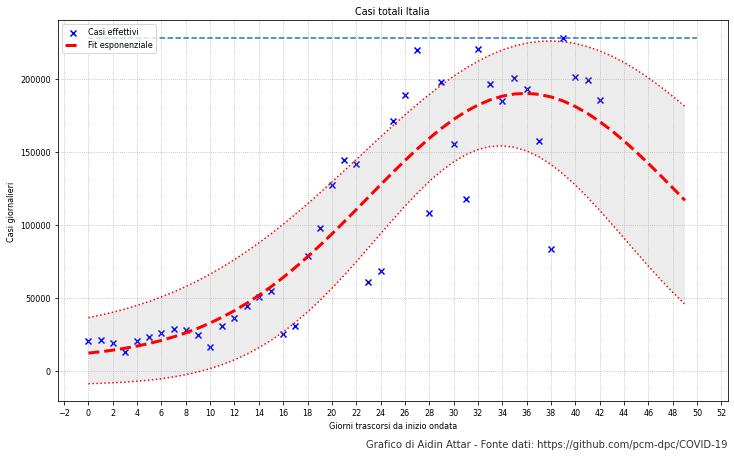

In [68]:
popt, pcov = optimize.curve_fit(gaussian, italia_fit.index, italia_fit.casi_giornalieri, maxfev=2000,p0=(2e5,40,10, 10000))

top  = gaussian(np.arange(50), popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5,popt[3]+pcov[3,3]**0.5)
real = gaussian(np.arange(50), popt[0],popt[1],popt[2],popt[3])
bott = gaussian(np.arange(50), popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5,popt[3]-pcov[3,3]**0.5)

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(italia_fit.index, italia_fit.casi_giornalieri, marker='x', color='blue', label='Casi effettivi')
ax.plot(np.arange(50), real, linestyle='dashed',c = 'r', label='Fit esponenziale', lw=3)
ax.plot(np.arange(50), top , linestyle='dotted',c = 'r', label='')
ax.plot(np.arange(50), bott, linestyle='dotted',c = 'r', label='')
plt.fill_between(np.arange(50), top, bott, facecolor="gray", alpha=0.15)
ax.grid(linestyle='dotted')
ax.set_title('Casi totali Italia')
ax.set_xlabel('Giorni trascorsi da inizio ondata')
ax.set_ylabel('Casi giornalieri')
ax.legend(loc='upper left')
#ax.set_yscale("log")
print(popt[0],popt[1],popt[2])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.hlines(italia_fit['casi_giornalieri'].max(), 0,50, linestyle='dashed')

print(stats.chisquare(gaussian(italia_fit.index, popt[0],popt[1],popt[2],popt[3]), italia_fit.casi_giornalieri, ddof=italia_fit.index.size - 4))
italia_fit['casi_giornalieri_err'] = italia_fit.casi_giornalieri**.5
print(chisqr(italia_fit.casi_giornalieri, gaussian(italia_fit.index, popt[0],popt[1],popt[2],popt[3]), italia_fit.casi_giornalieri_err))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=10, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

2539080.343162625 -2547440.2577720033 -0.0021500338495316347


Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità')

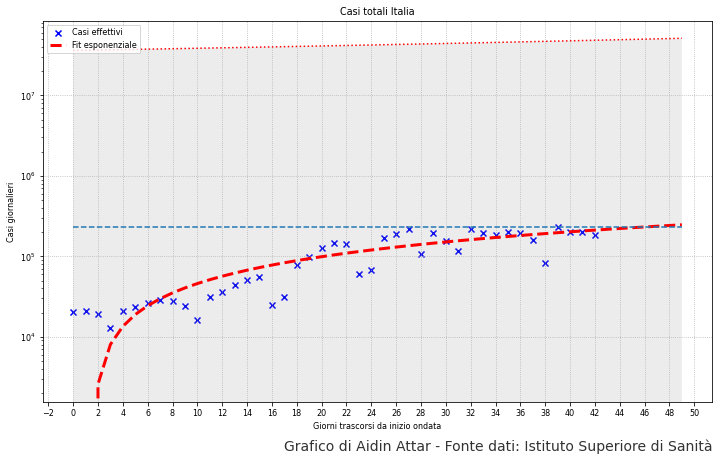

In [68]:
popt, pcov = optimize.curve_fit(expo, italia_fit.index, italia_fit.casi_giornalieri, p0=(4200,510,0.066))

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(italia_fit.index, italia_fit.casi_giornalieri, marker='x', color='blue', label='Casi effettivi')
ax.plot(np.arange(50), expo(np.arange(50), popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', label='Fit esponenziale', lw=3)
ax.plot(np.arange(50), expo(np.arange(50), popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5), linestyle='dotted',c = 'r', label='')
ax.plot(np.arange(50), expo(np.arange(50), popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5), linestyle='dotted',c = 'r', label='')
plt.fill_between(np.arange(50),
                 expo(np.arange(50), popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5),
                 expo(np.arange(50), popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5),
                 facecolor="gray", alpha=0.15)
ax.grid(linestyle='dotted')
ax.set_title('Casi totali Italia')
ax.set_xlabel('Giorni trascorsi da inizio ondata')
ax.set_ylabel('Casi giornalieri')
ax.legend(loc='upper left')
ax.set_yscale("log")
print(popt[0],popt[1],popt[2])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.hlines(italia_fit['casi_giornalieri'].max(), 0,49, linestyle='dashed')



plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

In [69]:
italia_week['casi_settimanali']         = italia_week['totale_casi'] - italia_week['totale_casi'].shift(1)
italia_week['morti_settimanali']        = italia_week['deceduti'] - italia_week['deceduti'].shift(1)

italia_week['tamponi_settimanali']      = italia_week['tamponi'] - italia_week['tamponi'].shift(1)
italia_week['tasso_positivi']           = italia_week['casi_settimanali'] / italia_week['tamponi_settimanali'] * 100
italia_week.drop(italia_week[italia_week.tasso_positivi < 0].index, inplace=True)

italia_week['casi_testati_sett']       = italia_week['casi_testati'] - italia_week['casi_testati'].shift(1)
italia_week['tasso_casi']               = italia_week['casi_settimanali'] / italia_week['casi_testati_sett'] * 100
italia_week.drop(italia_week[italia_week.tasso_casi < 0].index, inplace=True)

italia_week['tamponi_test_molecolare_sett']         = italia_week['tamponi_test_molecolare']         - italia_week['tamponi_test_molecolare'].shift(1)
italia_week['totale_positivi_test_molecolare_sett'] = italia_week['totale_positivi_test_molecolare'] - italia_week['totale_positivi_test_molecolare'].shift(1)
italia_week['tasso_molecolare']                      = italia_week['totale_positivi_test_molecolare_sett'] / italia_week['tamponi_test_molecolare_sett'] * 100
italia_week.drop(italia_week[italia_week.tasso_molecolare < 0].index, inplace=True)

italia_week['tamponi_test_antigenico_rapido_sett']  = italia_week['tamponi_test_antigenico_rapido']  - italia_week['tamponi_test_antigenico_rapido'].shift(1)
italia_week['totale_positivi_test_antigenico_rapido_sett'] = italia_week['totale_positivi_test_antigenico_rapido'] - italia_week['totale_positivi_test_antigenico_rapido'].shift(1)
italia_week['tasso_antigenico_rapido']                      = italia_week['totale_positivi_test_antigenico_rapido_sett'] / italia_week['tamponi_test_antigenico_rapido_sett'] * 100
italia_week.drop(italia_week[italia_week.tasso_antigenico_rapido < 0].index, inplace=True)

italia_week['data'] = italia_week.index.strftime('%d %b %y')

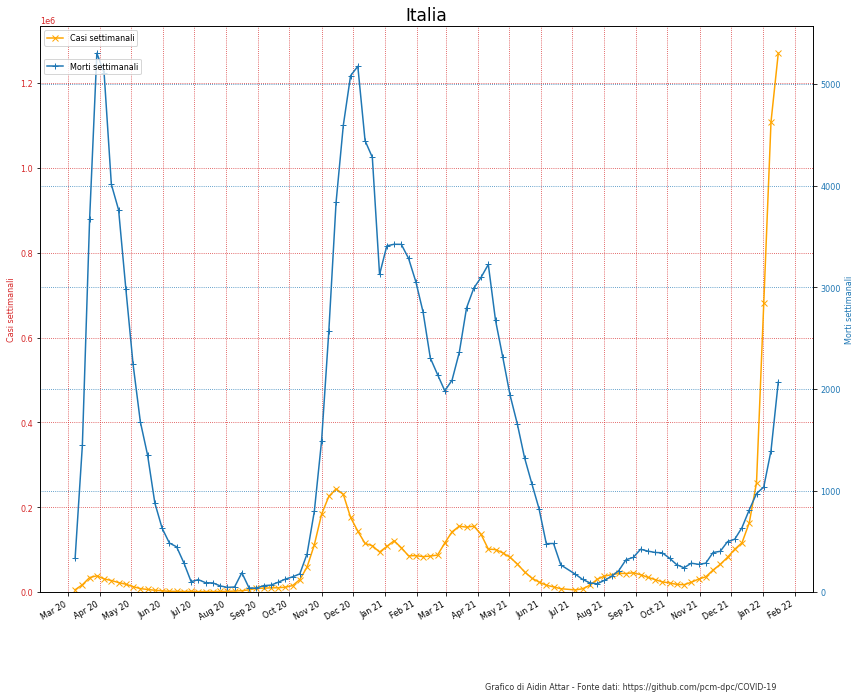

In [70]:
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Casi settimanali', color=color)
ax1.plot(italia_week.index,italia_week.casi_settimanali,
                                label='Casi settimanali',  color='orange',
                               marker='x')

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Morti settimanali', color=color)

ax2.plot(italia_week.index,italia_week.morti_settimanali,
                               label='Morti settimanali',  color='C0',
                               marker='+', )

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_title('Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


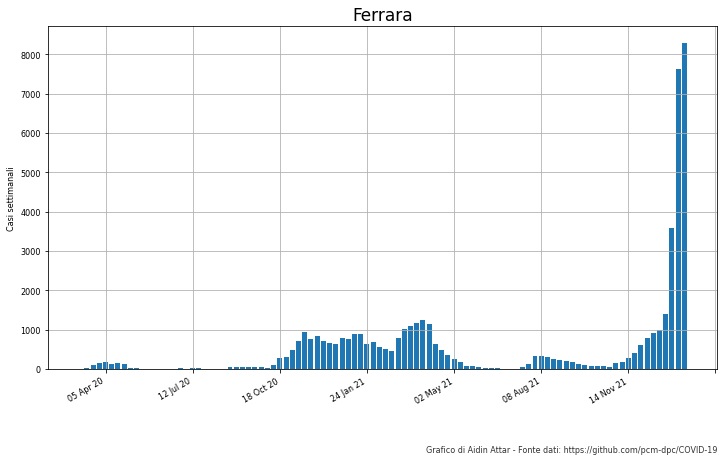

In [71]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(Province_week['Ferrara'].index.strftime('%d %b %y'), Province_week['Ferrara']['casi_settimanali'], label = 'Casi settimanali', color='C0')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.set_title('Ferrara', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Casi settimanali')
ax.set_xlabel("")
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()


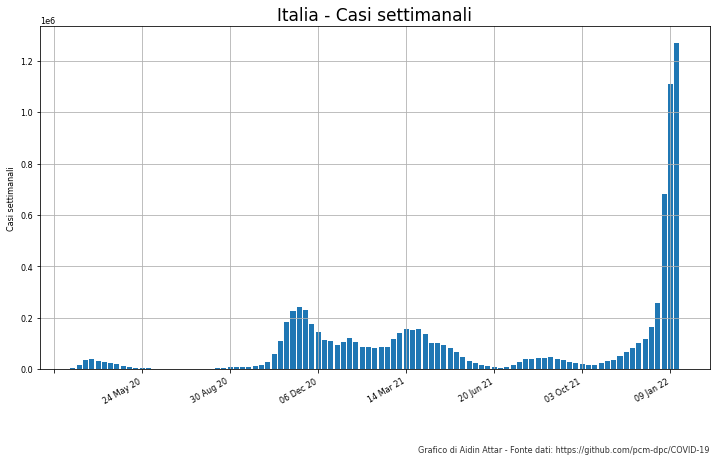

In [72]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(italia_week.index.strftime('%d %b %y'),italia_week['casi_settimanali'], label = 'Casi settimanali', color='C0')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.set_title('Italia - Casi settimanali', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Casi settimanali')
ax.set_xlabel("")
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()


In [73]:
italia_week[                'incremento_casi_settimanali'] = italia_week[                     'casi_settimanali'] / italia_week[         'casi_settimanali' ].shift(1)
italia_week[               'incremento_morti_settimanali'] = italia_week[                    'morti_settimanali'] / italia_week[         'morti_settimanali'].shift(1)
italia_week[                  'incremento_tasso_positivi'] = italia_week[                       'tasso_positivi'] / italia_week[            'tasso_positivi'].shift(1)
italia_week[                'incremento_tasso_molecolare'] = italia_week[                     'tasso_molecolare'] / italia_week[          'tasso_molecolare'].shift(1)
italia_week[         'incremento_tasso_antigenico_rapido'] = italia_week[              'tasso_antigenico_rapido'] / italia_week[   'tasso_antigenico_rapido'].shift(1)
italia_week[      'incremento_ingressi_terapia_intensiva'] = italia_week[           'ingressi_terapia_intensiva'] / italia_week['ingressi_terapia_intensiva'].shift(1)
italia_week[          'media_incremento_casi_settimanali'] = italia_week[         'incremento_casi_settimanali' ].rolling(window=5, min_periods=1).mean()
italia_week[         'media_incremento_morti_settimanali'] = italia_week[         'incremento_morti_settimanali'].rolling(window=5, min_periods=1).mean()
italia_week[            'media_incremento_tasso_positivi'] = italia_week[            'incremento_tasso_positivi'].rolling(window=5, min_periods=1).mean()
italia_week[   'media_incremento_tasso_antigenico_rapido'] = italia_week[   'incremento_tasso_antigenico_rapido'].rolling(window=5, min_periods=1).mean()
italia_week[          'media_incremento_tasso_molecolare'] = italia_week[          'incremento_tasso_molecolare'].rolling(window=5, min_periods=1).mean()
italia_week['media_incremento_ingressi_terapia_intensiva'] = italia_week['incremento_ingressi_terapia_intensiva'].rolling(window=5, min_periods=1).mean()

italia_week[            'std_incremento_casi_settimanali'] = italia_week[          'incremento_casi_settimanali'].rolling(window=5, min_periods=1).std()
italia_week[           'std_incremento_morti_settimanali'] = italia_week[         'incremento_morti_settimanali'].rolling(window=5, min_periods=1).std()
italia_week[              'std_incremento_tasso_positivi'] = italia_week[            'incremento_tasso_positivi'].rolling(window=5, min_periods=1).std()
italia_week[     'std_incremento_tasso_antigenico_rapido'] = italia_week[   'incremento_tasso_antigenico_rapido'].rolling(window=5, min_periods=1).std()
italia_week[            'std_incremento_tasso_molecolare'] = italia_week[          'incremento_tasso_molecolare'].rolling(window=5, min_periods=1).std()
italia_week[  'std_incremento_ingressi_terapia_intensiva'] = italia_week['incremento_ingressi_terapia_intensiva'].rolling(window=5, min_periods=1).std()

italia_week[                   'incremento_ospedalizzati'] = italia_week[                 'totale_ospedalizzati'] / italia_week[        'totale_ospedalizzati'].shift(1)
italia_week[                      'incremento_ricoverati'] = italia_week[               'ricoverati_con_sintomi'] / italia_week[      'ricoverati_con_sintomi'].shift(1)
italia_week[               'incremento_terapie_intensive'] = italia_week[                    'terapia_intensiva'] / italia_week[           'terapia_intensiva'].shift(1)

italia_week[             'media_incremento_ospedalizzati'] = italia_week[             'incremento_ospedalizzati'].rolling(window=5, min_periods=1).mean()
italia_week[                'media_incremento_ricoverati'] = italia_week[                'incremento_ricoverati'].rolling(window=5, min_periods=1).mean()
italia_week[         'media_incremento_terapie_intensive'] = italia_week[         'incremento_terapie_intensive'].rolling(window=5, min_periods=1).mean()
italia_week[               'std_incremento_ospedalizzati'] = italia_week[             'incremento_ospedalizzati'].rolling(window=5, min_periods=1).std()
italia_week[                  'std_incremento_ricoverati'] = italia_week[                'incremento_ricoverati'].rolling(window=5, min_periods=1).std()
italia_week[           'std_incremento_terapie_intensive'] = italia_week[         'incremento_terapie_intensive'].rolling(window=5, min_periods=1).std()


for key in Regioni_week.keys():
    Regioni_week[key][                'incremento_casi_settimanali'] = Regioni_week[key][                     'casi_settimanali'] / Regioni_week[key][         'casi_settimanali' ].shift(1)
    Regioni_week[key][               'incremento_morti_settimanali'] = Regioni_week[key][                    'morti_settimanali'] / Regioni_week[key][         'morti_settimanali'].shift(1)
    Regioni_week[key][                  'incremento_tasso_positivi'] = Regioni_week[key][                       'tasso_positivi'] / Regioni_week[key][            'tasso_positivi'].shift(1)
    Regioni_week[key][                'incremento_tasso_molecolare'] = Regioni_week[key][                     'tasso_molecolare'] / Regioni_week[key][          'tasso_molecolare'].shift(1)
    Regioni_week[key][         'incremento_tasso_antigenico_rapido'] = Regioni_week[key][              'tasso_antigenico_rapido'] / Regioni_week[key][   'tasso_antigenico_rapido'].shift(1)
    Regioni_week[key][      'incremento_ingressi_terapia_intensiva'] = Regioni_week[key][           'ingressi_terapia_intensiva'] / Regioni_week[key]['ingressi_terapia_intensiva'].shift(1)
    Regioni_week[key][          'media_incremento_casi_settimanali'] = Regioni_week[key][         'incremento_casi_settimanali' ].rolling(window=5, min_periods=1).mean()
    Regioni_week[key][         'media_incremento_morti_settimanali'] = Regioni_week[key][         'incremento_morti_settimanali'].rolling(window=5, min_periods=1).mean()
    Regioni_week[key][            'media_incremento_tasso_positivi'] = Regioni_week[key][            'incremento_tasso_positivi'].rolling(window=5, min_periods=1).mean()
    Regioni_week[key][   'media_incremento_tasso_antigenico_rapido'] = Regioni_week[key][   'incremento_tasso_antigenico_rapido'].rolling(window=5, min_periods=1).mean()
    Regioni_week[key][          'media_incremento_tasso_molecolare'] = Regioni_week[key][          'incremento_tasso_molecolare'].rolling(window=5, min_periods=1).mean()
    Regioni_week[key]['media_incremento_ingressi_terapia_intensiva'] = Regioni_week[key]['incremento_ingressi_terapia_intensiva'].rolling(window=5, min_periods=1).mean()
    Regioni_week[key][            'std_incremento_casi_settimanali'] = Regioni_week[key][         'incremento_casi_settimanali' ].rolling(window=5, min_periods=1).std()
    Regioni_week[key][           'std_incremento_morti_settimanali'] = Regioni_week[key][         'incremento_morti_settimanali'].rolling(window=5, min_periods=1).std()
    Regioni_week[key][              'std_incremento_tasso_positivi'] = Regioni_week[key][            'incremento_tasso_positivi'].rolling(window=5, min_periods=1).std()
    Regioni_week[key][     'std_incremento_tasso_antigenico_rapido'] = Regioni_week[key][   'incremento_tasso_antigenico_rapido'].rolling(window=5, min_periods=1).std()
    Regioni_week[key][            'std_incremento_tasso_molecolare'] = Regioni_week[key][          'incremento_tasso_molecolare'].rolling(window=5, min_periods=1).std()
    Regioni_week[key][  'std_incremento_ingressi_terapia_intensiva'] = Regioni_week[key]['incremento_ingressi_terapia_intensiva'].rolling(window=5, min_periods=1).std()

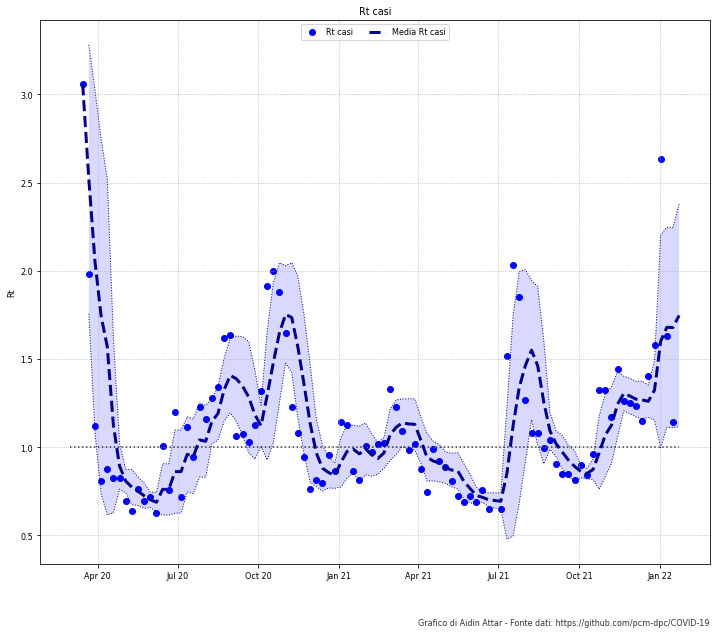

In [74]:
fig, ax = plt.subplots(figsize=(12,10))
ax.hlines(1, italia_week.index.min(),italia_week.index.max(), color='black', linestyle='dotted', alpha=0.75)

ax.scatter(italia_week.index, italia_week.incremento_casi_settimanali, color='blue', label='Rt casi')
ax.plot(italia_week.index, italia_week.media_incremento_casi_settimanali, lw=3, color='darkblue', linestyle='dashed', label='Media Rt casi')
ax.plot(italia_week.index, italia_week.media_incremento_casi_settimanali+italia_week.std_incremento_casi_settimanali, lw=1, color='darkblue', linestyle='dotted', label='')
ax.plot(italia_week.index, italia_week.media_incremento_casi_settimanali-italia_week.std_incremento_casi_settimanali, lw=1, color='darkblue', linestyle='dotted', label='')
plt.fill_between(italia_week.index,
                 italia_week.media_incremento_casi_settimanali+italia_week.std_incremento_casi_settimanali,
                 italia_week.media_incremento_casi_settimanali-italia_week.std_incremento_casi_settimanali,
                 facecolor="blue", alpha=0.15)
ax.grid(linestyle='dotted')
ax.legend(loc='upper center', ncol=3)
ax.set_ylabel('Rt')
ax.set_title('Rt casi')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

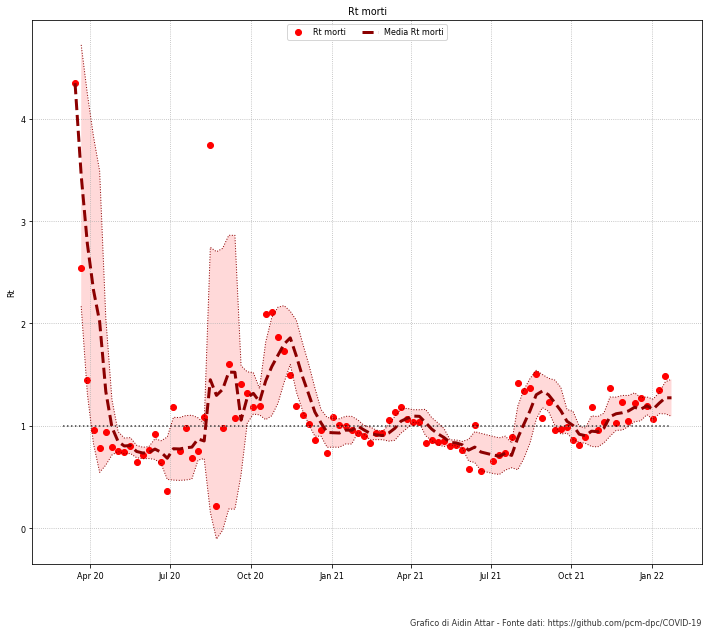

In [75]:
fig, ax = plt.subplots(figsize=(12,10))
ax.hlines(1, italia_week.index.min(),italia_week.index.max(), color='black', linestyle='dotted', alpha=0.75)

ax.scatter(italia_week.index, italia_week.incremento_morti_settimanali, color='red', label='Rt morti')
ax.plot(italia_week.index, italia_week.media_incremento_morti_settimanali, lw=3, color='darkred', linestyle='dashed', label='Media Rt morti')
ax.plot(italia_week.index, italia_week.media_incremento_morti_settimanali+italia_week.std_incremento_morti_settimanali, lw=1, color='darkred', linestyle='dotted', label='')
ax.plot(italia_week.index, italia_week.media_incremento_morti_settimanali-italia_week.std_incremento_morti_settimanali, lw=1, color='darkred', linestyle='dotted', label='')
plt.fill_between(italia_week.index,
                 italia_week.media_incremento_morti_settimanali+italia_week.std_incremento_morti_settimanali,
                 italia_week.media_incremento_morti_settimanali-italia_week.std_incremento_morti_settimanali,
                 facecolor="red", alpha=0.15)

ax.grid(linestyle='dotted')
ax.legend(loc='upper center', ncol=3)
ax.set_ylabel('Rt')
ax.set_title('Rt morti')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

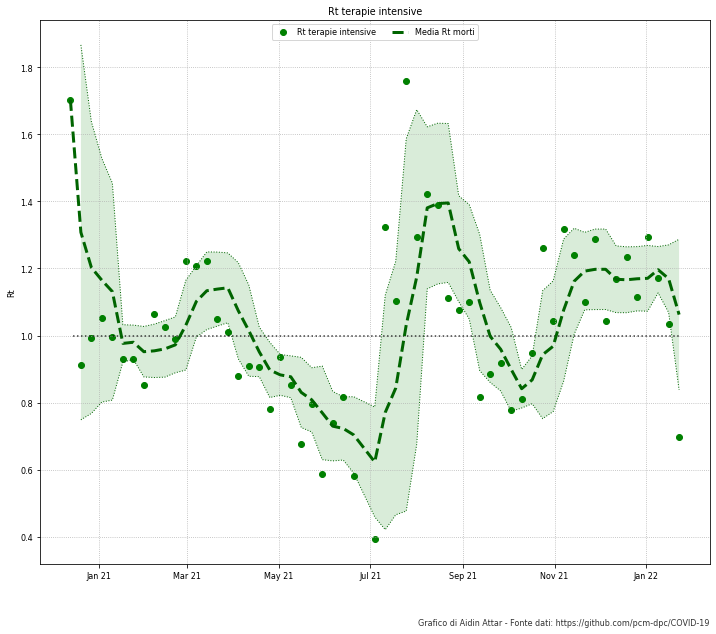

In [76]:
fig, ax = plt.subplots(figsize=(12,10))
ax.hlines(1, date(2020, 12, 15),italia_week.index.max(), color='black', linestyle='dotted', alpha=0.75)

ax.scatter(italia_week.index, italia_week.incremento_ingressi_terapia_intensiva, color='green', label='Rt terapie intensive')
ax.plot(italia_week.index, italia_week.media_incremento_ingressi_terapia_intensiva, lw=3, color='darkgreen', linestyle='dashed', label='Media Rt morti')
ax.plot(italia_week.index, italia_week.media_incremento_ingressi_terapia_intensiva+italia_week.std_incremento_ingressi_terapia_intensiva, lw=1, color='darkgreen', linestyle='dotted', label='')
ax.plot(italia_week.index, italia_week.media_incremento_ingressi_terapia_intensiva-italia_week.std_incremento_ingressi_terapia_intensiva, lw=1, color='darkgreen', linestyle='dotted', label='')
plt.fill_between(italia_week.index,
                 italia_week.media_incremento_ingressi_terapia_intensiva+italia_week.std_incremento_ingressi_terapia_intensiva,
                 italia_week.media_incremento_ingressi_terapia_intensiva-italia_week.std_incremento_ingressi_terapia_intensiva,
                 facecolor="green", alpha=0.15)

ax.grid(linestyle='dotted')
ax.legend(loc='upper center', ncol=3)
ax.set_ylabel('Rt')
ax.set_title('Rt terapie intensive')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

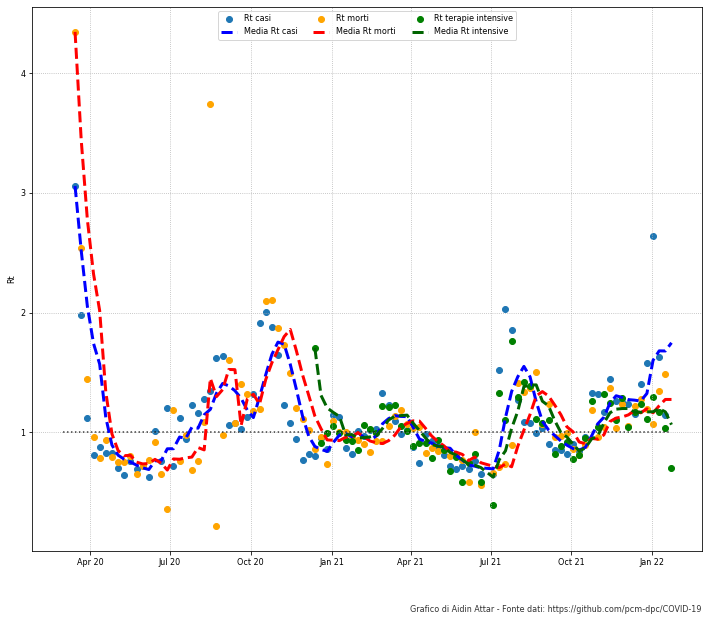

In [77]:
fig, ax = plt.subplots(figsize=(12,10))
ax.hlines(1, italia_week.index.min(),italia_week.index.max(), color='black', linestyle='dotted', alpha=0.75)

ax.scatter(italia_week.index, italia_week.incremento_casi_settimanali, color='C0', label='Rt casi')
ax.plot(italia_week.index, italia_week.media_incremento_casi_settimanali, lw=3, color='blue', linestyle='dashed', label='Media Rt casi')

ax.scatter(italia_week.index, italia_week.incremento_morti_settimanali, color='orange', label='Rt morti')
ax.plot(italia_week.index, italia_week.media_incremento_morti_settimanali, lw=3, color='red', linestyle='dashed', label='Media Rt morti')

ax.scatter(italia_week.index, italia_week.incremento_ingressi_terapia_intensiva, color='green', label='Rt terapie intensive')
ax.plot(italia_week.index, italia_week.media_incremento_ingressi_terapia_intensiva, lw=3, color='darkgreen', linestyle='dashed', label='Media Rt intensive')

ax.grid(linestyle='dotted')
ax.legend(loc='upper center', ncol=3)
ax.set_ylabel('Rt')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

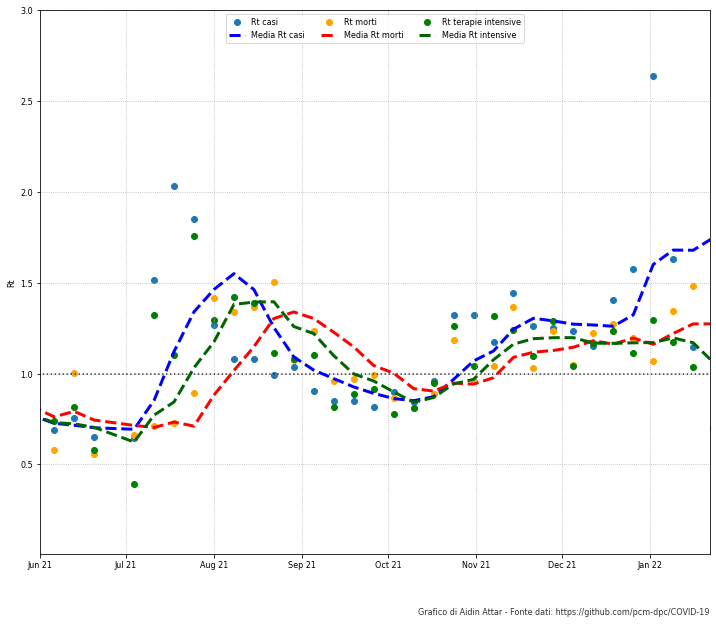

In [78]:
fig, ax = plt.subplots(figsize=(12,10))
ax.hlines(1, italia_week.index.min(),italia_week.index.max(), color='black', linestyle='dotted', alpha=0.75)

ax.scatter(italia_week.index, italia_week.incremento_casi_settimanali, color='C0', label='Rt casi')
ax.plot(italia_week.index, italia_week.media_incremento_casi_settimanali, lw=3, color='blue', linestyle='dashed', label='Media Rt casi')

ax.scatter(italia_week.index, italia_week.incremento_morti_settimanali, color='orange', label='Rt morti')
ax.plot(italia_week.index, italia_week.media_incremento_morti_settimanali, lw=3, color='red', linestyle='dashed', label='Media Rt morti')

ax.scatter(italia_week.index, italia_week.incremento_ingressi_terapia_intensiva, color='green', label='Rt terapie intensive')
ax.plot(italia_week.index, italia_week.media_incremento_ingressi_terapia_intensiva, lw=3, color='darkgreen', linestyle='dashed', label='Media Rt intensive')

ax.grid(linestyle='dotted')
ax.legend(loc='upper center', ncol=3)

ax.set_xlim([date(2021, 6, 1), today])
ax.set_ylim(top=3)
ax.set_ylabel('Rt')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

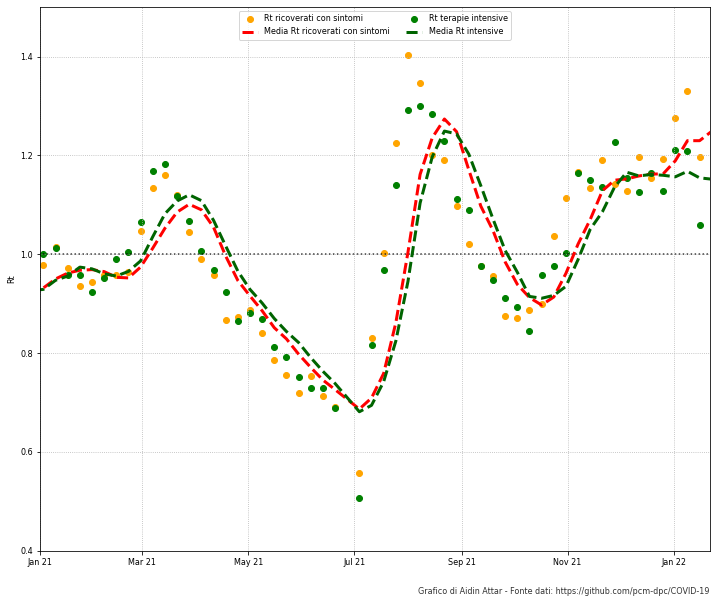

In [116]:
fig, ax = plt.subplots(figsize=(12,10))
ax.hlines(1, italia_week.index.min(),italia_week.index.max(), color='black', linestyle='dotted', alpha=0.75)

ax.scatter(italia_week.index, italia_week.incremento_ricoverati, color='orange', label='Rt ricoverati con sintomi')
ax.plot(italia_week.index, italia_week.media_incremento_ricoverati, lw=3, color='red', linestyle='dashed', label='Media Rt ricoverati con sintomi')

ax.scatter(italia_week.index, italia_week.incremento_terapie_intensive, color='green', label='Rt terapie intensive')
ax.plot(italia_week.index, italia_week.media_incremento_terapie_intensive, lw=3, color='darkgreen', linestyle='dashed', label='Media Rt intensive')

ax.grid(linestyle='dotted')
ax.legend(loc='upper center', ncol=2)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

ax.set_xlim([date(2021, 1, 1), today])
ax.set_ylim(top=1.5, bottom=.4)
ax.set_ylabel('Rt')

plt.text(0.9, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

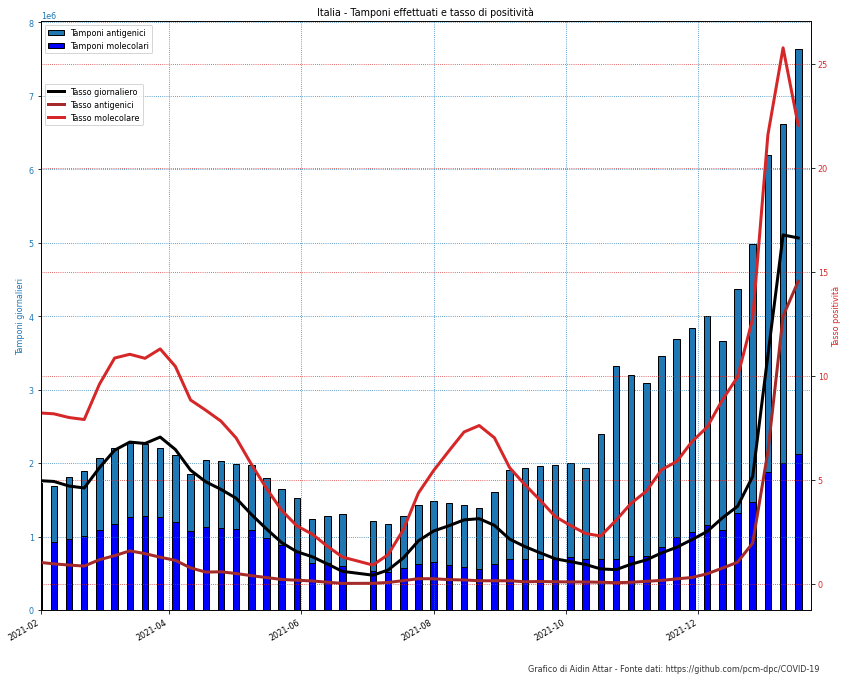

In [80]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'

ax1.bar(italia_week.index, italia_week.tamponi_settimanali,
        color='C0', edgecolor='black', width=3, label='Tamponi antigenici')
ax1.bar(italia_week.index, italia_week.tamponi_test_molecolare_sett,
        color='blue', edgecolor='black', width=3, label='Tamponi molecolari')

ax1.set_xlim([date(2021, 2, 1), today])
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Italia - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.plot(italia_week.index, italia_week.tasso_positivi,
           color = 'black', lw=3, label = 'Tasso giornaliero')
ax2.plot(italia_week.index, italia_week.tasso_antigenico_rapido,
           color = 'brown', lw=3, label = 'Tasso antigenici')
ax2.plot(italia_week.index, italia_week.tasso_molecolare,
            color = color, lw=3, label = 'Tasso molecolare')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(bottom=0, top=30)
ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax1.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

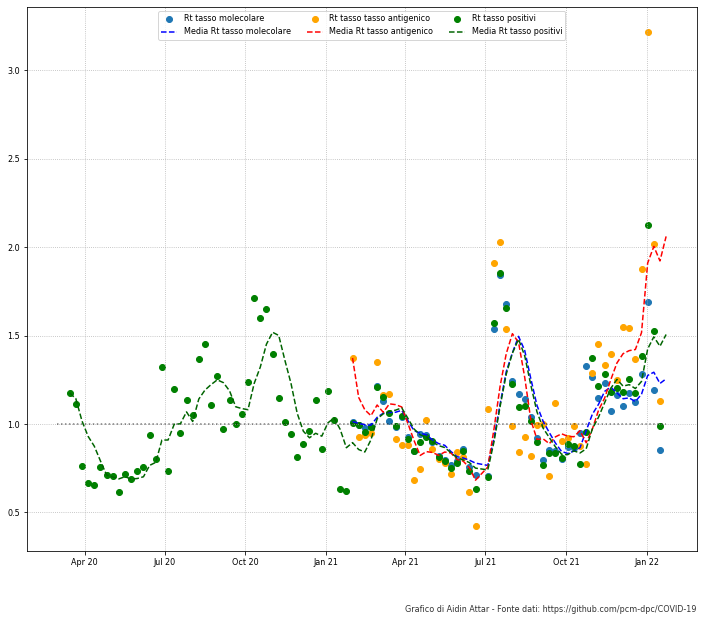

In [81]:
fig, ax = plt.subplots(figsize=(12,10))
ax.hlines(1, italia_week.index.min(),italia_week.index.max(), color='black', linestyle='dotted', alpha=0.5)

ax.scatter(italia_week.index, italia_week.incremento_tasso_molecolare, color='C0', label='Rt tasso molecolare')
ax.plot(italia_week.index, italia_week.media_incremento_tasso_molecolare, color='blue', linestyle='dashed', label='Media Rt tasso molecolare')

ax.scatter(italia_week.index, italia_week.incremento_tasso_antigenico_rapido, color='orange', label='Rt tasso tasso antigenico')
ax.plot(italia_week.index, italia_week.media_incremento_tasso_antigenico_rapido, color='red', linestyle='dashed', label='Media Rt tasso antigenico')

ax.scatter(italia_week.index, italia_week.incremento_tasso_positivi, color='green', label='Rt tasso positivi')
ax.plot(italia_week.index, italia_week.media_incremento_tasso_positivi, color='darkgreen', linestyle='dashed', label='Media Rt tasso positivi')

ax.grid(linestyle='dotted')
ax.legend(loc='upper center', ncol=3)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

1193792.4102789087 8.815539086940065 1.508309569805278
Power_divergenceResult(statistic=43934.750746471145, pvalue=0.0)


Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità')

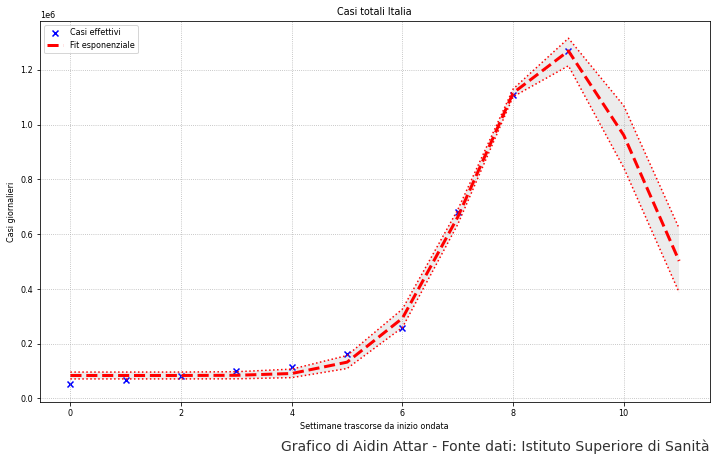

In [128]:
lastday = (date.today() - timedelta(days=70))
italia_week_fit           = italia_week.loc[lastday:today]
italia_week_fit.insert(0, 'New_ID', range(0,len(italia_week_fit)))
italia_week_fit.set_index('New_ID', inplace=True)

popt, pcov = optimize.curve_fit(gaussian, italia_week_fit.index, italia_week_fit.casi_settimanali, p0=(2e6,8,2, 4e4))

top  = gaussian(np.arange(12), popt[0]+pcov[0,0]**0.5,popt[1]+pcov[1,1]**0.5,popt[2]+pcov[2,2]**0.5,popt[3]+pcov[3,3]**0.5)
real = gaussian(np.arange(12), popt[0],popt[1],popt[2],popt[3])
bott = gaussian(np.arange(12), popt[0]-pcov[0,0]**0.5,popt[1]-pcov[1,1]**0.5,popt[2]-pcov[2,2]**0.5,popt[3]-pcov[3,3]**0.5)

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(italia_week_fit.index, italia_week_fit.casi_settimanali, marker='x', color='blue', label='Casi effettivi')
ax.plot(np.arange(12), real, linestyle='dashed',c = 'r', label='Fit esponenziale', lw=3)
ax.plot(np.arange(12), top , linestyle='dotted',c = 'r', label='')
ax.plot(np.arange(12), bott, linestyle='dotted',c = 'r', label='')
plt.fill_between(np.arange(12), top, bott, facecolor="gray", alpha=0.15)
ax.grid(linestyle='dotted')
ax.set_title('Casi totali Italia')
ax.set_xlabel('Settimane trascorse da inizio ondata')
ax.set_ylabel('Casi giornalieri')
ax.legend(loc='upper left')
#ax.set_yscale("log")
print(popt[0],popt[1],popt[2])
ax.xaxis.set_major_locator(MultipleLocator(2))
#ax.hlines(italia_week_fit['casi_settimanali'].max(), 2,5, linestyle='dashed')

print(stats.chisquare(gaussian(italia_week_fit.index, popt[0],popt[1],popt[2],popt[3]), italia_week_fit.casi_settimanali, ddof=italia_week_fit.index.size - 3))


plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

In [83]:
italy_week = gpd.read_file('../mappe/italy-with-regions/reg2011_g.shp')
oggi = [Regioni_week[key].iloc[-2] for key in Regioni_week.keys()]
cum = pd.DataFrame(oggi)

cum1 = cum.set_index('denominazione_regione')
sum_ = cum1.reindex(['P.A. Trento', 'P.A. Bolzano']).sum().to_frame().transpose()
sum_ = sum_.rename(index={0: 'Trentino-Alto Adige/Sudtirol'})
cum1.drop(['P.A. Trento', 'P.A. Bolzano'],inplace=True)
cum1 = cum1.append(sum_)
cum1 = cum1.sort_index()
italy_week.sort_values(by = 'NOME_REG', inplace = True)
italy_week.reset_index(drop=True,       inplace = True)
italy_week.index = cum1.index

italy_week = italy_week.merge(cum1,left_index=True, right_index=True, how='right')
italy_week.at['Trentino-Alto Adige/Sudtirol',                  'morti_settimanali_norm'] = italy_week.at['Trentino-Alto Adige/Sudtirol',                  'morti_settimanali'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy_week.at['Trentino-Alto Adige/Sudtirol',                   'casi_settimanali_norm'] = italy_week.at['Trentino-Alto Adige/Sudtirol',                   'casi_settimanali'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy_week.at['Trentino-Alto Adige/Sudtirol',                      'tamponi_norm'] = italy_week.at['Trentino-Alto Adige/Sudtirol',                      'tamponi'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy_week.at['Trentino-Alto Adige/Sudtirol','tamponi_test_molecolare_sett_norm'] = italy_week.at['Trentino-Alto Adige/Sudtirol','tamponi_test_molecolare_sett'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy_week.at['Trentino-Alto Adige/Sudtirol', 'tamponi_test_antigenico_rapido_sett_norm'] = italy_week.at['Trentino-Alto Adige/Sudtirol', 'tamponi_test_antigenico_rapido_sett'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000

/tmp/ipykernel_151588/1474238503.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_ = cum1.reindex(['P.A. Trento', 'P.A. Bolzano']).sum().to_frame().transpose()


Text(0.85, 0.15, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

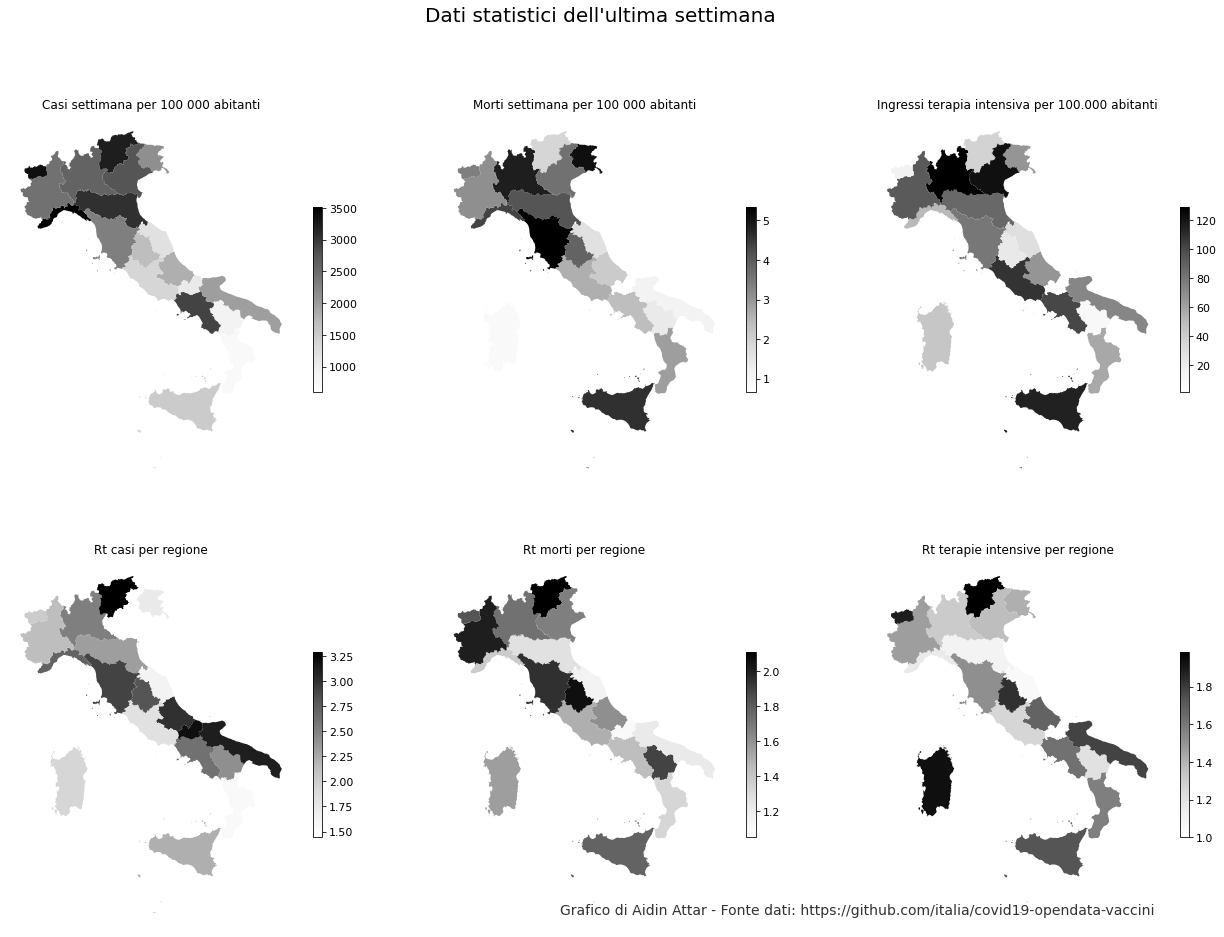

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(22, 15))
col1 = 'casi_settimanali_norm'
ax[0,0].set_title('Casi settimana per 100 000 abitanti', fontsize=12)
             #fontdict={'fontsize':'12', 'fontweight':'3'},
             #color='Orange',
             #fontfamily='monospace')


normalize1 = mcolors.Normalize(vmin=italy_week[col1].min(), vmax=italy_week[col1].max())
scalarmappaple1 = cm.ScalarMappable(norm=normalize1, cmap="Greys")
#scalarmappaple.set_array(italy_week['cumulativa_totale_per100'])

italy_week.plot(ax=ax[0,0],
           column=col1,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple1, ax=ax[0,0],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col2 = 'morti_settimanali_norm'
ax[0,1].set_title('Morti settimana per 100 000 abitanti', fontsize=12)
             #fontdict={'fontsize':'12', 'fontweight':'3'},
             #color='Orange',
             #fontfamily='monospace')


normalize2 = mcolors.Normalize(vmin=italy_week[col2].min(), vmax=italy_week[col2].max())
scalarmappaple2 = cm.ScalarMappable(norm=normalize2, cmap="Greys")
#scalarmappaple.set_array(italy_week['cumulativa_totale_per100'])

italy_week.plot(ax=ax[0,1],
           column=col2,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple2, ax=ax[0,1],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col1 = 'media_incremento_casi_settimanali'
ax[1,0].set_title('Rt casi per regione', fontsize=12)
             #fontdict={'fontsize':'12', 'fontweight':'3'},
             #color='Orange',
             #fontfamily='monospace')


normalize1 = mcolors.Normalize(vmin=italy_week[col1].min(), vmax=italy_week[col1].max())
scalarmappaple1 = cm.ScalarMappable(norm=normalize1, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy_week.plot(ax=ax[1,0],
           column=col1,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple1, ax=ax[1,0],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col2 = 'media_incremento_morti_settimanali'
ax[1,1].set_title('Rt morti per regione', fontsize=12)
             #fontdict={'fontsize':'12', 'fontweight':'3'},)
             #color='Orange',
             #fontfamily='monospace')


normalize2 = mcolors.Normalize(vmin=italy_week[col2].min(), vmax=italy_week[col2].max())
scalarmappaple2 = cm.ScalarMappable(norm=normalize2, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy_week.plot(ax=ax[1,1],
           column=col2,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple2, ax=ax[1,1],shrink=0.5)
cbar.ax.tick_params(labelsize=11)


col1 = 'ingressi_terapia_intensiva'
ax[0,2].set_title('Ingressi terapia intensiva per 100.000 abitanti', fontsize=12)
             #fontdict={'fontsize':'12', 'fontweight':'3'},
             #color='Orange',
             #fontfamily='monospace')


normalize1 = mcolors.Normalize(vmin=italy_week[col1].min(), vmax=italy_week[col1].max())
scalarmappaple1 = cm.ScalarMappable(norm=normalize1, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy_week.plot(ax=ax[0,2],
           column=col1,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple1, ax=ax[0,2],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col2 = 'media_incremento_ingressi_terapia_intensiva'
ax[1,2].set_title('Rt terapie intensive per regione', fontsize=12)
             #fontdict={'fontsize':'12', 'fontweight':'3'},
             #color='Orange',
             #fontfamily='monospace')


normalize2 = mcolors.Normalize(vmin=italy_week[col2].min(), vmax=italy_week[col2].max())
scalarmappaple2 = cm.ScalarMappable(norm=normalize2, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy_week.plot(ax=ax[1,2],
           column=col2,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple2, ax=ax[1,2],shrink=0.5)
cbar.ax.tick_params(labelsize=11)


ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[0,2].axis('off')
ax[1,2].axis('off')

fig.suptitle("Dati statistici dell'ultima settimana", fontsize=20)


plt.text(0.85, 0.15, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

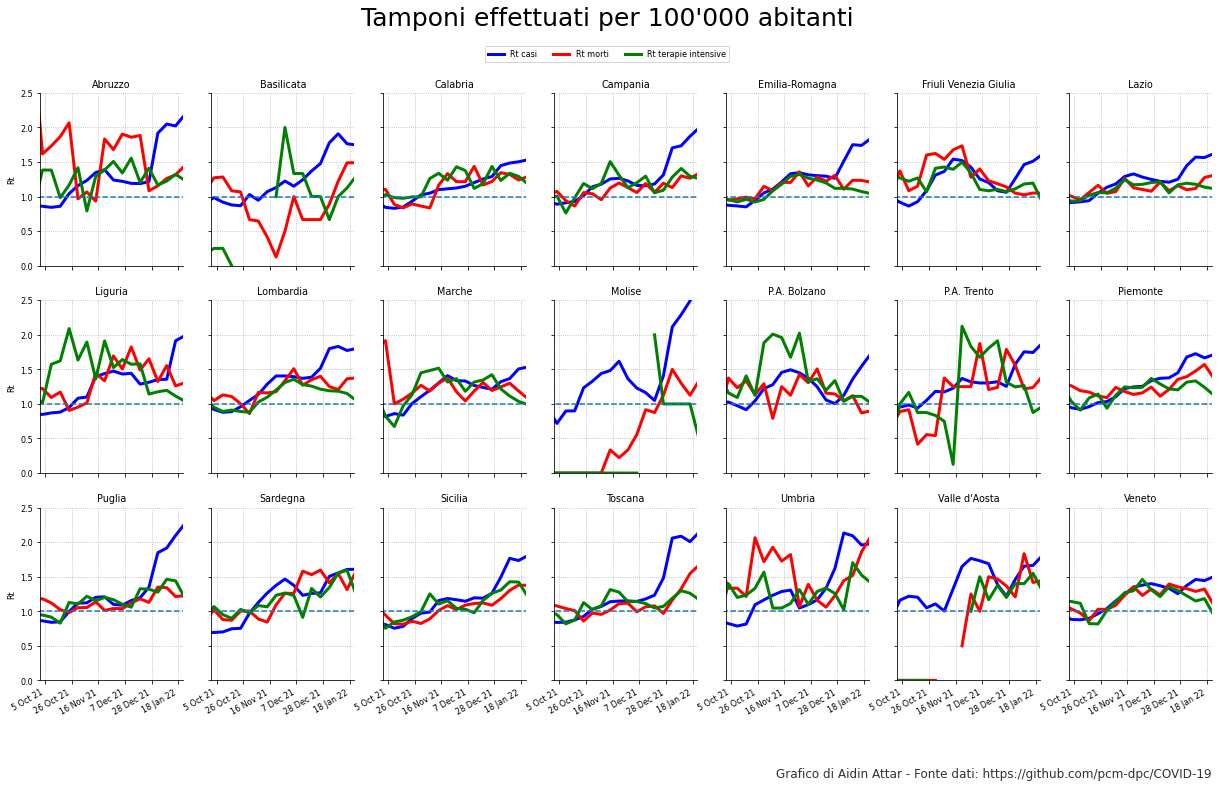

In [85]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni_week.keys():
    ax[y,x].plot(Regioni_week[key].index, Regioni_week[key][          'media_incremento_casi_settimanali'],c='blue',  lw=3)
    ax[y,x].plot(Regioni_week[key].index, Regioni_week[key][         'media_incremento_morti_settimanali'],c='red',   lw=3)
    ax[y,x].plot(Regioni_week[key].index, Regioni_week[key]['media_incremento_ingressi_terapia_intensiva'],c='green', lw=3)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].hlines(1, Regioni_week[key].index.min(),Regioni_week[key].index.max(), linestyle='dashed')
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Rt')
ax[1,0].set_ylabel('Rt')
ax[2,0].set_ylabel('Rt')
ax[0,0].set_ylim(bottom=0, top=2.5)
fig.autofmt_xdate()
fig.suptitle("Tamponi effettuati per 100'000 abitanti", fontsize=25)

labels = ['Rt casi', 'Rt morti', 'Rt terapie intensive']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

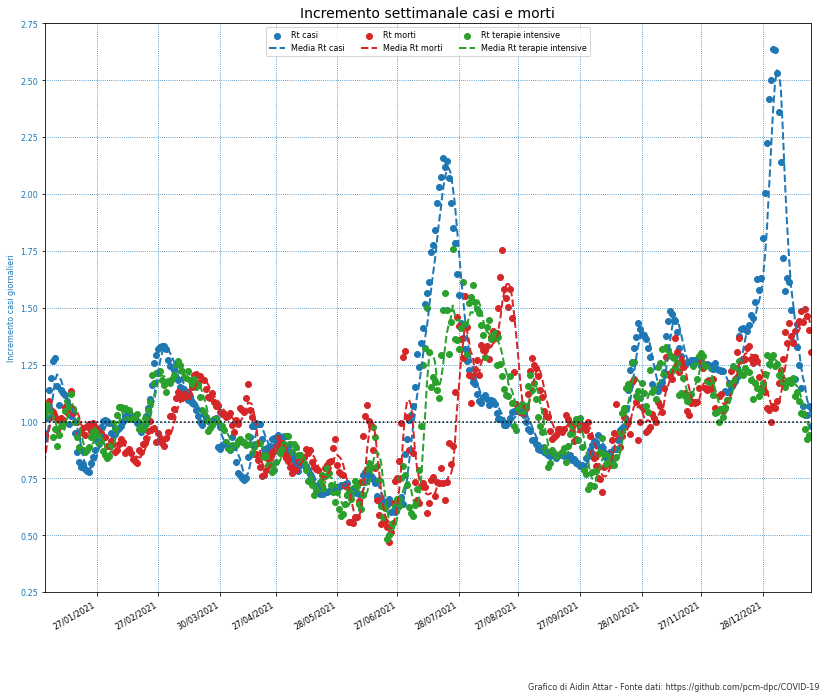

In [86]:
day1 = (date.today() + timedelta(days=10)).strftime('%d/%m/%Y')

fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.scatter(italia.index, italia.incremento_casi_giornalieri,
            color=color, label = 'Rt casi')
ax1.plot(italia.index, italia.media_incremento_casi_giornalieri,
         color=color, label = 'Media Rt casi',
         lw=2, linestyle='dashed')

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Incremento casi giornalieri', color=color)

ax1.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.grid(linestyle='dotted',color=color)
ax1.set_ylim(bottom = 0.25, top=2.75)
ax1.set_title('Incremento settimanale casi e morti', fontsize=14)

color = 'tab:red'
ax1.scatter(italia.index, italia.incremento_morti_giornalieri,
            color=color, label = 'Rt morti')
ax1.plot(italia.index, italia.media_incremento_morti_giornalieri,
         color = color, label = 'Media Rt morti',
         lw=2, linestyle='dashed')


color = 'tab:green'
ax1.scatter(italia.index, italia.incremento_ingressi_terapia_intensiva,
            color=color, label = 'Rt terapie intensive')
ax1.plot(italia.index, italia.media_incremento_ingressi_terapia_intensiva,
         color = color, label = 'Media Rt terapie intensive',
         lw=2, linestyle='dashed')

ax1.hlines(1, italia.index.min(),day1, color='black', linestyle='dotted', alpha=1)
fig.autofmt_xdate()
ax1.legend(loc='upper center', ncol=3)

ax2.set_xlabel('')
ax2.grid(linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Incremento morti giornalieri', color=color)  # we already handled the x-label with ax1
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.yaxis.set_major_locator(MultipleLocator(.25))
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

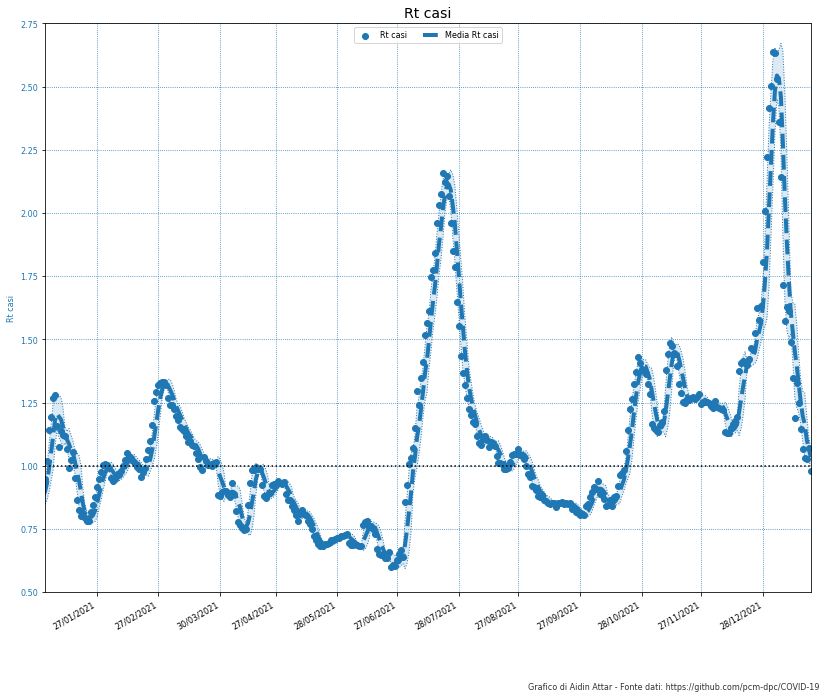

In [87]:
fig, ax = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax.scatter(italia.index, italia.incremento_casi_giornalieri,
            color=color, label = 'Rt casi', marker='o')
ax.plot(italia.index, italia.media_incremento_casi_giornalieri,
         color=color, label = 'Media Rt casi',
         lw=4, linestyle='dashed')
ax.plot(italia.index, italia.media_incremento_casi_giornalieri+italia.std_incremento_casi_giornalieri,
         color=color, label = '',
         lw=1, linestyle='dotted')
ax.plot(italia.index, italia.media_incremento_casi_giornalieri-italia.std_incremento_casi_giornalieri,
         color=color, label = '',
         lw=1, linestyle='dotted')
plt.fill_between(italia.index,
                 italia.media_incremento_casi_giornalieri+italia.std_incremento_casi_giornalieri,
                 italia.media_incremento_casi_giornalieri-italia.std_incremento_casi_giornalieri,
                 facecolor=color, alpha=0.15)
ax.hlines(1, italia.index.min(),day1, color='black', linestyle='dotted', alpha=1)

ax.tick_params(axis='y', labelcolor=color)
ax.set_xlabel('')
ax.set_ylabel('Rt casi', color=color)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.yaxis.set_major_locator(MultipleLocator(.25))

ax.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.grid(linestyle='dotted',color=color)
ax.set_ylim(bottom = .5, top=2.75)
ax.set_title('Rt casi', fontsize=14)

fig.autofmt_xdate()
ax.legend(loc='upper center', ncol=2)
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

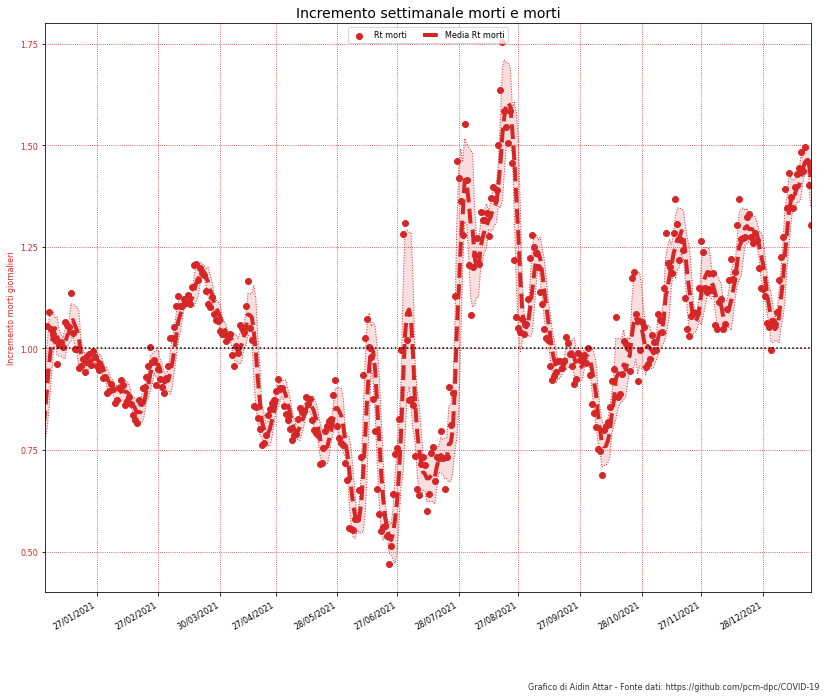

In [88]:
fig, ax = plt.subplots(figsize=(12,10))

color = 'tab:red'
ax.scatter(italia.index, italia.incremento_morti_giornalieri,
            color=color, label = 'Rt morti')
ax.plot(italia.index, italia.media_incremento_morti_giornalieri,
         color=color, label = 'Media Rt morti',
         lw=4, linestyle='dashed')
ax.plot(italia.index, italia.media_incremento_morti_giornalieri+italia.std_incremento_morti_giornalieri,
         color=color, label = '',
         lw=1, linestyle='dotted')
ax.plot(italia.index, italia.media_incremento_morti_giornalieri-italia.std_incremento_morti_giornalieri,
         color=color, label = '',
         lw=1, linestyle='dotted')
plt.fill_between(italia.index,
                 italia.media_incremento_morti_giornalieri+italia.std_incremento_morti_giornalieri,
                 italia.media_incremento_morti_giornalieri-italia.std_incremento_morti_giornalieri,
                 facecolor=color, alpha=0.15)
ax.hlines(1, italia.index.min(),day1, color='black', linestyle='dotted', alpha=1)

ax.tick_params(axis='y', labelcolor=color)
ax.set_xlabel('')
ax.set_ylabel('Incremento morti giornalieri', color=color)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.yaxis.set_major_locator(MultipleLocator(.25))

ax.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.grid(linestyle='dotted',color=color)
ax.set_ylim(bottom = .4, top=1.8)
ax.set_title('Incremento settimanale morti e morti', fontsize=14)

fig.autofmt_xdate()
ax.legend(loc='upper center', ncol=2)
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

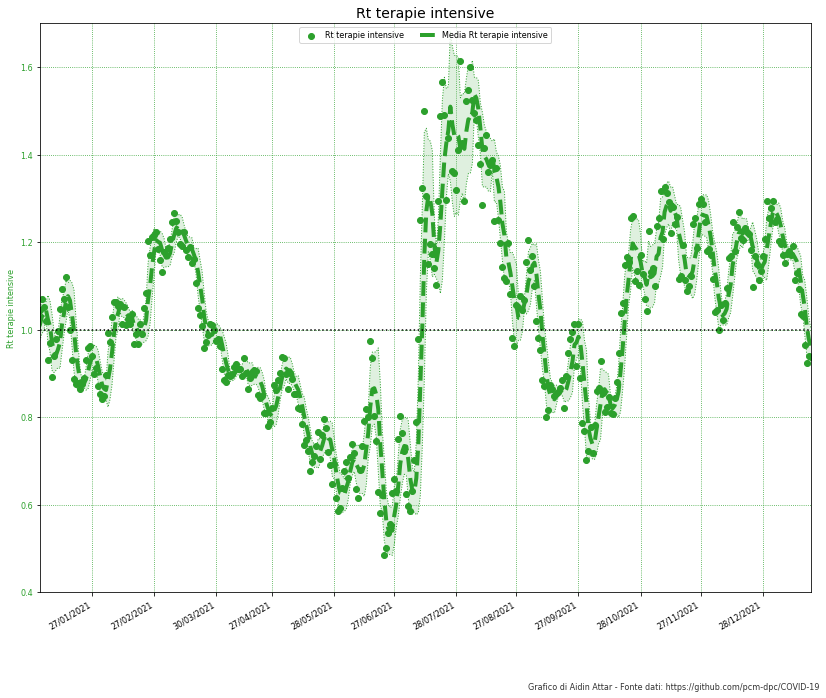

In [89]:
fig, ax = plt.subplots(figsize=(12,10))

color = 'tab:green'
ax.scatter(italia.index, italia.incremento_ingressi_terapia_intensiva,
            color=color, label = 'Rt terapie intensive')
ax.plot(italia.index, italia.media_incremento_ingressi_terapia_intensiva,
         color=color, label = 'Media Rt terapie intensive',
         lw=4, linestyle='dashed')
ax.plot(italia.index, italia.media_incremento_ingressi_terapia_intensiva+italia.std_incremento_ingressi_terapia_intensiva,
         color=color, label = '',
         lw=1, linestyle='dotted')
ax.plot(italia.index, italia.media_incremento_ingressi_terapia_intensiva-italia.std_incremento_ingressi_terapia_intensiva,
         color=color, label = '',
         lw=1, linestyle='dotted')
plt.fill_between(italia.index,
                 italia.media_incremento_ingressi_terapia_intensiva+italia.std_incremento_ingressi_terapia_intensiva,
                 italia.media_incremento_ingressi_terapia_intensiva-italia.std_incremento_ingressi_terapia_intensiva,
                 facecolor=color, alpha=0.15)
ax.hlines(1, italia.index.min(),day1, color='black', linestyle='dotted', alpha=1)


ax.tick_params(axis='y', labelcolor=color)
ax.set_xlabel('')
ax.set_ylabel('Rt terapie intensive', color=color)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.yaxis.set_major_locator(MultipleLocator(.2))

ax.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.grid(linestyle='dotted',color=color)
ax.set_ylim(bottom=.4, top=1.7)
ax.set_title('Rt terapie intensive', fontsize=14)

fig.autofmt_xdate()
ax.legend(loc='upper center', ncol=2)
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

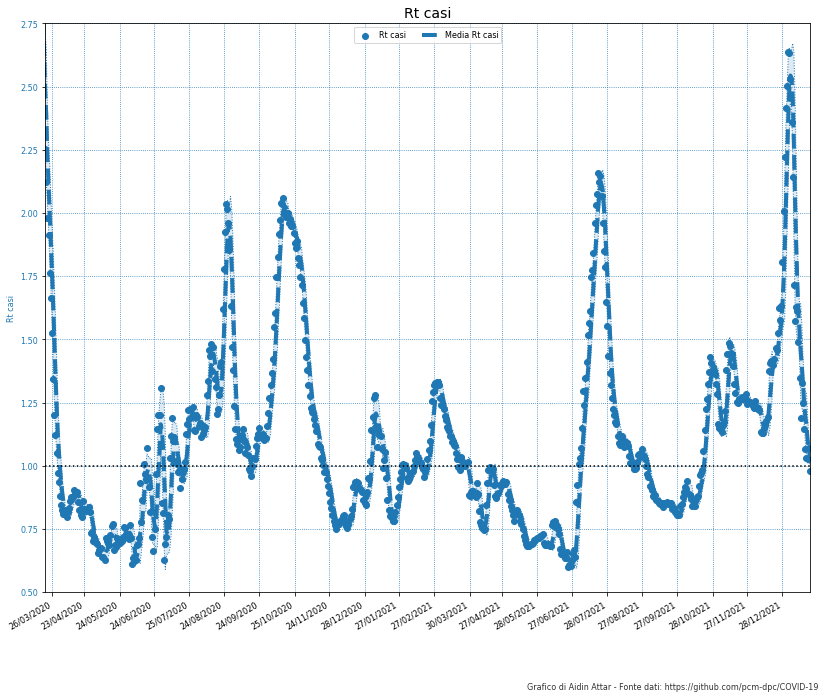

In [90]:
fig, ax = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax.scatter(italia.index, italia.incremento_casi_giornalieri,
            color=color, label = 'Rt casi', marker='o')
ax.plot(italia.index, italia.media_incremento_casi_giornalieri,
         color=color, label = 'Media Rt casi',
         lw=4, linestyle='dashed')
ax.plot(italia.index, italia.media_incremento_casi_giornalieri+italia.std_incremento_casi_giornalieri,
         color=color, label = '',
         lw=1, linestyle='dotted')
ax.plot(italia.index, italia.media_incremento_casi_giornalieri-italia.std_incremento_casi_giornalieri,
         color=color, label = '',
         lw=1, linestyle='dotted')
plt.fill_between(italia.index,
                 italia.media_incremento_casi_giornalieri+italia.std_incremento_casi_giornalieri,
                 italia.media_incremento_casi_giornalieri-italia.std_incremento_casi_giornalieri,
                 facecolor=color, alpha=0.15)
ax.hlines(1, date(2020, 3, 20).strftime('%d/%m/%Y'),day1, color='black', linestyle='dotted', alpha=1)

ax.tick_params(axis='y', labelcolor=color)
ax.set_xlabel('')
ax.set_ylabel('Rt casi', color=color)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.yaxis.set_major_locator(MultipleLocator(.25))

ax.set_xlim([date(2020, 3, 20).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.grid(linestyle='dotted',color=color)
ax.set_ylim(bottom = .5, top=2.75)
ax.set_title('Rt casi', fontsize=14)

fig.autofmt_xdate()
ax.legend(loc='upper center', ncol=2)
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

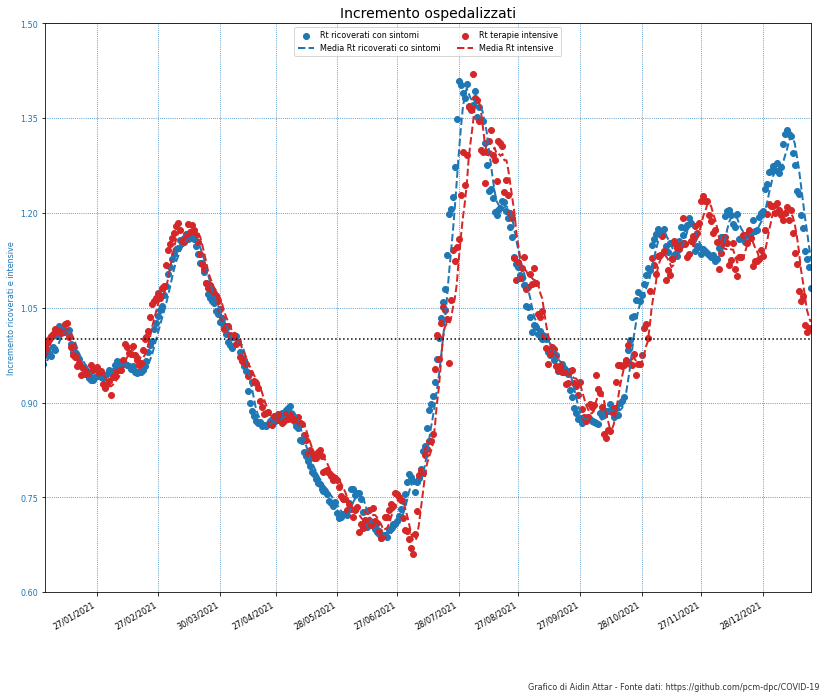

In [91]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.scatter(italia.index, italia.incremento_ricoverati,
            color=color, label = 'Rt ricoverati con sintomi')
ax1.plot(italia.index, italia.media_incremento_ricoverati,
         color=color, label = 'Media Rt ricoverati co sintomi',
         lw=2, linestyle='dashed')

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Incremento ricoverati e intensive', color=color)

ax1.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.grid(linestyle='dotted',color=color)
ax1.set_ylim(bottom = 0.6, top=1.5)
ax1.set_title('Incremento ospedalizzati', fontsize=14)

color = 'tab:red'
ax1.scatter(italia.index, italia.incremento_terapie_intensive,
            color=color, label = 'Rt terapie intensive')
ax1.plot(italia.index, italia.media_incremento_terapie_intensive,
         color = color, label = 'Media Rt intensive',
         lw=2, linestyle='dashed')

ax1.hlines(1, italia.index.min(),day1, color='black', linestyle='dotted', alpha=1)
fig.autofmt_xdate()
ax1.legend(loc='upper center', ncol=2)

ax2.set_xlabel('')
ax2.grid(linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Incremento morti giornalieri', color=color)  # we already handled the x-label with ax1
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.yaxis.set_major_locator(MultipleLocator(.15))
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()




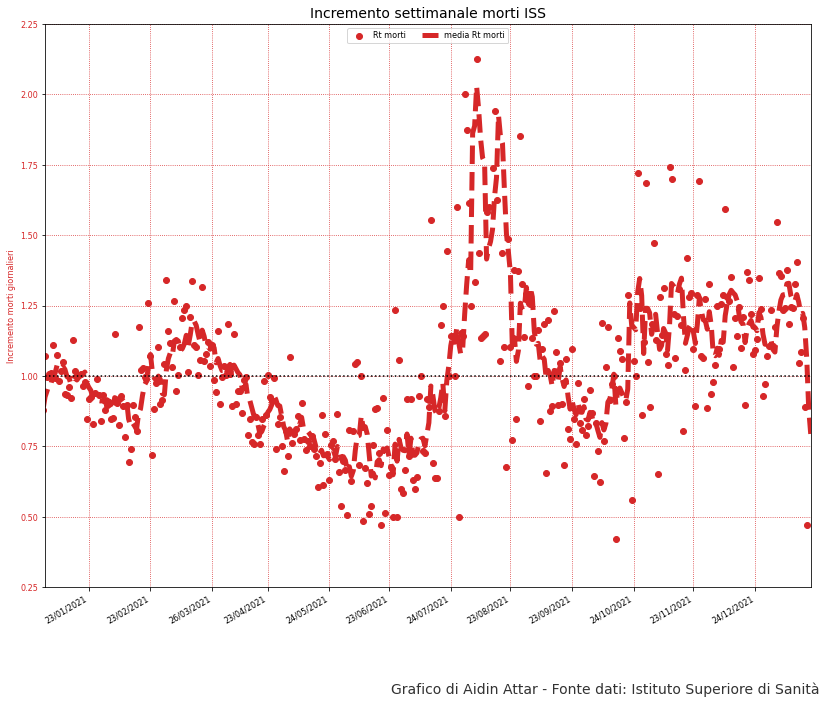

In [92]:
fig, ax = plt.subplots(figsize=(12,10))

color = 'tab:red'
ax.scatter(ISS_decessi.index, ISS_decessi.DECESSI/ISS_decessi.DECESSI.shift(7),
            color=color, label = 'Rt morti')
ax.plot(ISS_decessi.index, (ISS_decessi.DECESSI/ISS_decessi.DECESSI.shift(7)).rolling(window=7, min_periods=1).mean(),
            color=color, label = 'media Rt morti', linestyle='dashed', lw=5)
ax.hlines(1, italia.index.min(),day1, color='black', linestyle='dotted', alpha=1)

ax.tick_params(axis='y', labelcolor=color)
ax.set_xlabel('')
ax.set_ylabel('Incremento morti giornalieri', color=color)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.yaxis.set_major_locator(MultipleLocator(.25))

ax.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.grid(linestyle='dotted',color=color)
ax.set_ylim(bottom = .25, top=2.25)
ax.set_title('Incremento settimanale morti ISS', fontsize=14)

fig.autofmt_xdate()
ax.legend(loc='upper center', ncol=2)
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: Istituto Superiore di Sanità',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

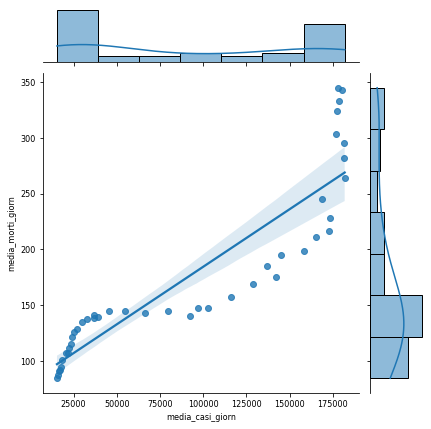

In [93]:
g = sns.jointplot(x='media_casi_giorn',
                  y='media_morti_giorn',
                  data=italia_fit,
                  kind="reg")

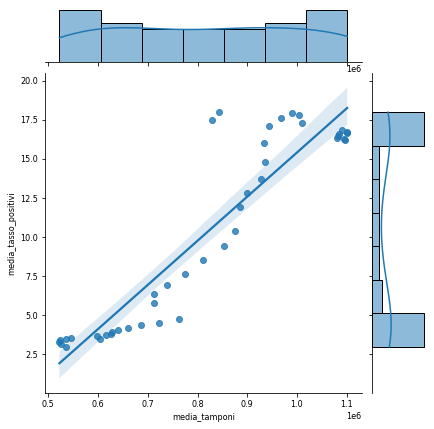

In [94]:
g = sns.jointplot(x='media_tamponi',
                  y='media_tasso_positivi',
                  data=italia_fit,
                  kind="reg")

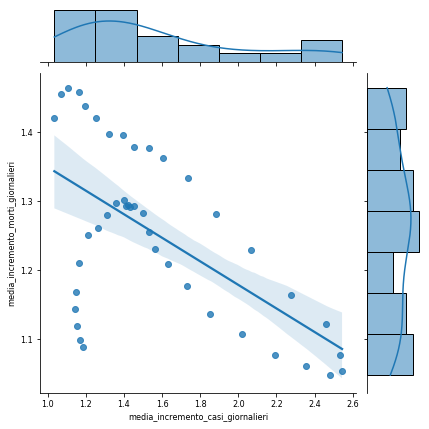

In [95]:
g = sns.jointplot(x='media_incremento_casi_giornalieri',
                  y='media_incremento_morti_giornalieri',
                  data=italia_fit,
                  kind="reg")

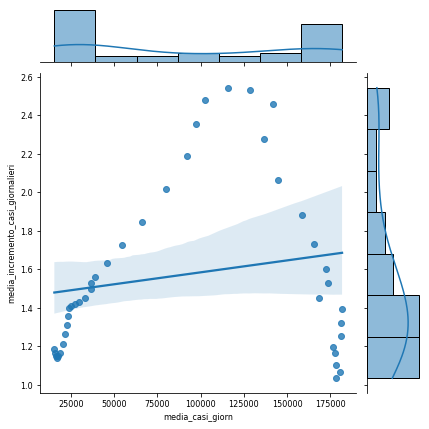

In [96]:
g = sns.jointplot(x='media_casi_giorn',
                  y='media_incremento_casi_giornalieri',
                  data=italia_fit,
                  kind="reg")